# Process GM-SEUS for All Final Attributes
This includes: Installation Year, Ground Cover Ratio, Module Type, Agrivoltaic Type, Module Efficiency, and Installed Capacity 

NOTE: This script is currently set up to output each intermediate product for observation. The code chunks are meant to run in order, requiring the prior chunks output for the next's inputs. This means when we update code, we have to doublecheck that files are being called from the prior chunk for updated data. 

**Important notes for v1.0 of this script and dataset**
* **Regarding GMSEUS_Arrays_InstYr.shp issue**: This is partially discussed in `script5` as well. 
* **Regarding CWSD Arrays**: In `script1`, we neglected to remove repeat CWSD array shapes. That means we have to do that here (for initial arrays, landtrendr outputs, and initial panel-row outputs from NAIP), which is why there is temporary code for_Remove Duplicate CWSD Arrays and Panel-Rows_ in this script, which needs to be removed on operation of v2.0.
* **Regarding panel-rows that overlap multiple arrays**: The initial panel-row dataset (GMSEUS_Panels_ExistingAndNAIP.shp) contains 460 duplicate panelID's. Additionally, when we copy arrayID's via spatial join (twice, once in _Assign Final Panel-Row Attributes to Panel-Rows** and again in _For arrays with duplicated infomration, group and distribute attributes to arrays and panels accordingly_), panel-rows that overlap multiple arrays end up being duplicated. Currently, we maintain these for the purpose of attribution of variables to arrays, but then remove them in the final panel-row output so that panel-row dataset contains only unique panel rows (counting panel-row area only once). **If this information is desired, panel-rows can either be re-spatially joined with arrays (easiest path) thus creating duplicates, or use one of the intermediateProduct files.

# Import Libraries and Variables

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os 
from shapely.ops import nearest_points
from sklearn.linear_model import LinearRegression

# Import sns
import seaborn as sns

# Import matplotlib
import matplotlib.pyplot as plt

# Load config file
def load_config(filename):
    config = {}
    with open(filename, 'r') as f:
        for line in f:
            # Strip whitespace and split by '='
            key, value = line.strip().split('=')
            # Try to convert to numeric values if possible
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  # Leave as string if not a number
            config[key] = value
    return config

In [2]:
# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
downloaded_path = os.path.join(wd, r'Data\Downloaded')
derived_path = os.path.join(wd, r'Data\Derived')
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')
figure_path = os.path.join(wd, r'Figures')

# Set LandTrendr file paths
lt_folder = os.path.join(derived_path, r'LandTrendrGEEInstallYear')

# Set a GM-SEUS array path for acquiring installation year (exploded grouped arrays -- SAM) and panel path
gmseusArraysInstYrPath = os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr.shp')
gmseusPanelsCombinedPath = os.path.join(derivedTemp_path, r'GMSEUS_Panels_ExistingAndNAIP.shp')

# Set gmseusArraysInstYr spatially joined with point data path, LandTrendr data path, and final instYr path
lt_data_path = os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_LandTrendr.csv')

# Set existing dataset paths
uspvdb_path = os.path.join(derivedTemp_path, r'uspvdb_poly.shp')
ccvpv_path = os.path.join(derivedTemp_path, r'ccvpv_poly.shp')
cwsd_path = os.path.join(derivedTemp_path, r'cwsd_poly.shp')
osm_path = os.path.join(derivedTemp_path, r'osm_poly.shp')
sam_path = os.path.join(derivedTemp_path, r'sam_poly.shp')
inspire_path = os.path.join(derivedTemp_path, r'inspire_point.shp')
lbnlUss_path = os.path.join(derivedTemp_path, r'lbnlUss_point.shp')
gppdb_path = os.path.join(derivedTemp_path, r'gppdb_point.shp')
gspt_path = os.path.join(derivedTemp_path, r'gspt_point.shp')
pvdaq_path = os.path.join(derivedTemp_path, r'pvdaq_point.shp')
solarPaces_path = os.path.join(derivedTemp_path, r'solarPaces_point.shp')

# Set downloaded paths (only needed for attributes we do not assess in srip1 --tilt)
uspvdb_downloaded_path = os.path.join(downloaded_path, r'SolarDB\USPVDB\uspvdb_v2_0_20240801.shp')

# Get US Boundary to subset global/non-CONUS datasets
CONUS_path = os.path.join(wd, r'Data\Downloaded\CONUS_NoGreatLakes\CONUS_No_Great_Lakes.shp')
uspvdb = gpd.read_file(uspvdb_path) # USPVDB shapefile
US_boundary = gpd.read_file(CONUS_path) # CONUS boundary shapefile
US_boundary = US_boundary.set_crs(epsg=4269) # Native projection of US boundary - NAD83
US_boundary = US_boundary.to_crs(uspvdb.crs) # Transform to projection of USPVDB
US_boundary['geometry'] = US_boundary.buffer(10) # Buffer US boundary by 10 meters to ensure that array bounds are not clipped

# Set Tracking the Sun file path
tts_path = os.path.join(downloaded_path, r'TrackingTheSun\TTS_LBNL_public_file_21-Aug-2024_all.csv')

# Set county boundary file path
counties_path = os.path.join(downloaded_path, r'TIGER_Counties\tl_2019_us_county.shp')

# Load the config from the text file
config = load_config('config.txt')

# Load variables
overlapDist = config['overlapDist'] # 190 meters, Set a overlap distance for checking if points/mismatched geometries between Solar PV datasets are duplicates
minPanelRowArea = config['minPanelRowArea'] # 15 m2, minimum area for a single panel row from the 1st percentile panel area from Stid et al., 2022
maxPanelRowArea = config['maxPanelRowArea'] # 254 m2 95th perccentile for a single panel row from Stid et al., 2022. MSU Solar Carport has max 1890m2
minNumPanelRows = config['minNumPanelRows'] # 3 panels, minimum number of panels rows to form a ground mounted solar array, definition from Stid et al., 2022
minPmArRatio = config['minPmArRatio'] # 18.8%, 20% was minimum ratio of panel perimeter to area ratio for panels from Stid et al., 2022, MSU Solar Carport has min 18.9%
panelArrayBuff = config['panelArrayBuff'] # 10m buffer, 20m maximum distance between panel rows to form an array. We used 5m in Stid et al., 2022, but there are lower packing factors at greater latitudes (nativeID: '1229957948')
arrayArrayBuff = config['arrayArrayBuff'] # 20m buffer, 40m maximum distance between arrays subsections of the same mount type to form a complete array. In Stid et al., 2022, we used 50m, but we checked for same installation year in addition to mount type.
lengthRatioThresh = config['lengthRatioThresh']  # If length ratio < 3.0, set to dual_axis or else fixed_axis_diagonal, else single- or fixed-axis
areaRatioThresh = config['areaRatioThresh']  # If area ratio < 0.15, set to fixed_diag_axis, else dual_axis

# Helper Functions

In [3]:
# Function to assign mount type to solar panel-rows based on azimuth and panel geometry. Also returns all relevant design parameters for each panel-row. Requires the setting of a length ratio threshold and an area ratio threshold.
def assignMountType(feature):
    # Estimate azimuth of solar panel-row short edge
    def getAzimuth(feature):
        # Get the minimum bounding rectangle (oriented)
        mbr = feature.geometry.minimum_rotated_rectangle
        
        # Get the coordinates of the MBR
        coords = list(mbr.exterior.coords)
        
        # Calculate distances between consecutive vertices to determine lengths of edges
        edge_lengths = []
        for i in range(len(coords) - 1):  # last point is a duplicate of the first
            p1, p2 = coords[i], coords[i + 1]
            dist = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
            # Set a tempArea 
            # panels = panels**2 + (p2[1] - p1[1])**2)
            edge_lengths.append(dist)
        
        # Identify shorter and longer sides
        short_edge_index = np.argmin(edge_lengths[:2])  # first two edges are enough to find shorter side
        
        # Use the shorter edge for azimuth calculation
        p1, p2 = coords[short_edge_index], coords[short_edge_index + 1]
        
        # Calculate the azimuth (angle relative to north, counterclockwise)
        delta_x = p2[0] - p1[0]
        delta_y = p2[1] - p1[1]

        # Azimuth relative to north (y-axis)
        angle_radians = np.arctan2(delta_x, delta_y)
        angle_degrees = np.degrees(angle_radians)

        # Normalize the angle to 0-360 degrees (ensure angle is between 0 and 360)
        angle_degrees = angle_degrees % 360 
        # if angle_degrees < 0:
        #     angle_degrees += 360
        # if angle_degrees > 360:
        #     angle_degrees -= 360
        
        # In the northern hemisphere, the a solar panel-row azimuth angle will never be towards the north (270 to 360 and 0 to 90 degrees). Therefore, if the azimuth is between 270 and 360 or 0 and 90, we need to add 180 degrees to the azimuth to get the correct orientation of the panel.
        if 270 <= angle_degrees <= 360 or 0 <= angle_degrees <= 90:
            angle_degrees += 180
            angle_degrees = angle_degrees % 360  # Normalize again after adjustment

        return angle_degrees
    
    # Get the ratio of the long edge to the short edge of the panel (and the lengths of the short and long edges)
    def getLengthRatio(feature):
        # Get the minimum bounding rectangle (oriented)
        mbr = feature.geometry.minimum_rotated_rectangle
        
        # Get the coordinates of the MBR
        coords = list(mbr.exterior.coords)
        
        # Calculate distances between consecutive vertices
        edge_lengths = []
        for i in range(len(coords) - 1):  # last point is a duplicate of the first
            p1, p2 = coords[i], coords[i + 1]
            dist = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
            edge_lengths.append(dist)
        
        # Sort the edge lengths to identify short and long sides
        sorted_lengths = sorted(edge_lengths[:2])  # Only need two sides (since rectangle has equal opposite sides)
        short_edge = sorted_lengths[0]
        long_edge = sorted_lengths[1]
        
        # Calculate the ratio of long edge to short edge
        length_ratio = long_edge / short_edge
        return length_ratio, short_edge, long_edge
    
    # Run the geteAzimuth function to get the azimuth of each panel row, getLengthRatio function to get the long and short edge ratio, and the and getAreaRatio function to get the panel area to bounding box ratio
    azimuth = getAzimuth(feature)
    length_ratio, short_edge, long_edge = getLengthRatio(feature)

    # Assign mount type based on azimuth and area ratio 
    # Fixed-axis: If the azimuth is within 60 degrees of S, and length ratio is greater than 2.5
    # Single-axis: If the azimuth is within 30 degrees of E or W (in southward radians), and length ratio is greater than 2.5
    # Dual-axis: Any azimuth and the length ratio is less than 2.5
    def classify_mount_type(azimuth, length_ratio):
        # Check if azimuth is within 60 degrees to to S (180) -- Should never be north
        if (abs(azimuth - 180) <= 60):
            if length_ratio >= lengthRatioThresh:
                return 'fixed_axis'
        
        # Check if azimuth is within 30 degrees of close to E (90) or W (270)
        elif (abs(azimuth - 90) <= 30 or abs(azimuth - 270) <= 30):
            if length_ratio >= lengthRatioThresh:
                return 'single_axis'
        
        # Otherwise, classify as dual-axis
        if length_ratio < lengthRatioThresh: # if area_ratio > areaRatioThresh and length_ratio < lengthRatioThresh:
            return 'dual_axis'
        
        # Default case -- no panel-rows should be missed, but default to fixed-axis
        return 'fixed_axis'
    
    # Classify the mount type
    mount = classify_mount_type(azimuth, length_ratio)

    # Assign mount type based on azimuth, and return the mount type, azimuth, length ratio, short edge, and long edge
    return mount, azimuth, length_ratio, short_edge, long_edge

# Function to check for and remove erroneous geometries in arrays
def checkArrayGeometries(arrays): 
    # For a collection of reasons, array boundaries may contain erroneous geometries that result in a near-zero area, linestrings, or points. 
    # To check for and remove these, we'll explode arrays, calculate a temporary area, remove subarrays that are less than a minimum area, then dissolve by tempID.
    arrays['tempDissolveID'] = (1 + np.arange(len(arrays)))  # Create a temporary ID for dissolving
    arrays = arrays.explode(index_parts=False)
    arrays['tempArea'] = arrays['geometry'].area
    arrays = arrays[arrays['tempArea'] >= minPanelRowArea]
    arrays = arrays.dissolve(by=['tempDissolveID'], as_index=False)
    arrays = arrays.drop(columns=['tempArea', 'tempDissolveID'])
    arrays = arrays.reset_index(drop=True)
    return arrays

# Function to create an array from a set of panel rows based on the distance between them
def createArrayFromPanels(panels, buffDist, dissolveID, areaID='area'):
 
    # Count panels per group before dissolving
    panelCounts = panels.groupby(dissolveID).size().reset_index(name='numPanels')

    # Get the total area of the panels within each group (sum of area column). 
    panelAreas = panels.groupby(dissolveID)[areaID].sum().reset_index(name='pnlArea')
    
    # Buffer the geometries by buffDist, dissovle boundaries, and unbuffer by buffDist* -1. Assign the number of objects being dissovle into a numPanels column.
    arrays = panels.copy()
    arrays['geometry'] = arrays.buffer(buffDist)
    arrays = arrays.dissolve(by=[dissolveID], as_index=False)
    arrays['geometry'] = arrays.buffer(buffDist * -1)

    # Merge the panel counts and panel areas back into the dissolved array DataFrame. Select only the dissolveID and respective columns in the right df
    arrays = arrays.merge(panelCounts[[dissolveID, 'numPanels']], on=dissolveID, how='left')
    arrays = arrays.merge(panelAreas[[dissolveID, 'pnlArea']], on=dissolveID, how='left')

    # Due to the buffering and unbuffering, some mulitpolygons contain erroneous geometries that result in a near-zero area, linestrings, or points. Remove these.
    arrays = checkArrayGeometries(arrays)

    # Reset index
    arrays = arrays.reset_index(drop=True)
    return arrays

# Create a function to calculate the inter-row spacing for each panel in the same array in the direction of the azimuth (for fixed-axis and single-axis arrays) and any direction (for dual-axis arrays)
def calculateRowSpacing(gdf):
    # Set columns
    azimuth_col = 'rowAzimuth'
    row_mount_col = 'rowMount'
    group_col = 'arrayID'
    geometry_col = 'geometry'
    panel_col = 'panelID'

    # Initialize with NaN for no results
    gdf.loc[:, 'rowSpace'] = np.nan

    # For the sake of printing progress, order gdf by increasing arrayID
    gdf = gdf.sort_values(group_col)

    # Define a function to filter candidates based on azimuth direction
    def filter_candidates(base_azimuth, candidate_azimuths, row_mount):
        # Filter candidates based on azimuth direction.
        if row_mount in ['fixed_axis', 'single_axis']:
            # Define the valid azimuth directions (forward and backward vectors)
            forward_azimuth = base_azimuth % 360
            backward_azimuth = (base_azimuth + 180) % 360

            # Allow some tolerance for alignment (e.g., ±15 degrees)
            tolerance = 15
            valid = (
                (np.abs(candidate_azimuths - forward_azimuth) <= tolerance) |
                (np.abs(candidate_azimuths - backward_azimuth) <= tolerance)
            )
            return valid
        # For dual_axis, allow all candidates
        return np.full(len(candidate_azimuths), True)

    # Iterate over each array
    for arrayID, group in gdf.groupby(group_col):
        # Because this is an intensive operation, print progress as a percentage. Only print every 1%, based on group_col as a proportion of the number of unique ids in group_col.
        uniqueIDs = gdf[group_col].nunique()
        currentID = arrayID
        if uniqueIDs > 0 and (uniqueIDs // 20) > 0:
            if currentID % (uniqueIDs // 20) == 0:
                print(f'{currentID} of {uniqueIDs} ({100 * currentID / uniqueIDs:.0f}%) in progress')
                pass
        else:
            print('Not enough groups to print progress. Will complete shortly.')
        
        # Skip groups with only one polygon
        if len(group) < 2:
            continue  # Skip groups with only one polygon
        group = group.copy()  # Copy for memory safety

        # Build a spatial index for the current group
        spatial_index = group.sindex

        results = []
        for idx, row in group.iterrows():
            base_geom = row[geometry_col]
            base_azimuth = row[azimuth_col]
            row_mount = row[row_mount_col]

            # Calculate distances to all other geometries in the group within panelArrayBuff * 2 + 1 (21m, just to be sure we capture an panel from the buffer-dissolve-erode method). 
            base_geom_buffered = base_geom.buffer(panelArrayBuff * 2 + 1)

            # Query the spatial index for geometries within the buffer
            possible_matches_index = list(spatial_index.intersection(base_geom_buffered.bounds))
            possible_matches = group.iloc[possible_matches_index]

            # Exclude the current geometry (self-match)
            candidates = possible_matches[possible_matches.index != idx]

            # Further refine candidates by checking if they fall within the buffered area
            candidates = candidates[candidates[geometry_col].intersects(base_geom_buffered)]

            # Filter candidates by azimuth direction (valid)
            if not candidates.empty:
                # Get the valid candidates
                valid = filter_candidates(base_azimuth, candidates[azimuth_col], row_mount)
                valid_candidates = candidates[valid].copy() # Copy for memory safety
                valid_candidates['distance_to_base'] = valid_candidates[geometry_col].apply(base_geom.distance)

                # Calculate distances to valid candidates
                if not valid_candidates.empty:
                    # Use a list comprehension to calculate distances and ensure numeric output
                    distances = [base_geom.distance(candidate_geom) for candidate_geom in valid_candidates[geometry_col]]
                    valid_candidates = valid_candidates.copy()  # Avoid SettingWithCopyWarning
                    valid_candidates['distance_to_base'] = distances

                    # Ensure removed self interseciton and set distance max to panelArrayBuff*2 (20m). If distance to base is greater, set to 20. Copy for memory safety.
                    valid_candidates = valid_candidates[valid_candidates['distance_to_base'] > 0]
                    valid_candidates['distance_to_base'] = valid_candidates['distance_to_base'].apply(lambda x: panelArrayBuff * 2 if x > panelArrayBuff * 2 else x)

                    # Get the minimum distance among valid candidates
                    if not valid_candidates.empty:
                        min_distance = valid_candidates['distance_to_base'].min()
                        results.append((idx, min_distance))

        # Update distances in the original GeoDataFrame
        for idx, min_distance in results:
            gdf.loc[idx, 'rowSpace'] = min_distance

    return gdf

# Get array mount type from the majority class, or create a mixed class if no majority. Result is fixed_axis, single_axis, dual_axis, or mixed_[unique_classes] if there is not a 90% majority class.
def getArrayMount(group):
    counts = group.value_counts()
    total = counts.sum()
    # Check if any class makes up more than 75% of the total
    if (counts / total).max() > 0.75:
        return counts.idxmax()  # Majority class
    else:
        # If mixed, create the "mixed_" label with sorted unique classes that are only the first letter of each class in the group
        unique_classes = ''.join(sorted({g[0] for g in group.unique()}))
        return f'mixed_{unique_classes}'

# Get array azimuth from panel-row azimuths depdending on mount. Fixed- and dual-axis arrays have an avgAzimuth of the median of rowAzimuth. Single-axis arrays have an avgAzimuth of the median of rowAzimuth IF rowAzimuth is  + 90 degrees. Mixed arrays should be ignored, but have an avearge azimuth of the median of rowAzimuth.
def getArrayAzimuth(group):
    # Get most common mount type in group (fixed_axis, single_axis, dual_axis, mixed_[unique_classes])
    mount_type = getArrayMount(group['rowMount'])
    row_azimuth = group['rowAzimuth']
    if mount_type in ['fixed_axis', 'dual_axis']:
        # Median for fixed and dual-axis
        return np.median(row_azimuth)
    elif mount_type == 'single_axis':
        # If single-axis, azimuths could be east (90 to 120) or west (240 to 270). Separate by east and west, take the median for each, then convert the west average azimuth to the equivalent southfacing east average azimuth, and get the average of the two.
        # For example, if west azimuth average is 260 and east azimuth average if 105, the adjusted west azimuth average would be 90+(270-westAvgAzimuth) = 100. The average azimuth would be (100+105)/2 = 102.5
        east_azimuths = row_azimuth[(row_azimuth >= 90) & (row_azimuth <= 120)]
        west_azimuths = row_azimuth[(row_azimuth >= 240) & (row_azimuth <= 270)]
        east_avg = np.median(east_azimuths)
        west_avg = np.median(west_azimuths)
        west_avg_adj = 90 + (270 - west_avg)
        return np.nanmean([east_avg, west_avg_adj])
    elif mount_type.startswith('mixed'):
        # Median for mixed arrays (ignore NaN)
        return np.median(row_azimuth)
    else:
        return np.median(row_azimuth)
    
# Define a function that groups solar panels by mount type and proximity
def groupArrayByVariableAndProximity(gdf, buffer_distance, variable):
    # Set a temporary gdf to buffer
    gdfBuffer = gdf.copy()

    # Create a buffered version of the geometries
    gdfBuffer['geometry'] = gdfBuffer.buffer(buffer_distance)

    # Dissolve by mount
    gdfBuffer = gdfBuffer.dissolve(by = variable)

    # Explode the dissolved gdf
    gdfBuffer = gdfBuffer.explode(index_parts=False).reset_index(drop = True)

    # Assign a temp ID to the gdfBuffer
    gdfBuffer['tempDissolveID'] = range(0, len(gdfBuffer))

    # Assign each panel the corresponding tempDissolveID and total panel num in array by spatial join.
    gdfOut = gpd.sjoin(gdf, gdfBuffer[['tempDissolveID', 'geometry']], how='left', predicate='intersects').drop(columns='index_right')

    # Group polygons into multiploygons by array ID. Keep the column
    gdfOut = gdfOut.dissolve(by = 'tempDissolveID').reset_index()

    # Drop the tempDissolveID column
    gdfOut = gdfOut.drop(columns='tempDissolveID', errors='ignore')
    return gdfOut

# Define a function to calculate the intersection over union (and all related metrics) of any two gdf datasets accounting for multiple potential intersections
def getIoU(gdf1, gdf2):

    # Explode both datasets into polygons, dissolve overlapping geometries, and explode again into spatially unique polygons
    gdf1 = gdf1.explode(index_parts=False).reset_index(drop=True)
    gdf2 = gdf2.explode(index_parts=False).reset_index(drop=True)
    gdf1 = gdf1.dissolve().reset_index(drop=True)
    gdf2 = gdf2.dissolve().reset_index(drop=True)
    gdf1 = gdf1.explode(index_parts=False).reset_index(drop=True)
    gdf2 = gdf2.explode(index_parts=False).reset_index(drop=True)

    # Drop all resulting polygons less than 45 square meters
    minArrayArea = 45 # 45 square meters
    gdf1['origArea_1'] = gdf1['geometry'].area
    gdf2['origArea_2'] = gdf2['geometry'].area
    gdf1 = gdf1[gdf1['origArea_1'] > minArrayArea].reset_index(drop=True)
    gdf2 = gdf2[gdf2['origArea_2'] > minArrayArea].reset_index(drop=True)

    # Add a tempIOUid column to both datasets that is the index
    gdf1['tempIOUid_1'] = gdf1.index
    gdf2['tempIOUid_2'] = gdf2.index

    # Spatial join the two datasets, copying the tempIOUid_2 column to the gdf1 dataset
    intersections = gpd.sjoin(gdf1[['geometry', 'tempIOUid_1']], gdf2[['geometry', 'tempIOUid_2']], how='inner', predicate='intersects')

    # Perform the intersection operation to get the actual intersection geometries
    intersections['geometry'] = intersections.apply(lambda row: gdf1.loc[row['tempIOUid_1'], 'geometry'].intersection(gdf2.loc[row['tempIOUid_2'], 'geometry']), axis=1)

    # Now dissolve intersections by tempIOUid_1 and tempIOUid_2
    intersections = intersections.dissolve(by=['tempIOUid_1'], aggfunc='sum').reset_index()
    intersections = intersections.dissolve(by=['tempIOUid_2'], aggfunc='sum').reset_index()

    # Set an index column
    intersections['intIndex'] = intersections.index

    # Spatially join intersections to gdf1 and gdf2 saving intIndex
    gdf1 = gpd.sjoin(gdf1, intersections[['intIndex', 'geometry']], how='left', predicate='intersects')
    gdf2 = gpd.sjoin(gdf2, intersections[['intIndex', 'geometry']], how='left', predicate='intersects')

    # Drop rows from both where intIndex is NaN
    gdf1 = gdf1.dropna(subset=['intIndex'])
    gdf2 = gdf2.dropna(subset=['intIndex'])

    # Drop any columns containing the substring 'index'
    gdf1 = gdf1.loc[:, ~gdf1.columns.str.contains('index')]

    # Calculate areas and IoU
    gdf1['areaA'] = gdf1['geometry'].area
    gdf2['areaB'] = gdf2['geometry'].area

    # Aggregate areas for each intIndex
    gdf1_agg = gdf1.groupby('intIndex')['areaA'].sum().reset_index()
    gdf2_agg = gdf2.groupby('intIndex')['areaB'].sum().reset_index()

    # Merge aggregated areas into intersections
    intersections = intersections.merge(gdf1_agg, on='intIndex', how='left')
    intersections = intersections.merge(gdf2_agg, on='intIndex', how='left')

    # Calculate intersectionArea and unionArea
    intersections['intersectionArea'] = intersections['geometry'].area
    intersections['unionArea'] = (
        intersections['areaA'] +
        intersections['areaB'] -
        intersections['intersectionArea'])

    # Calculate IoU
    intersections['IoU'] = intersections['intersectionArea'] / intersections['unionArea']

    # Calculate the proportional difference in area between the two areas
    intersections['propDiff'] = (intersections['areaB'] - intersections['areaA']) / intersections['areaA']
    return intersections

# TEMPORARY: Join original installation year gdf with update gdf
At the end of `script5`, we address an issue in how we originally spatially joined existing and newly delineated arrays. We accoutned for this by exproting orignally omitted shapes and re-running the LandTrendr analysis. We need to join them here

In [7]:
# Call GM-SEUS array data
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYrSAVE.shp'))
gmseusArraysInstYrUpdate = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_Update.shp'))

# Order update by tempID column then drop it
gmseusArraysInstYrUpdate = gmseusArraysInstYrUpdate.sort_values('tempID').reset_index(drop=True)
gmseusArraysInstYrUpdate = gmseusArraysInstYrUpdate.drop(columns='tempID')

# Get max tempID from gmseusArraysInstYr and set tempID for gmseusArraysInstYrUpdate to max tempID + 1
maxTempID = gmseusArraysInstYr['tempID'].max()
gmseusArraysInstYrUpdate['tempID'] = range(maxTempID + 1, maxTempID + 1 + len(gmseusArraysInstYrUpdate))

# Concatenate gmseusArraysInstYr and gmseusArraysInstYrUpdate
gmseusArraysInstYr = pd.concat([gmseusArraysInstYr, gmseusArraysInstYrUpdate], ignore_index=True)

# Print the number of arrays in gmseusArraysInstYr
print(f'Number of arrays in combined gmseusArraysInstYr: {len(gmseusArraysInstYr)}')

# Export the updated gmseusArraysInstYr
gmseusArraysInstYr.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_AllGeoms.shp'))

Number of arrays in combined gmseusArraysInstYr: 16567


# TEMPORARY: Remove Duplicate CWSD Arrays and Panel-Rows
Due to some processing issues, and possibly source dataset issues, CWSD arrays have exact duplicate array shapes that made it through preprocessing (with distinct installation years). \
Fortuneately, we can remove these here, save their nativeID's and arrayID's, and remove LandTrendr analyzied arrays and getPanels analyzed panel-rows. \

We thus have to save out **cwsdDuplicateArrayIDs** and **cwsdDuplicateNativeIDs** as two lists and include them below.

We have now corrected this in `script1` as well meaning **cwsd_poly.shp**. But given that we already have the other outputs, we need to address resulting arrays and panel-rows here.

## Address Array Duplicates

In [8]:
# Call GM-SEUS array data
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_AllGeoms.shp'))

# Subset for Source == 'CWSD'
cwsd = gmseusArraysInstYr[gmseusArraysInstYr['Source'] == 'CWSD']

# Call cwsd_poly
cwsdPoly = gpd.read_file(cwsd_path)

# Print original number of gmseusArraysInstYr and cwsd rows
print(f'Original number of gmseusArraysInstYr rows: {len(gmseusArraysInstYr)}')
print(f'Original number of cwsd rows: {len(cwsd)}')

# Remove cwsd rows where nativeID is not in cwsdPoly
cwsdGrouped = cwsd[cwsd['nativeID'].isin(cwsdPoly['nativeID'])]

# Print new number of gmseusArraysInstYr and cwsd rows
print(f'New number of gmseusArraysInstYr rows: {len(cwsd)}')

# Now, drop rows in gmsuesArraysInstYr where arrayID matches the arrayID in cwsd
gmseusArraysInstYr = gmseusArraysInstYr[~gmseusArraysInstYr['arrayID'].isin(cwsd['arrayID'])]
gmseusArraysInstYr = gmseusArraysInstYr.reset_index(drop=True)
gmseusArraysInstYr = pd.concat([gmseusArraysInstYr, cwsdGrouped])

# Print the number of rows in gmseusArraysInstYr and cwsdGrouped
print(f'Number of rows in gmseusArraysInstYr after merging: {len(gmseusArraysInstYr)}')
print(f'Number of rows in cwsdGrouped: {len(cwsdGrouped)}')

# IMPORTANT: Save out arrayID's (LandTrendr) and nativeID's (panel-rows) that are present in cwsd and not in cwsdGrouped
# Identify rows in cwsd that are not in cwsdGrouped based on arrayID
cwsdDuplicateRows = cwsd[~cwsd['arrayID'].isin(cwsdGrouped['arrayID'])]
cwsdDuplicateArrayIDs = cwsdDuplicateRows['arrayID'].unique()  # Unique arrayIDs
cwsdDuplicateNativeIDs = cwsdDuplicateRows['nativeID'].unique()  # Unique nativeIDs

# Merge cwsdDuplicateArrayIDs and cwsdDuplicateNativeIDs into a single DataFrame with arrayID and nativeID columns and export to a CSV
cwsdDuplicateIDs = pd.DataFrame({'arrayID': cwsdDuplicateArrayIDs, 'nativeID': cwsdDuplicateNativeIDs})
cwsdDuplicateIDs.to_csv(os.path.join(derivedTemp_path, 'cwsdDuplicateIDs.csv'), index=False)

# Export gmseusArraysInstYr to a shapefile
gmseusArraysInstYr.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_InstYrChecked.shp'))

# Also export dissovled and exploded cswdDuplicateRows to a shapefile for panel filtering
cwsdDuplicateRows = cwsdDuplicateRows.dissolve(aggfunc='max').explode().reset_index(drop=True)
cwsdDuplicateRows = cwsdDuplicateRows[['geometry']]
cwsdDuplicateRows['nativeID'] = range(1, len(cwsdDuplicateRows) + 1) # Set a new nativeID column, not the same as before but unique to the data
cwsdDuplicateRows.to_file(os.path.join(derivedTemp_path, r'cwsdDuplicateArraysRemoved.shp'))
print('Number of unique array shapes to remove panels from: ', len(cwsdDuplicateRows))

Original number of gmseusArraysInstYr rows: 16567
Original number of cwsd rows: 388
New number of gmseusArraysInstYr rows: 388
Number of rows in gmseusArraysInstYr after merging: 16537
Number of rows in cwsdGrouped: 358


C:\Users\stidjaco\AppData\Local\Temp\ipykernel_4220\3955004618.py:43: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  cwsdDuplicateRows = cwsdDuplicateRows.dissolve(aggfunc='max').explode().reset_index(drop=True)


Number of unique array shapes to remove panels from:  45


## Address Panel-Row Duplicates

In [9]:
# Call gmseusPanelsCombined
gmseusPanelsCombined = gpd.read_file(gmseusPanelsCombinedPath)

# Call cwsdDuplicateArraysRemoved
cwsdDuplicateArraysRemoved = gpd.read_file(os.path.join(derivedTemp_path, r'cwsdDuplicateArraysRemoved.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Spatially join, check for duplicates

# Drop any columns containing the substring 'index'
gmseusPanelsCombined = gmseusPanelsCombined.loc[:, ~gmseusPanelsCombined.columns.str.contains('index')]
cwsdDuplicateArraysRemoved = cwsdDuplicateArraysRemoved.loc[:, ~cwsdDuplicateArraysRemoved.columns.str.contains('index')]

# Add a checkID column to gmseusPanelsCombined that is 1: number of rows
gmseusPanelsCombined['checkID'] = range(1, len(gmseusPanelsCombined) + 1) 

# Add a duplicateID column to cwsdDuplicateArraysRemoved is 1: number of rows
cwsdDuplicateArraysRemoved['duplicateID'] = range(1, len(cwsdDuplicateArraysRemoved) + 1)

# Spatially join gmseusPanelsCombined and cwsdDuplicateArraysRemoved
gmseusPanelsCombined = gpd.sjoin(gmseusPanelsCombined, cwsdDuplicateArraysRemoved[['geometry', 'duplicateID']], how='left', predicate='intersects')

# Drop columns containing the substring 'index'
gmseusPanelsCombined = gmseusPanelsCombined.loc[:, ~gmseusPanelsCombined.columns.str.contains('index')]

# Copy gmseusPanelsCombined to a new gdf, and drop rows where duplicateID is NaN
gmseusPanelsCombinedChecked = gmseusPanelsCombined.copy()
gmseusPanelsCombinedChecked = gmseusPanelsCombinedChecked.dropna(subset=['duplicateID'])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Remove duplicate panel-rows (NOTE: We have to set new panelID's and reset area for the remaining rows

# Print original number of duplicated panel-rows
print('Original number of duplicated panel-rows:', gmseusPanelsCombinedChecked.shape[0])

# Dissolve explode gmseusPanelsCombinedChecked
gmseusPanelsCombinedCheckedDissolved = gmseusPanelsCombinedChecked.dissolve().reset_index(drop=True).explode().reset_index(drop=True)

# Get max panelID in gmseusPanelsCombined 
maxPanelID = gmseusPanelsCombined['panelID'].max()

# Set panelID of gmseusPanelsCombinedCheckedDissolved to np.arrange(maxPanelID + 1, maxPanelID + 1 + len(gmseusPanelsCombinedCheckedDissolved))
gmseusPanelsCombinedCheckedDissolved['panelID'] = np.arange(maxPanelID + 1, maxPanelID + 1 + len(gmseusPanelsCombinedCheckedDissolved))

# Drop area column and reset
gmseusPanelsCombinedCheckedDissolved = gmseusPanelsCombinedCheckedDissolved.drop(columns=['area'], errors='ignore')
gmseusPanelsCombinedCheckedDissolved['area'] = gmseusPanelsCombinedCheckedDissolved['geometry'].area

# Print number of rows in gmseusPanelsCombinedChecked after dissolving and exploding
print('Number of rows in gmseusPanelsCombinedChecked after dissolving and exploding:', gmseusPanelsCombinedCheckedDissolved.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Combine with unique rows and export

# Print the original number of rows
print('Original number of rows:', gmseusPanelsCombined.shape[0])

# Drop rows from gsmseusPanelsCombined where checkID is in gmseusPanelsCombinedChecked checkID, reset index, and combine the two dataframes
gmseusPanelsCombined = gmseusPanelsCombined[~gmseusPanelsCombined['checkID'].isin(gmseusPanelsCombinedChecked['checkID'])]
gmseusPanelsCombined = gmseusPanelsCombined.reset_index(drop=True)
gmseusPanelsCombined = pd.concat([gmseusPanelsCombined, gmseusPanelsCombinedCheckedDissolved])

# Drop the checkID and duplicateID columns
gmseusPanelsCombined = gmseusPanelsCombined.drop(columns=['checkID', 'duplicateID'], errors='ignore')

# # Print final number of rows
print('Final number of rows:', gmseusPanelsCombined.shape[0])

# # Export the final dataset
gmseusPanelsCombined.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_CombinedChecked.shp'))

# # Print the number of duplicate panelID's in gmseusPanelsCombined
# print('Number of duplicate panelID\'s in gmseusPanelsCombined:', len(gmseusPanelsCombined[gmseusPanelsCombined.duplicated(subset='panelID')]))
# # Dissolve explode gmseusPanelsCombined
# dissolvePanelsTest = gmseusPanelsCombined.dissolve().reset_index(drop=True).explode().reset_index(drop=True)
# # Print number of rows in gmseusPanelsCombinedChecked after dissolving and exploding
# print('Number of rows in initial panel dataset:', gmseusPanelsCombined.shape[0])
# print('Number of rows in dissolved all panels and exploded after dissolving and exploding:', dissolvePanelsTest.shape[0])

Original number of duplicated panel-rows: 2874


C:\Users\stidjaco\AppData\Local\Temp\ipykernel_4220\3109417398.py:35: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gmseusPanelsCombinedCheckedDissolved = gmseusPanelsCombinedChecked.dissolve().reset_index(drop=True).explode().reset_index(drop=True)


Number of rows in gmseusPanelsCombinedChecked after dissolving and exploding: 460
Original number of rows: 2924238
Final number of rows: 2921824


# Estimate Installation Year and Build Final Array Dataset

## Check Existing Datasets for Installation Year
With a completed installation year, we can finish the GM-SEUS Array Dataset construction. 

We grabbed installation year for array polygon datasets in `script1` if they existed (USPVDB, CCVPV, OSM, SAM).

Those are (in order of preference):
* *USPVDB*: `oper_year`
* *CCVPV*: `inst_Yr`
* *CWSD*: `year_right` (derived from Sentinel-2, dropped any year prior to 2018 to prevent first year of S2 bias)
* *OSM*: `start_date`
* *SAM*: `constructed_before` & `constructed_after` (derived from Sentinel-2, dropped any year prior to 2018 to prevent first year of S2 bias)

We have not done this for other value added datasets. Those are (in order of preference): 
* *InSPIRE:* `Year Installed`
* *LBNL-USS:* `Solar COD Year`
* *SolarPACES:* `Year_operational`
* *GSPT:* `Start year`
* *GPPDB:* `commissioning_year`
* *PVDAQ:* `system_year` (not installation year so we omit)

We've already prepared these in `script1` as well and exported source dataset specific point shape files to reference

In [10]:
# Call GM-SEUS array data
#gmseusArraysInstYr = gpd.read_file(gmseusArraysInstYrPath)
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_InstYrChecked.shp'))

# Fill instYr NaN values with -9999
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].fillna(-9999)

# Select gmseus arrays where instYr is -9999
gmseusArrays_noInstYr = gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999]
gmseusArrays_noInstYr = gmseusArrays_noInstYr.reset_index(drop=True)

# Print the total number of arrays with an installation year (instYr != -9999)
print('Number of arrays with installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year
print('Number of arrays without an installation year:', gmseusArrays_noInstYr.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get array data with installation year

# We do not necessarily capture this in script1 because that script builds a datafrmae based on spatial quality, not installation year presence or quality, so the attribute is not saved. We will need to re-import and append the data here.

# Call poly dataset (except for ccvpv since our LandTrendr method is the improved version)
uspvdb = gpd.read_file(uspvdb_path)
#ccvpv = gpd.read_file(ccvpv_path)
cwsd = gpd.read_file(cwsd_path)
osm = gpd.read_file(osm_path)
sam = gpd.read_file(sam_path)

# Filter where instYr is between 1983 and 2024
boundYears = [1983, 2024]
uspvdb = uspvdb[(uspvdb['instYr'] >= boundYears[0]) & (uspvdb['instYr'] <= boundYears[1])]
#ccvpv = ccvpv[(ccvpv['instYr'] >= boundYears[0]) & (ccvpv['instYr'] <= boundYears[1])]
cwsd = cwsd[(cwsd['instYr'] >= boundYears[0]) & (cwsd['instYr'] <= boundYears[1])]
osm = osm[(osm['instYr'] >= boundYears[0]) & (osm['instYr'] <= boundYears[1])]
sam = sam[(sam['instYr'] >= boundYears[0]) & (sam['instYr'] <= boundYears[1])]

# Merge into a single dataset
polyData = pd.concat([uspvdb, sam, cwsd, osm]) # ccvpv_unique

# Print the number of arrays in each dataset after filtering
print('Number of arrays in point datasets with installation year:', len(polyData))

# Get unique polygon data with an installation year 
# For installation year specifically, use the following order of priority: uspvdb, ccvpv, sam, cwsd, osm
uspvdb_unique = uspvdb
#ccvpv_unique = ccvpv[~ccvpv.intersects(uspvdb.unary_union)]
sam_unique = sam[~sam.intersects(uspvdb.unary_union)]
#sam_unique = sam_unique[~sam_unique.intersects(ccvpv.unary_union)]
cwsd_unique = cwsd[~cwsd.intersects(uspvdb.unary_union)]
#cwsd_unique = cwsd_unique[~cwsd_unique.intersects(ccvpv.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(sam.unary_union)]
osm_unique = osm[~osm.intersects(uspvdb.unary_union)]
#osm_unique = osm_unique[~osm_unique.intersects(ccvpv.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(sam.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(cwsd.unary_union)]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get point data with installation year

# Call inspire, lbnlUss, gppdb, gspt, pvdaq, and solarPaces datasets
inspire = gpd.read_file(inspire_path)
lbnlUss = gpd.read_file(lbnlUss_path)
solarPaces = gpd.read_file(solarPaces_path)
gspt = gpd.read_file(gspt_path)
gppdb = gpd.read_file(gppdb_path)

# Filter where instYr is between 1983 and 2024
inspire = inspire[(inspire['instYr'] >= boundYears[0]) & (inspire['instYr'] <= boundYears[1])]
lbnlUss = lbnlUss[(lbnlUss['instYr'] >= boundYears[0]) & (lbnlUss['instYr'] <= boundYears[1])]
solarPaces = solarPaces[(solarPaces['instYr'] >= boundYears[0]) & (solarPaces['instYr'] <= boundYears[1])]
gspt = gspt[(gspt['instYr'] >= boundYears[0]) & (gspt['instYr'] <= boundYears[1])]
gppdb = gppdb[(gppdb['instYr'] >= boundYears[0]) & (gppdb['instYr'] <= boundYears[1])]

# Merge into a single dataset
pointData = pd.concat([inspire, lbnlUss, solarPaces, gspt, gppdb])

# Print the number of arrays in each dataset after filtering
print('Number of arrays in point datasets with installation year:', len(pointData))

# Buffer the point data by 190 meters (overlapDist) account for potential misalignment of point data
inspire_buffer = inspire.copy()
inspire_buffer['geometry'] = inspire_buffer.buffer(overlapDist)
lbnlUss_buffer = lbnlUss.copy()
lbnlUss_buffer['geometry'] = lbnlUss_buffer.buffer(overlapDist)
solarPaces_buffer = solarPaces.copy()
solarPaces_buffer['geometry'] = solarPaces_buffer.buffer(overlapDist)
gspt_buffer = gspt.copy()
gspt_buffer['geometry'] = gspt_buffer.buffer(overlapDist)
gppdb_buffer = gppdb.copy()
gppdb_buffer['geometry'] = gppdb_buffer.buffer(overlapDist)

# Get point data that is not within 190 meters of other point data. 
# Spatial quality is in theory the same for these, given percieved dataset quality
# Use the following order of priority: InSPIRE, SolarPACES, GSPT, GPPDB
inspire_unique = inspire_buffer
lbnlUss_unique = lbnlUss_buffer[~lbnlUss_buffer.intersects(inspire_buffer.unary_union)]
solarPaces_unique = solarPaces_buffer[~solarPaces_buffer.intersects(inspire_buffer.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(lbnlUss_buffer.unary_union)]
gspt_unique = gspt_buffer[~gspt_buffer.intersects(inspire_buffer.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(lbnlUss_buffer.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(solarPaces_buffer.unary_union)]
gppdb_unique = gppdb_buffer[~gppdb_buffer.intersects(inspire_buffer.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(lbnlUss_buffer.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(solarPaces_buffer.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(gspt.unary_union)]

# Reset all indices
inspire_unique = inspire_unique.reset_index(drop=True)
lbnlUss_unique = lbnlUss_unique.reset_index(drop=True)
solarPaces_buffer = solarPaces_unique.reset_index(drop=True)
gspt_unique = gspt_unique.reset_index(drop=True)
gppdb_unique = gppdb_unique.reset_index(drop=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, create a combined and unique dataset of point and poly data

# Order of priority: uspvdb, inspire, lbnlUss, solarPaces, gspt, gppdb, sam, cwsd, osm
# Get unique arrays by intersection in the order of priority
uspvdb_unique = uspvdb_unique
inspire_unique = inspire_unique[~inspire_unique.intersects(uspvdb_unique.unary_union)]
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(uspvdb_unique.unary_union)]
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(inspire_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(uspvdb_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(inspire_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(lbnlUss_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(uspvdb_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(inspire_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(lbnlUss_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(solarPaces_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(uspvdb_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(inspire_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(lbnlUss_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(solarPaces_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(gspt_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(uspvdb_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(inspire_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(lbnlUss_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(solarPaces_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(gspt_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(gppdb_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(uspvdb_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(inspire_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(lbnlUss_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(solarPaces_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(gspt_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(gppdb_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(sam_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(uspvdb_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(inspire_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(lbnlUss_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(solarPaces_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(gspt_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(gppdb_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(sam_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(cwsd_unique.unary_union)]

# Merge into a single dataset
polyPointData = pd.concat([uspvdb_unique, inspire_unique, lbnlUss_unique, solarPaces_unique, gspt_unique, gppdb_unique, sam_unique, cwsd_unique, osm_unique])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get GMSEUSgeorect data with installation year (cannot just be spatially joined because georectification was required)

# Get gmseusArrays_noInstYr with Source = 'GMSEUSgeorect'
geoRect = gmseusArrays_noInstYr[gmseusArrays_noInstYr['Source'] == 'GMSEUSgeorect']

# Get pointData with nativeID in gmseusArrays_noInstYr nativeID
pointDataGeorect = pointData[pointData['nativeID'].isin(geoRect['nativeID'])]

# Match instYr from pointDataGeorect to gmseusArrays_noInstYr
gmseusArrays_noInstYr = gmseusArrays_noInstYr.drop(columns=['instYr']).merge(pointDataGeorect[['nativeID', 'Source', 'instYr']], on=['nativeID', 'Source'], how='left')
gmseusArrays_noInstYr = gmseusArrays_noInstYr.reset_index(drop=True)

# Replace NaN values in instYr with -9999 for unresolved arrays
gmseusArrays_noInstYr['instYr'] = gmseusArrays_noInstYr['instYr'].fillna(-9999)

# Print number of arrays with installation year after georectification
print('Number of arrays with installation year after georectification:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year after georectification
print('Number of arrays without an installation year after georectification:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] == -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without an installation year with the combined poly and point data

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_noInstYr.drop(columns=['instYr']),  # Exclude 'instYr' to avoid overlap
    polyPointData[['instYr', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Define priority for sources incase there are multiple intersects
source_priority = {'USPVDB': 1, 'InSPIRE': 2, 'LBNLUSS': 3, 'SolarPACES': 4, 'GSPT': 5, 'GPPDB': 6, 'SAM': 7, 'CWSD': 8, 'OSM': 9}

# Add a priority column to match
match['priority'] = match['Source'].map(source_priority)

# Sort match by tempID and priority (ascending)
match_sorted = match.sort_values(by=['tempID', 'priority'])

# Drop duplicates, keeping the highest-priority row for each tempID
match_unique = match_sorted.drop_duplicates(subset='tempID', keep='first')

# Ensure both dataframes have the 'tempID' column and 'instYr' in match
# Merge only to get the matching 'instYr' values
merged = gmseusArrays_noInstYr.merge(
    match_unique[['tempID', 'instYr']],
    on='tempID',
    how='left',
    suffixes=('', '_match'))

# Update only where instYr in gmseus_noInstYr is -9999
gmseusArrays_noInstYr.loc[gmseusArrays_noInstYr['instYr'] == -9999, 'instYr'] = merged.loc[gmseusArrays_noInstYr['instYr'] == -9999, 'instYr_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_noInstYr.drop(columns=['instYr_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with installation year attribute

# Replace NaN values in instYr with -9999 for unresolved arrays
gmseusArrays_noInstYr['instYr'] = gmseusArrays_noInstYr['instYr'].fillna(-9999)

# Print number of arrays with installation year after spatial join
print('Number of arrays with installation year after spatial join:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year after spatial join
print('Number of arrays without an installation year after spatial join:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] == -9999].shape[0])

# Drop gmseusArraysInstYr with instYr = -9999, and append gmseusArrays_noInstYr using pd.concat
gmseusArraysInstYr = gmseusArraysInstYr[gmseusArraysInstYr['instYr'] != -9999]
gmseusArraysInstYr = gmseusArraysInstYr.reset_index(drop=True)
gmseusArraysInstYr = pd.concat([gmseusArraysInstYr, gmseusArrays_noInstYr])

# Export the final dataset
gmseusArraysInstYr.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_pointChecked.shp'))

Number of arrays with installation year: 10993
Number of arrays without an installation year: 5544
Number of arrays in point datasets with installation year: 17645
Number of arrays in point datasets with installation year: 10821
Number of arrays with installation year after georectification: 0
Number of arrays without an installation year after georectification: 5544
Number of arrays with installation year after spatial join: 1152
Number of arrays without an installation year after spatial join: 4392


## LandTrendr-Derived Installation Year from GEE Outputs

### Load and Prepare LandTrendr Outputs

In [33]:
# A function to load LandTrendr data for each index and create a pandas dataframe
def loadLTdata(index, lt_change_param):
    # Get all csv files in the folder (lt_folder + index) and combine them into a single dataframe
    lt_files = [os.path.join(lt_folder, lt_change_param, index, f) for f in os.listdir(os.path.join(lt_folder, lt_change_param, index)) if f.endswith('.csv')]
    lt_data = pd.concat([pd.read_csv(f) for f in lt_files])
    # Rename instYrLT column to instYrLT_index
    lt_data = lt_data.rename(columns={'instYrLT': 'instYrLT_' + index})
    return lt_data

# Load data for each index
NDPVI = loadLTdata('NDPVI', 'Newest')
NBD = loadLTdata('NBD', 'Newest')
BR = loadLTdata('BR', 'Newest')
NDWI = loadLTdata('NDWI', 'Newest')
NDVI = loadLTdata('NDVI', 'Newest')
EVI = loadLTdata('EVI', 'Newest')
NBR = loadLTdata('NBR', 'Newest')
NDMI = loadLTdata('NDMI', 'Newest')
TCA = loadLTdata('TCA', 'Newest')
TCG = loadLTdata('TCG', 'Newest')
TCW = loadLTdata('TCW', 'Newest')
TCB = loadLTdata('TCB', 'Newest')

### TEMPORARY PROCESSSES (v1.0 exclusive)
There were a colleciton of issues that we solved post-processing in v1.0. These include duplicate arrays and panel from CWSD copy array boundaries, omitting tempID in the original export of pre-LandTrendr data, and a spatial join omission that was solved by re-export and re-analysis for omitted array shapes not within the original GMSEUS_Arrays_InstYr.shp (LandTrendr analysis). We account for these issues here, and later in the script for panel-rows 

In [34]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Remove duplicate arrays from LandTrendr exports

# TEMPORARY: Update in Version 2.0. 
cwsdDuplicateIDs = pd.read_csv(os.path.join(derivedTemp_path, 'cwsdDuplicateIDs.csv')) # Call cwsdDuplicateIDs
cwsDuplicateArrayIDs = cwsdDuplicateIDs['arrayID'].unique()  # Unique arrayIDs

# For each dataset, remove rows where arrayID is in cswdDuplicateList
NDPVI = NDPVI[~NDPVI['arrayID'].isin(cwsDuplicateArrayIDs)]
NBD = NBD[~NBD['arrayID'].isin(cwsDuplicateArrayIDs)]
BR = BR[~BR['arrayID'].isin(cwsDuplicateArrayIDs)]
NDWI = NDWI[~NDWI['arrayID'].isin(cwsDuplicateArrayIDs)]
NDVI = NDVI[~NDVI['arrayID'].isin(cwsDuplicateArrayIDs)]
EVI = EVI[~EVI['arrayID'].isin(cwsDuplicateArrayIDs)]
NBR = NBR[~NBR['arrayID'].isin(cwsDuplicateArrayIDs)]
NDMI = NDMI[~NDMI['arrayID'].isin(cwsDuplicateArrayIDs)]
TCA = TCA[~TCA['arrayID'].isin(cwsDuplicateArrayIDs)]
TCG = TCG[~TCG['arrayID'].isin(cwsDuplicateArrayIDs)]
TCW = TCW[~TCW['arrayID'].isin(cwsDuplicateArrayIDs)]
TCB = TCB[~TCB['arrayID'].isin(cwsDuplicateArrayIDs)]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Add TempID column to initial LandTrendr exports

# Add a column for the tempID that is 1 through the length of the dataset. First, ensure datasets are ordered by arrayID
NDPVI = NDPVI.sort_values(by='arrayID').reset_index(drop=True)
NBD = NBD.sort_values(by='arrayID').reset_index(drop=True)
BR = BR.sort_values(by='arrayID').reset_index(drop=True)
NDWI = NDWI.sort_values(by='arrayID').reset_index(drop=True)
NDVI = NDVI.sort_values(by='arrayID').reset_index(drop=True)
EVI = EVI.sort_values(by='arrayID').reset_index(drop=True)
NBR = NBR.sort_values(by='arrayID').reset_index(drop=True)
NDMI = NDMI.sort_values(by='arrayID').reset_index(drop=True)
TCA = TCA.sort_values(by='arrayID').reset_index(drop=True)
TCG = TCG.sort_values(by='arrayID').reset_index(drop=True)
TCW = TCW.sort_values(by='arrayID').reset_index(drop=True)
TCB = TCB.sort_values(by='arrayID').reset_index(drop=True)
NDPVI['tempID'] = np.arange(1, len(NDPVI) + 1)
NBD['tempID'] = np.arange(1, len(NBD) + 1)
BR['tempID'] = np.arange(1, len(BR) + 1)
NDWI['tempID'] = np.arange(1, len(NDWI) + 1)
NDVI['tempID'] = np.arange(1, len(NDVI) + 1)
EVI['tempID'] = np.arange(1, len(EVI) + 1)
NBR['tempID'] = np.arange(1, len(NBR) + 1)
NDMI['tempID'] = np.arange(1, len(NDMI) + 1)
TCA['tempID'] = np.arange(1, len(TCA) + 1)
TCG['tempID'] = np.arange(1, len(TCG) + 1)
TCW['tempID'] = np.arange(1, len(TCW) + 1)
TCB['tempID'] = np.arange(1, len(TCB) + 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Append dataframes with updated shapes and instYr's that were originally missing

# Load data for each index for updated shapes
NDPVI_Update = loadLTdata('NDPVI', 'NewestUpdate')
NBD_Update = loadLTdata('NBD', 'NewestUpdate')
BR_Update = loadLTdata('BR', 'NewestUpdate')
NDWI_Update = loadLTdata('NDWI', 'NewestUpdate')
NDVI_Update = loadLTdata('NDVI', 'NewestUpdate')
EVI_Update = loadLTdata('EVI', 'NewestUpdate')
NBR_Update = loadLTdata('NBR', 'NewestUpdate')
NDMI_Update = loadLTdata('NDMI', 'NewestUpdate')
TCA_Update = loadLTdata('TCA', 'NewestUpdate')
TCG_Update = loadLTdata('TCG', 'NewestUpdate')
TCW_Update = loadLTdata('TCW', 'NewestUpdate')
TCB_Update = loadLTdata('TCB', 'NewestUpdate')

# Arrange by tempID, and drop the tempID column
NDPVI_Update = NDPVI_Update.sort_values(by='tempID').reset_index(drop=True)
NBD_Update = NBD_Update.sort_values(by='tempID').reset_index(drop=True)
BR_Update = BR_Update.sort_values(by='tempID').reset_index(drop=True)
NDWI_Update = NDWI_Update.sort_values(by='tempID').reset_index(drop=True)
NDVI_Update = NDVI_Update.sort_values(by='tempID').reset_index(drop=True)
EVI_Update = EVI_Update.sort_values(by='tempID').reset_index(drop=True)
NBR_Update = NBR_Update.sort_values(by='tempID').reset_index(drop=True)
NDMI_Update = NDMI_Update.sort_values(by='tempID').reset_index(drop=True)
TCA_Update = TCA_Update.sort_values(by='tempID').reset_index(drop=True)
TCG_Update = TCG_Update.sort_values(by='tempID').reset_index(drop=True)
TCW_Update = TCW_Update.sort_values(by='tempID').reset_index(drop=True)
TCB_Update = TCB_Update.sort_values(by='tempID').reset_index(drop=True)
NDPVI_Update = NDPVI_Update.drop(columns=['tempID'])
NBD_Update = NBD_Update.drop(columns=['tempID'])
BR_Update = BR_Update.drop(columns=['tempID'])
NDWI_Update = NDWI_Update.drop(columns=['tempID'])
NDVI_Update = NDVI_Update.drop(columns=['tempID'])
EVI_Update = EVI_Update.drop(columns=['tempID'])
NBR_Update = NBR_Update.drop(columns=['tempID'])
NDMI_Update = NDMI_Update.drop(columns=['tempID'])
TCA_Update = TCA_Update.drop(columns=['tempID'])
TCG_Update = TCG_Update.drop(columns=['tempID'])
TCW_Update = TCW_Update.drop(columns=['tempID'])
TCB_Update = TCB_Update.drop(columns=['tempID'])

# Get the max tempID for NDPVI, and set the tempID for all update dataframes to max(tempID) + 1
maxTempID = NDPVI['tempID'].max()
NDPVI_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(NDPVI_Update))
NBD_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(NBD_Update))
BR_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(BR_Update))
NDWI_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(NDWI_Update))
NDVI_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(NDVI_Update))
EVI_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(EVI_Update))
NBR_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(NBR_Update))
NDMI_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(NDMI_Update))
TCA_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(TCA_Update))
TCG_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(TCG_Update))
TCW_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(TCW_Update))
TCB_Update['tempID'] = np.arange(maxTempID + 1, maxTempID + 1 + len(TCB_Update))

# Append the updated dataframes to the original dataframes using pd.concat
NDPVI = pd.concat([NDPVI, NDPVI_Update])
NBD = pd.concat([NBD, NBD_Update])
BR = pd.concat([BR, BR_Update])
NDWI = pd.concat([NDWI, NDWI_Update])
NDVI = pd.concat([NDVI, NDVI_Update])
EVI = pd.concat([EVI, EVI_Update])
NBR = pd.concat([NBR, NBR_Update])
NDMI = pd.concat([NDMI, NDMI_Update])
TCA = pd.concat([TCA, TCA_Update])
TCG = pd.concat([TCG, TCG_Update])
TCW = pd.concat([TCW, TCW_Update])
TCB = pd.concat([TCB, TCB_Update])

### Combine index datafarmes

In [35]:
# Create dataframe of arrayID, instYr, instYrLT_NDPVI, instYrLT_NBD. This process has been duplicating rows, prevent this from happpening
dataframes = [
    NDPVI,
    NBD[['tempID', 'instYrLT_NBD']],
    BR[['tempID', 'instYrLT_BR']],
    NDWI[['tempID', 'instYrLT_NDWI']],
    NDVI[['tempID', 'instYrLT_NDVI']],
    EVI[['tempID', 'instYrLT_EVI']],
    NBR[['tempID', 'instYrLT_NBR']],
    NDMI[['tempID', 'instYrLT_NDMI']], 
    TCA[['tempID', 'instYrLT_TCA']],
    TCG[['tempID', 'instYrLT_TCG']],
    TCW[['tempID', 'instYrLT_TCW']],
    TCB[['tempID', 'instYrLT_TCB']]]

# Start with the first DataFrame
lt_data = dataframes[0]

# Loop through the rest of the DataFrames and merge sequentially
for df in dataframes[1:]:
    lt_data = pd.merge(lt_data, df, on='tempID', how='left')

# Optionally, drop duplicate rows if necessary
lt_data = lt_data.drop_duplicates()

### Get Mean Absolute Error, Standard Deviation, and Index Weights for Each LandTrendr Index

In [36]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MAE 

# Set indices
indices = ['NDPVI', 'NBD', 'BR', 'NDWI', 'NDVI', 'EVI', 'NBR', 'NDMI', 'TCA', 'TCG', 'TCW', 'TCB']

# Create a new dataframe with an index column and a MAE column
lt_mae = pd.DataFrame(columns=['index', 'MAE'])

# Calculate the mean absolute error for each index
for index in indices:
    # Drop rows where instYr is -9999 or instYrLT_index is -9999
    lt_data_temp  = lt_data[(lt_data['instYr'] != -9999) & (lt_data['instYrLT_' + index] != -9999)]
    # Get arrays where Source = 'USPVDB'
    lt_data_temp = lt_data_temp[lt_data_temp['Source'] == 'USPVDB']
    # Calculate the mean absolute error between instYr and instYrLT_index
    lt_mae.loc[len(lt_mae)] = [index, np.mean(np.abs(lt_data_temp['instYr'] - lt_data_temp['instYrLT_' + index]))]

# Print the mean absolute error for each index ordered by increasing MAE
#print(lt_mae.sort_values(by='MAE'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Standard Error and Inverse Variance Weight (1/std(metric error)^2)

# Initialize a dictionary to store standard deviation of errors for each index
std_errors = {}

# Calculate the standard deviation of errors for each index
for index in indices:
    # Drop rows where instYr is -9999 or instYrLT_index is -9999
    lt_data_temp  = lt_data[(lt_data['instYr'] != -9999) & (lt_data['instYrLT_' + index] != -9999)]
    # Get arrays where Source = 'USPVDB'
    lt_data_temp = lt_data_temp[lt_data_temp['Source'] == 'USPVDB']
    # Calculate the error as the difference between actual and predicted years
    errors = lt_data_temp["instYr"] - lt_data_temp[f"instYrLT_{index}"]
    # Calculate standard deviation of errors
    std_errors[index] = errors.std()

# Convert the results to a DataFrame
lt_std = pd.DataFrame.from_dict(std_errors, orient="index", columns=["std_metric_error"]).reset_index()
lt_std.rename(columns={"index": "index"}, inplace=True)

# Calculate weights as 1/std(metric error)
lt_std["weight"] = 1 / lt_std["std_metric_error"]**2

# Print the DataFrame
#print(lt_std.sort_values(by='MAE'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get weighted metric df

# Add MAE, STD, and weights by index
lt_weights = lt_mae.merge(lt_std, on='index')

# Print the weighted metric DataFrame ordered by increasing MAE
print(lt_weights.sort_values(by='MAE'))

    index       MAE  std_metric_error    weight
1     NBD  1.532075          2.616196  0.146103
0   NDPVI  1.646247          2.764949  0.130805
3    NDWI  1.857107          2.952306  0.114730
9     TCG  1.933000          3.034665  0.108587
7    NDMI  1.979923          3.092797  0.104544
8     TCA  2.156848          3.256156  0.094317
4    NDVI  2.258669          3.331394  0.090105
6     NBR  2.439216          3.601165  0.077111
2      BR  3.061187          3.915506  0.065227
10    TCW  3.293221          4.424011  0.051094
5     EVI  3.456059          4.589586  0.047474
11    TCB  4.070747          4.964481  0.040574


### Get LandTrendr Year of Detection with Most Index Votes

In [37]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Weighted Standard Deviation of the Error Method

# Define a function to calculate the most voted year based on the weighted sum of years
def most_voted_year(row, lt_weights):
    
    # Initialize variables to store the weighted sum and weight sum
    weighted_sum = 0
    weight_sum = 0

    # Iterate over the columns in the row    
    for index, year in row.items():
        if year == -9999:  # Ignore invalid years
            continue
        index_name = index.replace("instYrLT_", "")  # Extract the index name
        # Get the weight for the index from std_df
        weight = lt_weights.loc[lt_weights['index'] == index_name, 'weight'].values
        if weight.size == 0:  # Handle cases where index is not found
            continue
        weight = weight[0]
        weighted_sum += year * weight
        weight_sum += weight
    
    # If no valid years were found, return -9999
    if weight_sum == 0:
        return -9999
    
    # Return the weighted average of years
    return round(weighted_sum / weight_sum)

# Dynamically select all columns starting with 'instYrLT_'
columns = [col for col in lt_data.columns if col.startswith('instYrLT_')]

# Select instYrLT_index columns that have a MAE less than 2
MAEthreshold = 2
columnsMAE = lt_weights[lt_weights['MAE'] < MAEthreshold]['index'].apply(lambda x: 'instYrLT_' + x)

# Apply the new weighted voting function for low MAE columns then all columns to fill in -9999 gaps
lt_data['instYrLT'] = lt_data[columnsMAE].apply(lambda row: most_voted_year(row, lt_weights), axis=1)
lt_data['instYrLT'] = lt_data['instYrLT'].where(lt_data['instYrLT'] != -9999, lt_data[columns].apply(lambda row: most_voted_year(row, lt_weights), axis=1))  # Replace where value is -9999

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Equally Weighted & Max Method

# Consider all instYrLT_index columns. 
# Ignore any years that are -9999 and select the year with the most votes. 
# If there is a tie, select the most recent year. 
#def most_voted_year(row):
#    # Get all years in the row, excluding -9999
#    years = [year for year in row if year != -9999]
#    # If no valid years exist, return -9999
#    if not years:
#        return -9999
#    # Count occurrences of each year
#    year_counts = pd.Series(years).value_counts()
#    # Get the years with the maximum votes
#    max_votes = year_counts.max()
#    candidates = year_counts[year_counts == max_votes].index 
#    # If there's a tie, select the most recent year
#    return max(candidates)
# Dynamically select all columns starting with 'instYrLT_'
#columns = [col for col in lt_data.columns if col.startswith('instYrLT_')]
# Apply the function
#lt_data['instYrLT'] = lt_data[columns].apply(most_voted_year, axis=1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get results

# Fill NaN values in instYrLT with -9999
lt_data['instYrLT'] = lt_data['instYrLT'].fillna(-9999)

# Print the total number of arrays with a newly detected installation year
print('Number of arrays with a newly detected installation year:', lt_data['instYrLT'].value_counts().sum() - lt_data['instYrLT'].value_counts()[-9999])
# Print the total number of arrays without a newly detected installation year
print('Number of arrays without a newly detected installation year from polygon sources:', lt_data['instYrLT'].value_counts()[-9999])
# Print the total number of arrays without a newly detected installation year or an original installation year (for each row instYrLT = -9999 & instYr = -9999)
print('Number of arrays without a newly detected installation year or an original installation year:', lt_data[(lt_data['instYrLT'] == -9999) & (lt_data['instYr'] == -9999)].shape[0])

# Export the final dataset
lt_data.to_csv(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_LandTrendr.csv'), index=False)

Number of arrays with a newly detected installation year: 16495
Number of arrays without a newly detected installation year from polygon sources: 42
Number of arrays without a newly detected installation year or an original installation year: 2


### Plot LandTrendr Deviation for a Single Index

Number of arrays with a newly detected installation year: 4113
Mean Absolute Error: 1.5100899586676393


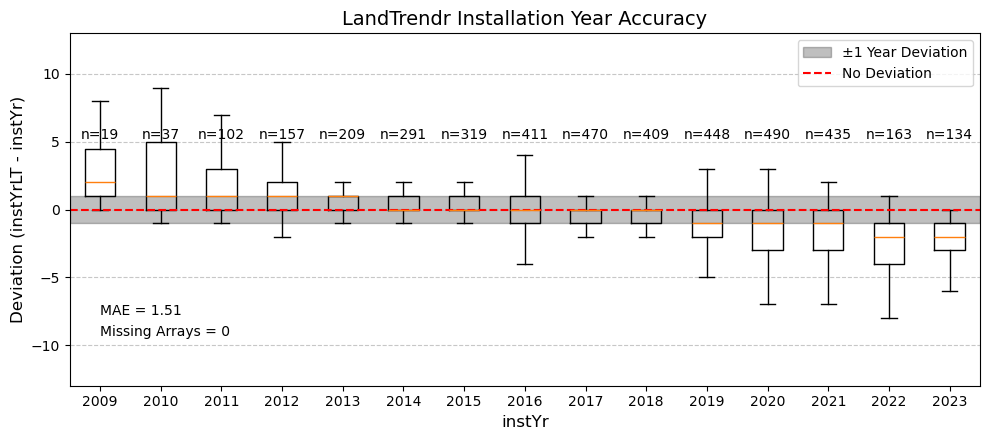

In [38]:
# Call lt_data
lt_data = pd.read_csv(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_LandTrendr.csv'))

# Calculate the deviation
lt_data['deviation'] = lt_data['instYrLT'] - lt_data['instYr']

# Remove any rows where instYrLT is -9999 or instYr is -9999
lt_data_noNull = lt_data[(lt_data['instYrLT'] != -9999) & (lt_data['instYr'] != -9999)]

# Drop rows where Source is anything other than USPVDB
lt_data_noNull = lt_data_noNull[lt_data_noNull['Source'] == 'USPVDB']

# Print the total number of arrays with a newly detected installation year
print('Number of arrays with a newly detected installation year:', lt_data_noNull['deviation'].value_counts().sum())

# Print the mean absolute deviation
print('Mean Absolute Error:', lt_data_noNull['deviation'].abs().mean())

# Create a list of deviation values grouped by instYr and count the number of data points in each group
data = [lt_data_noNull[lt_data_noNull['instYr'] == year]['deviation'] for year in range(2009, 2024)]
counts = [len(group) for group in data]

# Plot the boxplot without showing outliers
plt.figure(figsize=(10, 4.5))
# Add a shaded black (alpha = 0.25) that is plus or minus 1 year from the 0 line
plt.axhspan(-1, 1, color='black', alpha=0.25, label='±1 Year Deviation')

# Create the boxplot
plt.boxplot(data, positions=range(2009, 2024), widths=0.5, showfliers=False)

# Add the count (N) above each box
for i, count in enumerate(counts):
    plt.text(2009 + i, 5, f'n={count}', ha='center', va='bottom', fontsize=10)

# In the lower left corner, add the MAE and the difference between lt_data nrows with instYr and instYrLT values not equal to -9999 and source USPVDB, and the nrows of lt_data_noNull
plt.text(2009, -7, f'MAE = {lt_data_noNull["deviation"].abs().mean():.2f}', ha='left', va='top', fontsize=10)
plt.text(2009, -8.5, f'Missing Arrays = {lt_data[(lt_data['instYr'] != -9999) & (lt_data["Source"] == "USPVDB")].shape[0] - lt_data_noNull.shape[0]}', ha='left', va='top', fontsize=10)

# Set x and y limits
plt.xlim(2008.5, 2023.5)
plt.ylim(-13, 13)

# Add labels, title, and grid
plt.xlabel('instYr', fontsize=12)
plt.ylabel('Deviation (instYrLT - instYr)', fontsize=12)
plt.title('LandTrendr Installation Year Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a 0 line (no deviation)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='No Deviation')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Plot LandTrendr Deviation for All Indices

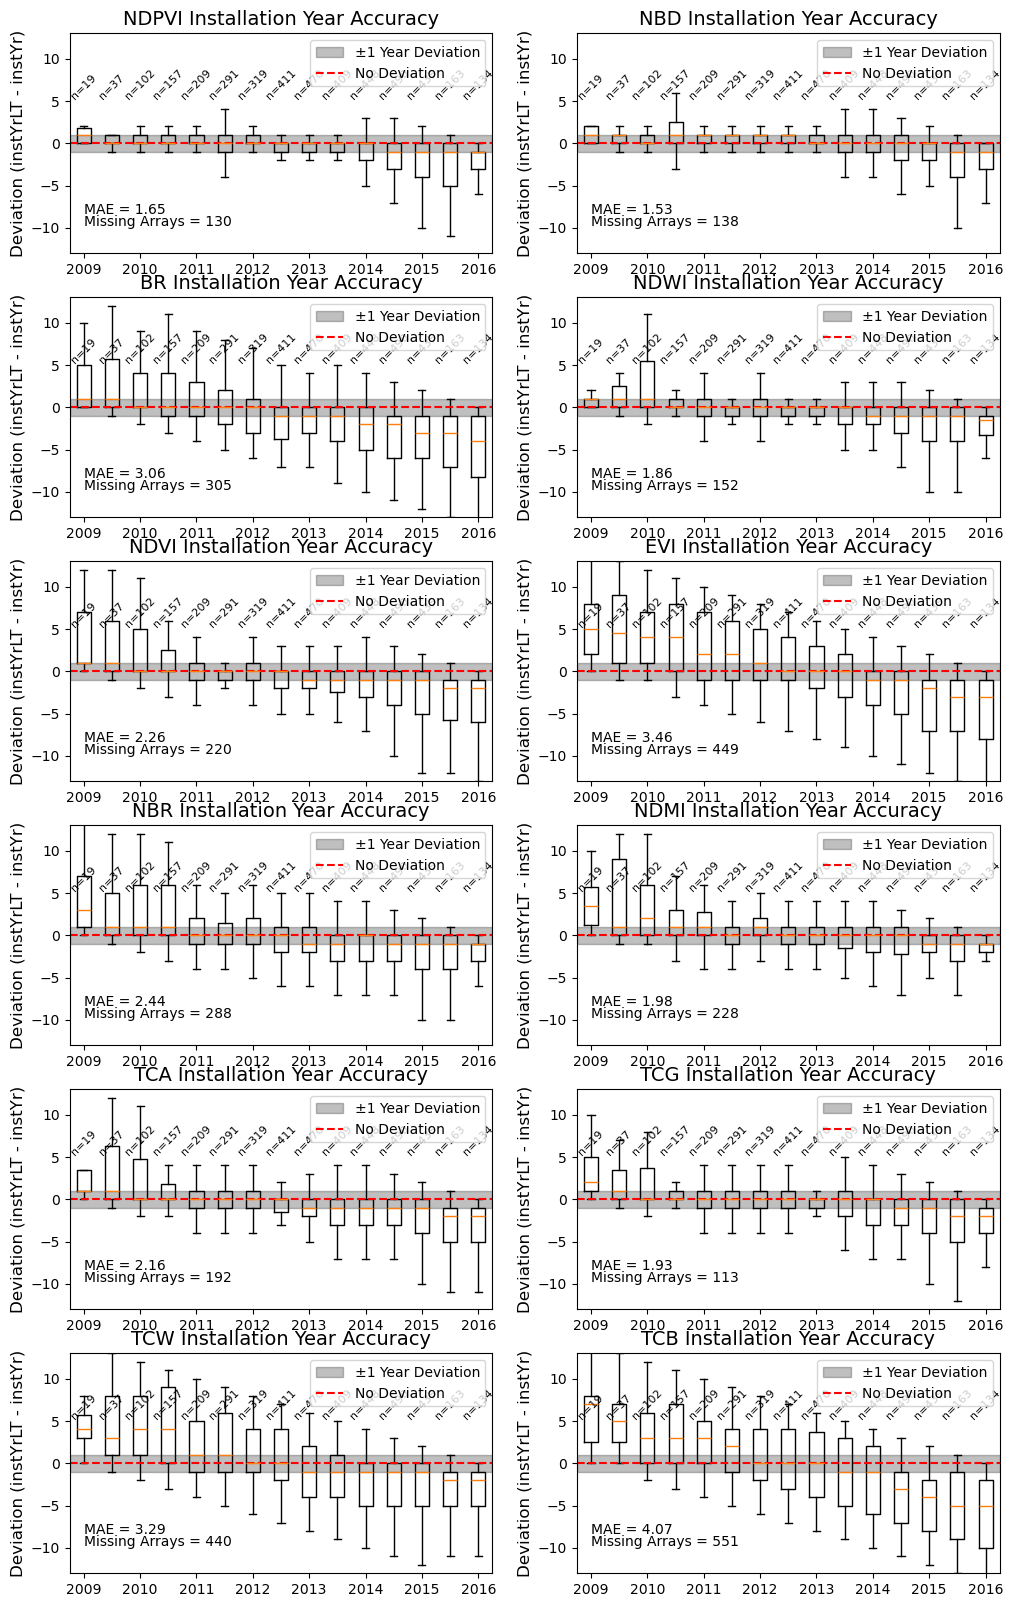

In [39]:
# Create the above graph, but for each index in a 4 row by 2 column grid
fig, axs = plt.subplots(6, 2, figsize=(12, 20))

# Iterate over each index
for i, index in enumerate(indices):
    # Calculate the deviation for the index
    lt_data['deviation'] = lt_data[f'instYrLT_{index}'] - lt_data['instYr']

    # Remove any rows where instYrLT is -9999 or instYr is -9999
    lt_data_noNull = lt_data[(lt_data[f'instYrLT_{index}'] != -9999) & (lt_data['instYr'] != -9999)]

    # Drop rows where Source is anything other than USPVDB
    lt_data_noNull = lt_data_noNull[lt_data_noNull['Source'] == 'USPVDB']

    # Create a list of deviation values grouped by instYr and count the number of data points in each group
    data = [lt_data_noNull[lt_data_noNull['instYr'] == year][f'deviation'] for year in range(2009, 2024)]

    # Plot the boxplot without showing outliers
    axs[i // 2, i % 2].axhspan(-1, 1, color='black', alpha=0.25, label='±1 Year Deviation')
    axs[i // 2, i % 2].boxplot(data, positions=range(2009, 2024), widths=0.5, showfliers=False)

    # Add the count (N) above each box, angle this text to be more readable by rotating it 45 degrees and make
    for j, count in enumerate(counts):
        axs[i // 2, i % 2].text(2009 + j, 5, f'n={count}', ha='center', va='bottom', fontsize=8, rotation=45)

    # In the lower left corner, add the MAE and the difference between lt_data nrows with instYr and instYrLT values not equal to -9999 and source USPVDB, and the nrows of lt_data_noNull
    axs[i // 2, i % 2].text(2009, -7, f'MAE = {lt_data_noNull[f"deviation"].abs().mean():.2f}', ha='left', va='top', fontsize=10)
    axs[i // 2, i % 2].text(2009, -8.5, f'Missing Arrays = {lt_data[(lt_data["instYr"] != -9999) & (lt_data["Source"] == "USPVDB")].shape[0] - lt_data_noNull.shape[0]}', ha='left', va='top', fontsize=10)

    # Set x and y limits, and ensure only every other year is shown on the x-axis
    axs[i // 2, i % 2].set_xlim(2008.5, 2023.5)
    axs[i // 2, i % 2].set_ylim(-13, 13)
    axs[i // 2, i % 2].set_xticks(range(2009, 2024, 2))

    # Add labels, title, and grid
    axs[i // 2, i % 2].set_xlabel('', fontsize=12)
    axs[i // 2, i % 2].set_ylabel('Deviation (instYrLT - instYr)', fontsize=12)
    axs[i // 2, i % 2].set_title(f'{index} Installation Year Accuracy', fontsize=14)

    # Add a 0 line (no deviation)
    axs[i // 2, i % 2].axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='No Deviation')

    # Add a legend
    axs[i // 2, i % 2].legend()

# Export the plot
plt.savefig(os.path.join(figure_path, r'LandTrendr_Installation_Year_Accuracy.png'))

### Assign LandTrendr Installation Year, Fill Gaps in instYr, and Dissolve Exloded Arrays (SAM) by Year and arrayID

In [40]:
# Call gmseusArraysInstYr that has been spatially joined with point data
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_pointChecked.shp'))

# Call LandTrendr data
lt_data = pd.read_csv(lt_data_path)

# TEMP: We exploded all grouped arrays in script5 so that we can merge them based on install year. To rectify this here, order both datasets by arrayID and set a tempID that is 1 through df length
gmseusArraysInstYr = gmseusArraysInstYr.sort_values(by='arrayID').reset_index(drop=True)
gmseusArraysInstYr['tempID'] = np.arange(1, len(gmseusArraysInstYr) + 1)
lt_data = lt_data.sort_values(by='arrayID').reset_index(drop=True)
lt_data['tempID'] = np.arange(1, len(lt_data) + 1)

# Merge the two datasets by arrayID
gmseusArraysInstYr = gmseusArraysInstYr.merge(lt_data[['tempID', 'instYrLT']], on='tempID', how='left')

# Fill NaN values in instYr with -9999
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].fillna(-9999)

# Because CCVPV used a similar but less robust method (one index, and fastest LT), set all instYr values to -9999 for Source = 'CCVPV' to be replaced with instYrLT
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].where(gmseusArraysInstYr['Source'] != 'CCVPV', -9999)

# Where gmseusArraysInstYr['instYr'] is -9999, replace with instYrLT
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].where(gmseusArraysInstYr['instYr'] != -9999, gmseusArraysInstYr['instYrLT'])

# Print the total number of arrays with an installation year
print('Number of arrays with an installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year
print('Number of arrays without an installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999].shape[0])

# Get a temporary df where instYr and instYrLT are not -9999, and print the mean absolute error for all arrays, and those with Source = 'USPVDB'
gmseusArraysInstYr_noNull = gmseusArraysInstYr[(gmseusArraysInstYr['instYrLT'] != -9999) & (gmseusArraysInstYr['instYr'] != -9999)]
print('TEMP Mean Absolute Error ALL chunks:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))
gmseusArraysInstYr_noNull = gmseusArraysInstYr_noNull[gmseusArraysInstYr_noNull['Source'] == 'USPVDB']
print('TEMP Mean Absolute Error USPVDB:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))

# Export the final instYr dataset (custom path)
gmseusArraysInstYr.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_joined.shp'))

Number of arrays with an installation year: 16536
Number of arrays without an installation year: 1
TEMP Mean Absolute Error ALL chunks: 1.9171264019399819
TEMP Mean Absolute Error USPVDB: 1.5100899586676393


# STOP -- MANUALLY VALIDATE MISSING INSTALL YEARS BEFORE PROGRESSING
* If any arrays are missing an installation year, manually validate using script7a and script7b in GEE.
* Upload _GMSEUS_Arrays_instYr_joined.shp_ to GEE asset and run script7a and script7b.
* Then, manually append those years and save as 'GMSEUS_Arrays_instYr_joined.shp'.

In [41]:
# Call gmseusArraysInstYr
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_joined.shp'))

# Print list of arrayID's with instYr = -9999
print('ArrayIDs with instYr = -9999:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999]['arrayID'].unique(), "Don't use this one, use tempID for more precise locating.")

# Print list of tempID's with instYr = -9999
print('tempIDs with instYr = -9999:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999]['tempID'].unique())

ArrayIDs with instYr = -9999: [1878] Don't use this one, use tempID for more precise locating.
tempIDs with instYr = -9999: [2038]


In [42]:
# Call gmseusArraysInstYr that has been spatially joined with point data and LandTrendr data
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_joined.shp'))

# Manually set installation years for arrays from script7a and 7b
gmseusArraysInstYr.loc[gmseusArraysInstYr['tempID'] == 2038, 'instYr'] = 2018

# Print the total number of arrays without an installation year
print('Number of arrays without an installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999].shape[0])

# Export the final instYr dataset (custom path)
gmseusArraysInstYr.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_joinedFinished.shp'))

Number of arrays without an installation year: 0


# Compile a semi-final GM-SEUS Array Dataset Grouped By Installation Year
In `script5`, we exploded array shapes that originally were gropued into possibly erroneous arrays (because of low imagery resolution).\
Here, we will group these back into array shapes only if they share a common installation year (or are small array subsections that recieved a different installation year).\
After assigning final panel-row and array attributes, we will further group by mount and proximity (below)

In [43]:
# Call gmseusArraysInstYr
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_joinedFinished.shp'))

# Print original number of rows
print('Original number of rows:', gmseusArraysInstYr.shape[0])
# Print unique arrayIDs
print('Original Number of unique arrayIDs:', gmseusArraysInstYr['arrayID'].nunique())

# Get gmseusArraysInstYr that have unique arrayIDs and that have duplicate arrayIDs
gmseusArraysInstYrUnique = gmseusArraysInstYr[gmseusArraysInstYr['arrayID'].duplicated(keep=False) == False]
gmseusArraysInstYrDuplicate = gmseusArraysInstYr[gmseusArraysInstYr['arrayID'].duplicated(keep=False) == True]
# Split into unique and duplicate arrays based on arrayID
gmseusArraysInstYrUnique = gmseusArraysInstYr[~gmseusArraysInstYr['arrayID'].duplicated(keep=False)]
gmseusArraysInstYrDuplicate = gmseusArraysInstYr[gmseusArraysInstYr['arrayID'].duplicated(keep=False)]

# Create a new list to store processed duplicates
processed_duplicates = []

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ For arrays with the same arrayID, group same instYr arrays and merge small arrays with nearest arrays

# WITHIN ARRAY ID: Process only duplicate arrays 
for arrayID in gmseusArraysInstYrDuplicate['arrayID'].unique():
    # Filter the rows for the current arrayID
    arrays = gmseusArraysInstYrDuplicate[gmseusArraysInstYrDuplicate['arrayID'] == arrayID]

    # Group by common instYr and set all other columns to their first value
    arrays = arrays.dissolve(by='instYr', aggfunc='first').reset_index()

    # Set a tempID to track individual rows
    arrays['tempID'] = np.arange(1, len(arrays) + 1)

    # Iterate through each array row
    for array in arrays.itertuples():
        # Get the area of the array
        area = array.geometry.area

        # If the area is below the minimum threshold
        if area < minPanelRowArea * minNumPanelRows:
            # Get other arrays to consider for merging
            other_arrays = arrays[arrays['tempID'] != array.tempID]

            if not other_arrays.empty:
                # Find the nearest array geometry
                nearest_geom = nearest_points(array.geometry, other_arrays.unary_union)[1]
                nearest_array = other_arrays[other_arrays.geometry == nearest_geom]

                if not nearest_array.empty:
                    # Merge the small array with the nearest array
                    merged_geometry = nearest_geom.union(array.geometry)

                    # Update the geometry of the nearest array
                    arrays.loc[arrays['geometry'] == nearest_geom, 'geometry'] = merged_geometry

                    # Drop the small array
                    arrays = arrays[arrays['tempID'] != array.tempID]
        
        # If the area is less than 10% of the area of all subarray chunks with the same arrayID, drop the row
        if area < 0.1 * arrays['geometry'].area.sum():
            arrays = arrays[arrays['tempID'] != array.tempID]

    # Append processed arrays to the results
    processed_duplicates.append(arrays)

# Combine processed duplicates into a single GeoDataFrame
processed_duplicates = gpd.GeoDataFrame(pd.concat(processed_duplicates, ignore_index=True))

# Combine processed duplicates with unique arrays into the final result
gmseusArraysFinal = gpd.GeoDataFrame(pd.concat([gmseusArraysInstYrUnique, processed_duplicates], ignore_index=True))

# Export arrays that still have duplicate arrayIDs
#gmseusArraysFinalDuplicate = gmseusArraysFinal[gmseusArraysFinal['arrayID'].duplicated(keep=False)]
#gmseusArraysFinalDuplicate.to_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_newlySplitArrayIDs.shp'))

# Add a new arrayID column that is 1 through the length of the dataset
gmseusArraysFinal['arrayID'] = np.arange(1, len(gmseusArraysFinal) + 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Remove eroneous array chunks (less than minPanelRowArea * minNumPanelRows and less than 1% of the area of all subarray chunks with the same arrayID IF Source is not USPVDB or GMSEUSgeorect)

# Set a tempArea column to store the area of each geometry
gmseusArraysFinal['tempArea'] = gmseusArraysFinal['geometry'].area

# Explode arrays
gmseusArraysFinalExploded = gmseusArraysFinal.explode(index_parts=False)

# Print the number of chunks that the area is less than (minPanelRowArea * minNumPanelRows)
print('Number of chunks with area less than minimum array area:', gmseusArraysFinalExploded[gmseusArraysFinalExploded['geometry'].area < minPanelRowArea * minNumPanelRows].shape[0])

# Drop subarray chunks are less than the minimumn array area (minPanelRowArea * minNumPanelRows)
gmseusArraysFinalExploded = gmseusArraysFinalExploded[gmseusArraysFinalExploded['geometry'].area >= minPanelRowArea * minNumPanelRows]

# In most cases (outside USPVDB hand delineation panel-rows and the space between them), 1% of the total array area is either comissions or a a rogue panel-row in an underclassified array. For best-quality results, remove these chunks

# Get chunks that are less than 1% of the total array area AND Source is not USPVDB or GMSEUSgeorect (because those still may be USPVDB)
gmseusArraysFinalExploded_onePerc = gmseusArraysFinalExploded[(gmseusArraysFinalExploded['geometry'].area < 0.01 * gmseusArraysFinalExploded['tempArea']) & (gmseusArraysFinalExploded['Source'] != 'USPVDB') & (gmseusArraysFinalExploded['Source'] != 'GMSEUSgeorect')]

# Print the number of chunks that the chunk area is less than 1% of the tempArea for that row AND Source is not USPVDB
print('Number of chunks with area less than 1% of the total array area:', gmseusArraysFinalExploded_onePerc.shape[0])

# Export chunks that are less than 1% of the total array area AND Source is not USPVDB
gmseusArraysFinalExploded_onePerc.to_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_QAQClessThan1PercArea.shp'))

# Drop subarray chunks that are less than 1% of the total array area AND Source is not USPVDB or GMSEUSgeorect
gmseusArraysFinalExploded = gmseusArraysFinalExploded[(gmseusArraysFinalExploded['geometry'].area >= 0.01 * gmseusArraysFinalExploded['tempArea']) | (gmseusArraysFinalExploded['Source'] == 'USPVDB') | (gmseusArraysFinalExploded['Source'] == 'GMSEUSgeorect')]

# Drop the tempArea column
gmseusArraysFinalExploded = gmseusArraysFinalExploded.drop(columns='tempArea', errors='ignore')
                                                                                                                                                           
# Dissolve the arrays back to the original format
gmseusArraysFinal = gmseusArraysFinalExploded.dissolve(by='arrayID', as_index=False).reset_index(drop=True)

# #Avoid this step for now, preference input dataset grouping over proximity and installation year
# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ For arrays with Source not equal to USPVDB, group by proximty and instYr
# # OUTSIDE ARRAY ID: Process only unique arrays -- merge near arrays
# # Get original length of gmseusArraysFinal
# preGroupLen = len(gmseusArraysFinal)
# # Get arrays with USPVDB as the source and without
# gmseusArraysFinalKeep = gmseusArraysFinal[(gmseusArraysFinal['Source'] == 'USPVDB')]#  | (gmseusArraysFinal['Source'] == 'OSM')]
# gmseusArraysFinalCheck = gmseusArraysFinal[(gmseusArraysFinal['Source'] != 'USPVDB')] # & (gmseusArraysFinal['Source'] != 'OSM')]
# # If any arrayFromPanelData shape is within a 10m buffer (arrayArrayBuff) of another arrayFromPanelData, merge them into a single array shape
# gmseusArraysFinalCheck = groupArrayByVariableAndProximity(gmseusArraysFinalCheck, arrayArrayBuff, 'instYr')
# # Combine the two datasets
# gmseusArraysFinal = pd.concat([gmseusArraysFinalKeep, gmseusArraysFinalCheck])
# # Get the number of arrays after grouping by proximity
# postGroupLen = len(gmseusArraysFinal)
# # Print the number of arrays that were grouped by proximity
# print('Number of arrays grouped by proximity:', preGroupLen - postGroupLen)
# # Reassign arrayID column that is 1 through the length of the dataset
# gmseusArraysFinal['arrayID'] = np.arange(1, len(gmseusArraysFinal) + 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Final printing and export

# Drop arrayID column if it exists, and reassign arrayID and tempID column that is 1 through the length of the dataset
gmseusArraysFinal = gmseusArraysFinal.reset_index(drop=True)
gmseusArraysFinal = gmseusArraysFinal.drop(columns=['arrayID', 'tempID'], errors='ignore')
gmseusArraysFinal['arrayID'] = np.arange(1, len(gmseusArraysFinal) + 1)

# Add a new total array area column as integer
gmseusArraysFinal['totArea'] = gmseusArraysFinal['geometry'].area.astype(int)

# Print final results
print('Final number of arrays:', gmseusArraysFinal.shape[0])

# Get a temporary df where instYr and instYrLT are not -9999, and print the mean absolute error for all arrays, and those with Source = 'USPVDB'
gmseusArraysInstYr_noNull = gmseusArraysFinal[(gmseusArraysFinal['instYrLT'] != -9999) & (gmseusArraysFinal['instYr'] != -9999)]
print('Mean Absolute Error ALL:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))
gmseusArraysInstYr_noNull = gmseusArraysInstYr_noNull[gmseusArraysInstYr_noNull['Source'] == 'USPVDB']
print('Mean Absolute Error USPVDB:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))

# Export the final instYr filled dataset (custom path)
gmseusArraysFinal.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_filled.shp'))

Original number of rows: 16537
Original Number of unique arrayIDs: 14875
Number of chunks with area less than minimum array area: 388
Number of chunks with area less than 1% of the total array area: 613
Final number of arrays: 15019
Mean Absolute Error ALL: 1.8824667957017953
Mean Absolute Error USPVDB: 1.5100899586676393


# Final Panel-Row Attributes for Rows and Array Averages and Sums
This includes final arrayID, pnlArea, rowWidth, rowLength, rowAzimuth, rowMount, and rowSpace.\
Here, we will also remove panel-rows associated with less thasn 1% by area sub-array chunks.

### Assign Final Panel-Row Attributes to Panel-Rows
Ensure calculation of row spacing is turned on (we turned this off often for method development given it is an intensive process)

In [44]:
# # Call gmseus panels
# #gmseusPanels = gpd.read_file(gmseusPanelsCombinedPath)
# gmseusPanels = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_CombinedChecked.shp'))

# # Print the number of rows in gmseusPanels
# print('DUPLICATE CHECK 1', gmseusPanels.shape[0])

# # Print number of panels with duplicate panelID
# print('Number of panels with duplicate panelID:', gmseusPanels[gmseusPanels['panelID'].duplicated(keep=False)].shape[0])

# # Call in gmseus arrays with installation year
# gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_filled.shp'))

# # Call new QAQC conditional gdf ('GMSEUS_Arrays_QAQClessThan1PercArea.shp') -- 3rd iteration of QAQC (first two are in script5)
# gmseusArraysQAQC_3 = gpd.read_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_QAQClessThan1PercArea.shp'))

# # ~~~~~~~~~~ Assign final attributes

# # If gmseusPanels already contains the arrayID, mount, azimuth, length, width, area, or rowSpace columns, drop them. Drop their updated names if they exist as well
# gmseusPanels = gmseusPanels.drop(columns=['arrayID', 'mount', 'azimuth', 'longEdge', 'shortEdge', 'area', 'rowSpace'], errors='ignore')
# gmseusPanels = gmseusPanels.drop(columns=['rowMount', 'rowAzimuth', 'rowLength', 'rowWidth', 'rowArea'], errors='ignore')

# # Set the rowArea column to the area of the panel
# gmseusPanels['rowArea'] = gmseusPanels['geometry'].area

# # Spatially join gmseus arrays to panels, copy the arrayID to the panels, and drop the index columns. 
# gmseusPanels = gpd.sjoin(gmseusPanels, gmseusArrays[['arrayID', 'geometry']], how='left', predicate='intersects')
# gmseusPanels  = gmseusPanels.reset_index(drop=True)
# gmseusPanels  = gmseusPanels.drop(columns=['index_left', 'index_right'], errors='ignore')

# # Print the number of rows in gmseusPanels
# print('DUPLICATE CHECK 1:', gmseusPanels.shape[0])

# # Print number of panels with duplicate panelID
# print('Number of panels with duplicate panelID:', gmseusPanels[gmseusPanels['panelID'].duplicated(keep=False)].shape[0])

In [45]:
# This cell requires 600+  minutes (~10 hours) to run. 

# Call gmseus panels
#gmseusPanels = gpd.read_file(gmseusPanelsCombinedPath)
gmseusPanels = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_CombinedChecked.shp'))

# Call in gmseus arrays with installation year
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_filled.shp'))

# Call new QAQC conditional gdf ('GMSEUS_Arrays_QAQClessThan1PercArea.shp') -- 3rd iteration of QAQC (first two are in script5)
gmseusArraysQAQC_3 = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_QAQClessThan1PercArea.shp'))

# ~~~~~~~~~~ Assign final attributes

# If gmseusPanels already contains the arrayID, mount, azimuth, length, width, area, or rowSpace columns, drop them. Drop their updated names if they exist as well
gmseusPanels = gmseusPanels.drop(columns=['arrayID', 'mount', 'azimuth', 'longEdge', 'shortEdge', 'area', 'rowSpace'], errors='ignore')
gmseusPanels = gmseusPanels.drop(columns=['rowMount', 'rowAzimuth', 'rowLength', 'rowWidth', 'rowArea'], errors='ignore')

# Set the rowArea column to the area of the panel
gmseusPanels['rowArea'] = gmseusPanels['geometry'].area

# Print the number of rows in gmseusPanels
print('DUPLICATE CHECK 1: Pre-Array Join - ', gmseusPanels.shape[0])

# Spatially join gmseus arrays to panels, copy the arrayID to the panels, and drop the index columns. 
gmseusPanels = gpd.sjoin(gmseusPanels, gmseusArrays[['arrayID', 'geometry']], how='left', predicate='intersects')
gmseusPanels  = gmseusPanels.reset_index(drop=True)
gmseusPanels  = gmseusPanels.drop(columns=['index_left', 'index_right'], errors='ignore')

# Print the number of rows in gmseusPanels
print('DUPLICATE CHECK 2: Post-Array Join - ', gmseusPanels.shape[0])

# Get panel-row mount, azimuth, length, and width attributes from assignMountType function
gmseusPanels[['mount', 'azimuth', 'lengthRatio', 'shortEdge', 'longEdge']] = gmseusPanels.apply(assignMountType, axis=1, result_type='expand')

# Rename azimuth to rowAzimuth, shortEdge to rowWidth, longEdge to rowLength, and mount to rowMount
gmseusPanels = gmseusPanels.rename(columns={'azimuth': 'rowAzimuth', 'shortEdge': 'rowWidth', 'longEdge': 'rowLength', 'mount': 'rowMount'})

# Drop lengthRatio
gmseusPanels = gmseusPanels.drop(columns=['lengthRatio'], errors='ignore')

# Get the inter-row spacing for each panel in the azimuthal direction (or any direction for dual-axis trackers)
gmseusPanels = calculateRowSpacing(gmseusPanels) #gmseusPanels['rowSpace'] = 3
gmseusPanels = gmseusPanels.reset_index(drop=True)

# Round rowAzimuth, rowWidth, rowLength, rowArea, and rowSpace to 2 decimal places
gmseusPanels['rowAzimuth'] = gmseusPanels['rowAzimuth'].round(2)
gmseusPanels['rowWidth'] = gmseusPanels['rowWidth'].round(2)
gmseusPanels['rowLength'] = gmseusPanels['rowLength'].round(2)
gmseusPanels['rowArea'] = gmseusPanels['rowArea'].round(2)
gmseusPanels['rowSpace'] = gmseusPanels['rowSpace'].round(2)

# Where rowAzimuth, rowWidth, rowLength, rowArea, or rowSpace is 0 or NaN, set to -9999
gmseusPanels['rowAzimuth'] = gmseusPanels['rowAzimuth'].fillna(-9999)
gmseusPanels['rowWidth'] = gmseusPanels['rowWidth'].fillna(-9999)
gmseusPanels['rowLength'] = gmseusPanels['rowLength'].fillna(-9999)
gmseusPanels['rowArea'] = gmseusPanels['rowArea'].fillna(-9999)
gmseusPanels['rowSpace'] = gmseusPanels['rowSpace'].fillna(-9999)
gmseusPanels['rowAzimuth'] = gmseusPanels['rowAzimuth'].replace(0, -9999)
gmseusPanels['rowWidth'] = gmseusPanels['rowWidth'].replace(0, -9999)
gmseusPanels['rowLength'] = gmseusPanels['rowLength'].replace(0, -9999)
gmseusPanels['rowArea'] = gmseusPanels['rowArea'].replace(0, -9999)
gmseusPanels['rowSpace'] = gmseusPanels['rowSpace'].replace(0, -9999)

# Save panel-rows incase of error in next chunk (and because spacing function is slow)
gmseusPanels.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wSpacing.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Remove panel-rows from arrays that that are less than 1% of the total array area

# Drop arrayID column: We reset arrayID's since the generation of QAQC3, thus, we will reattache them from gmseusArrays
gmseusArraysQAQC_3 = gmseusArraysQAQC_3.drop(columns='arrayID', errors='ignore').reset_index(drop=True)
gmseusArraysQAQC_3 = gpd.sjoin(gmseusArraysQAQC_3, gmseusArrays[['geometry', 'arrayID']], how='left', predicate='intersects')

# Break gmseusPanels into two parts: one with arrays that have been QAQCed and one without
gmseusPanelsQAQC_check = gmseusPanels[gmseusPanels['arrayID'].isin(gmseusArraysQAQC_3['arrayID'])].reset_index(drop=True)
gmseusPanelsQAQC_noCheck = gmseusPanels[~gmseusPanels['arrayID'].isin(gmseusArraysQAQC_3['arrayID'])].reset_index(drop=True)

# Print number of rows in gmseusPanelsQAQC_check
print('Number of rows with potential low-array area coverage (<1%):', gmseusPanelsQAQC_check.shape[0])

# If gmseusPanelsQAQC_check intersects with gmseusArraysQAQC_3, drop the row
gmseusArraysQAQC_3['QAQC3'] = 1
gmseusPanelsQAQC_check = gpd.sjoin(gmseusPanelsQAQC_check, gmseusArraysQAQC_3[['geometry', 'QAQC3']], how='left', predicate='intersects')
gmseusPanelsQAQC_check['QAQC3'] = gmseusPanelsQAQC_check['QAQC3'].fillna(0) # Fill NaN values with 0
gmseusPanelsQAQC_check = gmseusPanelsQAQC_check[gmseusPanelsQAQC_check['QAQC3'] != 1].reset_index(drop=True)

# Drop index columns and QAQC3
gmseusPanelsQAQC_check = gmseusPanelsQAQC_check.drop(columns=['index_left', 'index_right', 'QAQC3'], errors='ignore')

# Print number of rows in gmseusPanelsQAQC_check
print('Number of rows remaining after removal of low-array area coverage (<1%):', gmseusPanelsQAQC_check.shape[0])

# Print original number of rows
print('Original number of rows:', gmseusPanels.shape[0])
originalPanelsNum = gmseusPanels.shape[0]

# Combine gmseusPanelsQAQC_check and gmseusPanelsQAQC_noCheck
gmseusPanels = pd.concat([gmseusPanelsQAQC_check, gmseusPanelsQAQC_noCheck], ignore_index=True)

# Print the final number of rows
print('Final number of rows:', gmseusPanels.shape[0])
finalPanelsNum = gmseusPanels.shape[0]

# Print the number of rows removed
print('Number of rows removed:', originalPanelsNum - finalPanelsNum)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export final panel-rows

# Export the final dataset
gmseusPanels.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wAttributes.shp'))

DUPLICATE CHECK 1: Pre-Array Join -  2921824
DUPLICATE CHECK 2: Post-Array Join -  2923013
904.0 of 9043 (10%) in progress
1356.0 of 9043 (15%) in progress
1808.0 of 9043 (20%) in progress
3616.0 of 9043 (40%) in progress
4520.0 of 9043 (50%) in progress
5876.0 of 9043 (65%) in progress
6780.0 of 9043 (75%) in progress
9040.0 of 9043 (100%) in progress
9492.0 of 9043 (105%) in progress
9944.0 of 9043 (110%) in progress
10396.0 of 9043 (115%) in progress
11300.0 of 9043 (125%) in progress
12656.0 of 9043 (140%) in progress
13108.0 of 9043 (145%) in progress
14012.0 of 9043 (155%) in progress
14464.0 of 9043 (160%) in progress
14916.0 of 9043 (165%) in progress
Number of rows with potential low-array area coverage (<1%): 6402
Number of rows remaining after removal of low-array area coverage (<1%): 2360
Original number of rows: 2923013
Final number of rows: 2918971
Number of rows removed: 4042


### Assign Final Panel-Row Attributes to Arrays

In [46]:
# Recall gmseusPanels and gmseusArrays
gmseusPanels = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wAttributes.shp'))
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_filled.shp')) 

# If any of these columns already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['numRow', 'totRowArea', 'avgLength', 'avgWidth', 'avgSpace', 'mount', 'avgAzimuth'], errors='ignore')

# Get rowNum, totRowArea, lengthAvg, widthAvg, and spaceAvg for each array from gmseusPanels (ensure to remove any rows with -9999 values)
numRows = gmseusPanels.groupby('arrayID').size().reset_index(name='numRow')
totRowAreas = gmseusPanels[gmseusPanels['rowArea'] != -9999].groupby('arrayID')['rowArea'].sum().reset_index(name='totRowArea')
avgLengths = gmseusPanels[gmseusPanels['rowLength'] != -9999].groupby('arrayID')['rowLength'].mean().reset_index(name='avgLength')
avgWidths = gmseusPanels[gmseusPanels['rowWidth'] != -9999].groupby('arrayID')['rowWidth'].mean().reset_index(name='avgWidth')
avgSpaces = gmseusPanels[gmseusPanels['rowSpace'] != -9999].groupby('arrayID')['rowSpace'].mean().reset_index(name='avgSpace')

# Merge gmsesuArrays with the new columns by arrayID
gmseusArrays = gmseusArrays.merge(numRows[['arrayID', 'numRow']], on='arrayID', how='left')
gmseusArrays = gmseusArrays.merge(totRowAreas[['arrayID', 'totRowArea']], on='arrayID', how='left')
gmseusArrays = gmseusArrays.merge(avgLengths[['arrayID', 'avgLength']], on='arrayID', how='left') 
gmseusArrays = gmseusArrays.merge(avgWidths[['arrayID', 'avgWidth']], on='arrayID', how='left')
gmseusArrays = gmseusArrays.merge(avgSpaces[['arrayID', 'avgSpace']], on='arrayID', how='left')

# Mount and azimuthAvg have to be treated differently. 
# For mount, gmseusPanels grouped by arrayID could contain any or all of these classes: 'fixed_axis', 'single_axis', or 'dual_axis'.
# If the array contains more than 90% one class, set mount as that majority class. Otherwise, set mount as 'mixed_' + a letter combination of the classes (e.g., mixed_fs for fixed_axis and single_axis, or mixed_fsd for all three mount types).
mounts = gmseusPanels.groupby('arrayID')['rowMount'].apply(getArrayMount, include_groups = False).reset_index(name='mount')
gmseusArrays = gmseusArrays.merge(mounts[['arrayID', 'mount']], on='arrayID', how='left')

# For azimuth, fixed- and dual-axis arrays have an avgAzimuth of the median of rowAzimuth. Single-axis arrays have an avgAzimuth of the median of rowAzimuth IF rowAzimuth is  + 90 degrees. Mixed arrays should be ignored, but have an avearge azimuth of the median of rowAzimuth.
azimuths = gmseusPanels.groupby('arrayID').apply(getArrayAzimuth, include_groups = False).reset_index(name='avgAzimuth')
gmseusArrays = gmseusArrays.merge(azimuths[['arrayID', 'avgAzimuth']], on='arrayID', how='left')

# Change the cap_mw column name to capMW
gmseusArrays = gmseusArrays.rename(columns={'cap_mw': 'capMW'})

# Fill NaN values in numeric columns with -9999, and in string columns with 'unknown'
gmseusArrays['numRow'] = gmseusArrays['numRow'].fillna(0) # Special case for numRow
gmseusArrays['totRowArea'] = gmseusArrays['totRowArea'].fillna(-9999)
gmseusArrays['avgLength'] = gmseusArrays['avgLength'].fillna(-9999)
gmseusArrays['avgWidth'] = gmseusArrays['avgWidth'].fillna(-9999)
gmseusArrays['avgSpace'] = gmseusArrays['avgSpace'].fillna(-9999)
gmseusArrays['avgAzimuth'] = gmseusArrays['avgAzimuth'].fillna(-9999)
gmseusArrays['mount'] = gmseusArrays['mount'].fillna('unknown')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare and Export final arrays and panel-rows

# IMPORTANT: Where panel-rows overlap more than one array, we end up with duplicate rows. We will drop these duplicates in the final dataset.
# Doing this after we attribute them to arrays allows us to use the most information for each array.
# Drop duplicate panels using in panelID
print('Number of rows before dropping duplicates:', gmseusPanels.shape[0])
gmseusPanels = gmseusPanels.drop_duplicates(subset=['panelID'], keep='first')
print('Number of rows after dropping duplicates:', gmseusPanels.shape[0])

# Drop panelID column, and reassign panelID as 1 through the length of the dataset
gmseusPanels = gmseusPanels.drop(columns='panelID', errors='ignore')
gmseusPanels['panelID'] = np.arange(1, len(gmseusPanels) + 1)

# Export the final rowAttribute dataset (custom path)
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_rowAttributes.shp'))
gmseusPanels.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wAttributesNewPanelID.shp'))

f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\Python_Envs\B

Number of rows before dropping duplicates: 2918971
Number of rows after dropping duplicates: 2917782


# Check Existing Datasets for Remaining Desired Array Attributes
These code chunks check existing solar databases for high-quality metadata. The order of preference for each attribute is distinct based on the percieved quality of the derivation or acquistion method of that attribute.\
We also create a pointData gdf to check against for metadata with nativeID, because we georectify some arrays manually (at a greater distance than the buffer distance), so the only pathway to check georectified metadata sources is by nativeID and the pointData gdf exclusively (thus, this step is required).\
Because this is such a custom process, it is difficult to automate. Ideally, in future iterations, this will be a simpler process. For now, we have to comb through each dataset, in the order of qualtiy-preference, then attach relevant metadata to the gmseusArrays geodataframe.\

Things to check: 
* Source priority method: Not necessary since we spatially remove data in the order of preference. Remove in new version.

Notes:
* *Already converted* indicates that this attribute has already been acquired, renamed and QA/QC'ed to match the schema, and saved in our preprocessing in `script1`.
* Due to manual digitization and other processing operations, we re-attach all attributes *here* in case any were forgone in processing since `script1`. 
* Dataset attribute contributions are ordered by percieved quality, and thus attribution ranking to the final GM-SEUS dataset.
* CWSD is not included here since the only contributed attribute is installation year (merged in prior code chunks)
* We do not include attributes from all datasets for quality control purposes, even if there are no high-quality dataset attribution. We do this because unless the metadata source was derived from perimt data or high-quality sub-array metadata extraction, we assume our methods used here are more accurate. 
    * Some datasets have extensive methods for certain attributes (e.g., GEM GSPT derivation of capacity is array by array intensive investiation of web sources), despite not having all permit level data. We denote dataset attributes that exist but that we do not use by <span style="background-color: #FF2800">*color*</span> and explain in line.

**Installed Capacity**
* USPVDB: `p_cap_dc` & `p_cap_ac` (already converted in uspvdb_poly.shp) -- DC & AC (we will use DC here)
* InSPIRE: `System Size` (already converted in inspire_point.shp) -- DC
* LBNL-USS: `Solar Capacity MW-DC` (already converted in lbnlUss_point.shp) -- DC
* SolarPaces: `Capacity_MW` (already converted in solarPaces_point.shp) -- e or electric, synonomus to AC?
* PV-DAQ: `system_size` (already converted in pvdaq_point.shp) -- DC
* GSPT: `Capacity (MW)` (already converted in gspt_point.shp) -- DC? (unceratin)
* GPPDB: `capacity_mw` (already converted in gppdb_point.shp) -- DC? (uncertain)
* <span style="background-color: #FF2800">*CCVPV*</span>: `TPVPp` (already converted in ccvpv_poly.shp) -- DC -- Derived by lower-fidelity installation year analysis, this product will be more robust
* <span style="background-color: #FF2800">*SAM*</span>: `capacity_mw` (already converted in sam_poly.shp) -- AC -- Derived by course Regional GCR and inverter loading ratio (ILR) and for often erronouesly large array areas (due to coarse imagery)
* <span style="background-color: #FF2800">*OSM*</span>: `plant:output:electricity` (already converted in osm_poly.shp) -- DC (defined as: *peak rated output capacity*) -- crowd sourced information with unclear accuracy of reporting (concerns between AC/DC, original vs expanded capacity, etc.)

**Module Type** 
* SolarPaces: inherent in the dataset -- CSP (already converted in solarPaces_point.shp) -- This takes precedent for csp arrays
* USPVDB: `p_tech_sec` (already converted in uspvdb_poly.shp)
* LBNL-USS: `Solar Tech Sub` (already converted in lbnlUss_point.shp)
* GSPT: `Technology Type` -- only PV or Thermal delineation

**Mount Technology**
* USPVDB: `p_axis` (already converted in uspvdb_poly.shp)
* InSPIRE: `Type Of Array` (already converted in inspire_point.shp)
* LBNL-USS: `Tracking Type` (already converted in lbnlUss_point.shp)
* CCVPV: `Class` (already converted in ccvpv_poly.shp)
* SolarPaces: assumed from `Technology` (already converted in solarPaces_point.shp)

**Azimuth**
* USPVDB: `p_azimuth` (already converted in uspvdb_poly.shp)
* LBNL-USS: `Azimuth` (already converted in lbnlUss_point.shp)
* <span style="background-color: #FF2800">*OSM*</span>: `generator:orientation` (we have not yet acquired this from OSM, need to update `script0`) -- Have not pulled this information from OSM yet, but there remains concern over quality of crowd sourced information when attribute is not clearly explained

**Module Tilt**
* USPVDB: `p_tilt`
* <span style="background-color: #FF2800">*CCVPV*</span>: `Bopt` -- same method used here

**Ground Cover Ratio**
* <span style="background-color: #FF2800">*CCVPV*</span>: `PF` -- Same methods used here, we either use CCVPV panels or are updating panels with potentially new GCR. 

**Module Efficiency**
* <span style="background-color: #FF2800">*None*</span>

**Agrivoltaic Type** -- Not including for initial release
* <span style="background-color: #FF2800">*InSPIRE*</span>: `Habitat Type` (already converted in inspire_point.shp)
* <span style="background-color: #FF2800">*USPVDB*</span>: `AVtype` (alreday converted in uspvdb_poly.shp) -- Derived from InSPIRE

In [47]:
# Call all processed datasets ONCE
uspvdb = gpd.read_file(uspvdb_path)
ccvpv = gpd.read_file(ccvpv_path)
sam = gpd.read_file(sam_path)
osm = gpd.read_file(osm_path)
inspire = gpd.read_file(inspire_path)
lbnlUss = gpd.read_file(lbnlUss_path)
pvdaq = gpd.read_file(pvdaq_path)
solarPaces = gpd.read_file(solarPaces_path)
gspt = gpd.read_file(gspt_path)
gppdb = gpd.read_file(gppdb_path)

## Check Installed Capacity
Order: USPVDB, InSPIRE, LBNL-USS, SolarPACES, PV-DAQ, GSPT, GPPDB

**NOTE**: In regard to checked attributes, capacity is the only one in which it is important not to replicate values, given that capacity is additive. If we have broken an array into two subarray chunks and in some cases two distinct arrays (and arrayID's), we cannot assign a singlular larger shapes capacity value to both shapes (2.4 MW array --> 2.4 MW + 2.4 MW arrays). Thus, in cases where checkID is repeated (match_unique_dup), we distribute reported capacity by _totArea_. This does not matter for other attributes (modType, mount, azimuth, tilt). 

In [48]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_rowAttributes.shp'))

# If Source is CCVPV, SAM, or OSM, set capMW to -9999
gmseusArrays.loc[gmseusArrays['Source'].isin(['CCVPV', 'SAM', 'OSM']), 'capMW'] = -9999

# Ensure fill capMW NaN values with -9999
gmseusArrays['capMW'] = gmseusArrays['capMW'].fillna(-9999)

# Select gmseus arrays where capMW is -9999
gmseusArrays_noCap = gmseusArrays[gmseusArrays['capMW'] == -9999]
gmseusArrays_noCap = gmseusArrays_noCap.reset_index(drop=True)

# Print the total number of arrays with a capacity
print('Number of arrays with a capacity:', gmseusArrays.shape[0] - gmseusArrays_noCap.shape[0])

# Print the total number of arrays without an capacity
print('Number of arrays without a capacity:', gmseusArrays_noCap.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get array data with capacity

# Filter where cap_mw is greater than zero
uspvdb_cap = uspvdb[uspvdb['cap_mw'] > 0]

# Merge into single dataset (only USPVDB)
polyData = uspvdb_cap # pd.concat([uspvdb_cap], ignore_index=True)
polyData = polyData.rename(columns={'cap_mw': 'capMW'})

# Print the number of arrays with cap after filtering
print('Number of array polygons with a capacity:', polyData.shape[0]) # the difference in this number and the above number is due to georectified arrays

# Get unique polygon data with capacity 
uspvdb_unique = uspvdb_cap

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get point data with capacity

# Filter where cap_mw is greater than zero
inspire_cap = inspire[inspire['cap_mw'] > 0]
lbnlUss_cap = lbnlUss[lbnlUss['cap_mw'] > 0]
solarPaces_cap = solarPaces[solarPaces['cap_mw'] > 0]
pvdaq_cap = pvdaq[pvdaq['cap_mw'] > 0]
gspt_cap = gspt[gspt['cap_mw'] > 0]
gppdb_cap = gppdb[gppdb['cap_mw'] > 0]

# Merge into single dataset
pointData = pd.concat([inspire_cap, lbnlUss_cap, solarPaces_cap, pvdaq_cap, gspt_cap, gppdb_cap], ignore_index=True)
pointData = pointData.rename(columns={'cap_mw': 'capMW'})

# Print the number of arrays with cap after filtering
print('Number of array points with a capacity:', pointData.shape[0])

# Buffer the point data by 190 meters (overlapDist) account for potential misalignment of point data
inspire_buffer = inspire_cap.copy()
inspire_buffer['geometry'] = inspire_buffer['geometry'].buffer(overlapDist)
lbnlUss_buffer = lbnlUss_cap.copy()
lbnlUss_buffer['geometry'] = lbnlUss_buffer['geometry'].buffer(overlapDist)
solarPaces_buffer = solarPaces_cap.copy()
solarPaces_buffer['geometry'] = solarPaces_buffer['geometry'].buffer(overlapDist)
pvdaq_buffer = pvdaq_cap.copy()
pvdaq_buffer['geometry'] = pvdaq_buffer['geometry'].buffer(overlapDist)
gspt_buffer = gspt_cap.copy()
gspt_buffer['geometry'] = gspt_buffer['geometry'].buffer(overlapDist)
gppdb_buffer = gppdb_cap.copy()
gppdb_buffer['geometry'] = gppdb_buffer['geometry'].buffer(overlapDist)

# Get point data that is not within 190 meters of other point data. 
inspire_unique = inspire_buffer
lbnlUss_unique = lbnlUss_buffer[~lbnlUss_buffer.intersects(inspire_buffer.unary_union)]
solarPaces_unique = solarPaces_buffer[~solarPaces_buffer.intersects(inspire_buffer.unary_union) & ~solarPaces_buffer.intersects(lbnlUss_buffer.unary_union)]
pvdaq_unique = pvdaq_buffer[~pvdaq_buffer.intersects(inspire_buffer.unary_union) & ~pvdaq_buffer.intersects(lbnlUss_buffer.unary_union) & 
                            ~pvdaq_buffer.intersects(solarPaces_buffer.unary_union)]
gspt_unique = gspt_buffer[~gspt_buffer.intersects(inspire_buffer.unary_union) & ~gspt_buffer.intersects(lbnlUss_buffer.unary_union) & 
                          ~gspt_buffer.intersects(solarPaces_buffer.unary_union) & ~gspt_buffer.intersects(pvdaq_buffer.unary_union)]
gppdb_unique = gppdb_buffer[~gppdb_buffer.intersects(inspire_buffer.unary_union) & ~gppdb_buffer.intersects(lbnlUss_buffer.unary_union) & 
                            ~gppdb_buffer.intersects(solarPaces_buffer.unary_union) & ~gppdb_buffer.intersects(pvdaq_buffer.unary_union) & 
                            ~gppdb_buffer.intersects(gspt_buffer.unary_union)]

# Reset all indices
inspire_unique = inspire_unique.reset_index(drop=True)
lbnlUss_unique = lbnlUss_unique.reset_index(drop=True)
solarPaces_unique = solarPaces_unique.reset_index(drop=True)
pvdaq_unique = pvdaq_unique.reset_index(drop=True)
gspt_unique = gspt_unique.reset_index(drop=True)
gppdb_unique = gppdb_unique.reset_index(drop=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, create a combined and unique dataset of point and poly data in the order of preference

# Order of priority: uspvdb, inspire, lbnlUss, solarPaces, pvdaq, gspt, gppdb
# Get unique arrays by intersection in the order of priority
uspvdb_unique = uspvdb_unique
inspire_unique = inspire_unique[~inspire_unique.intersects(uspvdb_unique.unary_union)]
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(uspvdb_unique.unary_union) & ~lbnlUss_unique.intersects(inspire_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(uspvdb_unique.unary_union) & ~solarPaces_unique.intersects(inspire_unique.unary_union) & 
                                      ~solarPaces_unique.intersects(lbnlUss_unique.unary_union)]
pvdaq_unique = pvdaq_unique[~pvdaq_unique.intersects(uspvdb_unique.unary_union) & ~pvdaq_unique.intersects(inspire_unique.unary_union) & 
                            ~pvdaq_unique.intersects(lbnlUss_unique.unary_union) & ~pvdaq_unique.intersects(solarPaces_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(uspvdb_unique.unary_union) & ~gspt_unique.intersects(inspire_unique.unary_union) &
                            ~gspt_unique.intersects(lbnlUss_unique.unary_union) & ~gspt_unique.intersects(solarPaces_unique.unary_union) &
                            ~gspt_unique.intersects(pvdaq_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(uspvdb_unique.unary_union) & ~gppdb_unique.intersects(inspire_unique.unary_union) &
                            ~gppdb_unique.intersects(lbnlUss_unique.unary_union) & ~gppdb_unique.intersects(solarPaces_unique.unary_union) &
                            ~gppdb_unique.intersects(pvdaq_unique.unary_union) & ~gppdb_unique.intersects(gspt_unique.unary_union)]

# Merge into a single dataset
polyPointData = pd.concat([uspvdb_unique, inspire_unique, lbnlUss_unique, solarPaces_unique, pvdaq_unique, gspt_unique, gppdb_unique], ignore_index=True)
polyPointData = polyPointData.rename(columns={'cap_mw': 'capMW'})

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get GMSEUSgeorect data with cap_MW (cannot just be spatially joined because georectification was required)

# Get gmseusArrays_noCap with Source = 'GMSEUSgeorect'
geoRect = gmseusArrays_noCap[gmseusArrays_noCap['Source'] == 'GMSEUSgeorect']

# Get pointData with nativeID in gmseusArrays_noCap nativeID
pointDataGeorect = pointData[pointData['nativeID'].isin(geoRect['nativeID'])]

# Match cap_MW from pointDataGeorect to gmseusArrays_noCap
gmseusArrays_noCap = gmseusArrays_noCap.drop(columns=['capMW']).merge(pointDataGeorect[['nativeID', 'Source', 'capMW']], on=['nativeID', 'Source'], how='left')
gmseusArrays_noCap = gmseusArrays_noCap.reset_index(drop=True)

# Replace NaN values in cap_MW with -9999 for unresolved arrays
gmseusArrays_noCap['capMW'] = gmseusArrays_noCap['capMW'].fillna(-9999)

# Print number of arrays with capMW after georectification
print('Number of arrays with capacity after georectification:', gmseusArrays_noCap[gmseusArrays_noCap['capMW'] != -9999].shape[0])

# Print the total number of arrays without an capMW after georectification
print('Number of arrays without an capacity after georectification:', gmseusArrays_noCap[gmseusArrays_noCap['capMW'] == -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without an installed capacity with the combined poly and point data

# Attach a checkID column to the polyPointData
polyPointData['checkID'] = np.arange(1, len(polyPointData) + 1)

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_noCap.drop(columns=['capMW']),  # Exclude 'capMW' to avoid overlap
    polyPointData[['capMW', 'checkID', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Drop duplicates, keeping the highest-priority row for each arrayID
match_unique = match.drop_duplicates(subset='arrayID', keep='first')

# Drop NaN in checkID
match_unique = match_unique.dropna(subset=['checkID']).reset_index(drop=True)
#match_unique = match_unique.drop_duplicates(subset=['checkID'], keep='first').reset_index(drop=True) # Maintain duplicates for capMW split to distribute capacity

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Distribute capacity to arrays without capacity

# We now have the "explosion" issue, where we have broken existing array multipolygons into multiple polygons to allow for unique isntallation year and design.
# This creates rows in match_unique that share duplicate checkID
# FOR CAPACITY: For each duplicate checkID, split capMW by totArea contribution of each duplicate row

# Set a non-duplicated df and a duplicated df using checkID
match_unique_noDup = match_unique[~match_unique['checkID'].duplicated(keep=False)]
match_unique_dup = match_unique[match_unique['checkID'].duplicated(keep=False)]

# Print sum of capMW in match_unique_dup
print('Sum of possibly duplicated capacity (MW):', match_unique_dup['capMW'].sum())

# For each row in each checkID, set capMW to (capMW * (totArea / sum(totArea in checkID))). Use lambda function
match_unique_dup['capMW'] = match_unique_dup.apply(lambda x: x['capMW'] * (x['totArea'] / match_unique_dup[match_unique_dup['checkID'] == x['checkID']]['totArea'].sum()), axis=1)

# Concatenate match_unique_noDup and match_unique_dup
match_unique = pd.concat([match_unique_noDup, match_unique_dup]).reset_index(drop=True)

# ~~~ A collection of print statements for checking on distribution of capacity
# Print new sum
print('Sum of properly distributed capacity (MW):', match_unique_dup['capMW'].sum())
# # Print length of match_unique_dup
# print('Length of match_unique_dup:', match_unique_dup.shape[0])
# # Print the number of rows in match_unique and match
# print('Number of rows in match_unique:', match_unique.shape[0])
# print('Number of rows in match:', match.shape[0])
# # Print capMW for nativeID 480 and 481 WHERE Source is CWSD in gmseusArrays
# print('capMW for nativeID 480 WHERE Source is CWSD in gmseusArrays:', match_unique[(match_unique['nativeID'] == '480') & (match_unique['Source'] == 'CWSD')])
# print('capMW for nativeID 479 WHERE Source is CWSD in gmseusArrays:', match_unique[(match_unique['nativeID'] == '479') & (match_unique['Source'] == 'CWSD')])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Attach capacity to arrays without capacity

# Ensure both dataframes have the 'arrayID' column and 'capMW' in match
# Merge only to get the matching 'capMW' values
merged = gmseusArrays_noCap.merge(
    match_unique[['arrayID', 'capMW']],
    on='arrayID',
    how='left',
    suffixes=('', '_match'))

# Update only where cap in gmseus_noCap is -9999
gmseusArrays_noCap.loc[gmseusArrays_noCap['capMW'] == -9999, 'capMW'] = merged.loc[gmseusArrays_noCap['capMW'] == -9999, 'capMW_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_noCap.drop(columns=['capMW_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with capacity attribute

# Replace NaN values in capMW with -9999 for unresolved arrays
gmseusArrays_noCap['capMW'] = gmseusArrays_noCap['capMW'].fillna(-9999)

# Print number of arrays with capacity after spatial join
print('Number of arrays with capacity after spatial join:', gmseusArrays_noCap[gmseusArrays_noCap['capMW'] != -9999].shape[0])

# Print the total number of arrays without a capacity after spatial join
print('Number of arrays without an capacity after spatial join:', gmseusArrays_noCap[gmseusArrays_noCap['capMW'] == -9999].shape[0])

# Drop gmseusArrays with capMW = -9999, and append gmseusArrays_noCap using pd.concat
gmseusArrays = gmseusArrays[gmseusArrays['capMW'] != -9999]
gmseusArrays = gmseusArrays.reset_index(drop=True)
gmseusArrays = pd.concat([gmseusArrays, gmseusArrays_noCap])

# Fill NaN values in capMW with -9999
gmseusArrays['capMW'] = gmseusArrays['capMW'].fillna(-9999)

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wCap.shp'))

Number of arrays with a capacity: 4208
Number of arrays without a capacity: 10811
Number of array polygons with a capacity: 4185
Number of array points with a capacity: 10854
Number of arrays with capacity after georectification: 0
Number of arrays without an capacity after georectification: 10811
Sum of possibly duplicated capacity (MW): 548.351


f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Sum of properly distributed capacity (MW): 199.038
Number of arrays with capacity after spatial join: 686
Number of arrays without an capacity after spatial join: 10125


In [49]:
# Perform Checks: Seperately, print the number of arrays where capMW is NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN capacity:', gmseusArrays[gmseusArrays['capMW'].isna()].shape[0])
print('Number of arrays with -9999 capacity:', gmseusArrays[gmseusArrays['capMW'] == -9999].shape[0])
print('Number of arrays with capacity:', gmseusArrays[gmseusArrays['capMW'] != -9999].shape[0])

# # Print sum of array capacity where capMW is not -9999
# print('Sum of array capacity (MW):', gmseusArrays[gmseusArrays['capMW'] != -9999]['capMW'].sum())
# # Print the sum of array capacity where Source is USPVDB
# print('Sum of array capacity (MW) for USPVDB:', gmseusArrays[gmseusArrays['Source'] == 'USPVDB']['capMW'].sum())
# # Print sum of cap_mw for uspvdb
# print('Sum of capacity for USPVDB:', uspvdb['cap_mw'].sum())

Number of arrays with NaN capacity: 0
Number of arrays with -9999 capacity: 10125
Number of arrays with capacity: 4894


## Check Module Type
This is a tough one. Because we needed some estimate of modType for the panel-row classification, we filled all modType gaps with 'c-si'. So we cannot just use null (typically, -9999) as an indicator of technology. We need to force technologies for csp and thin-film only.\
No georectification step here.

In [50]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wCap.shp'))

# Save a temp gmseusArrays
gmseusArrays_modType = gmseusArrays.copy()

# Ensure fill modType NaN values with 'c-si'
gmseusArrays_modType['modType'] = gmseusArrays_modType['modType'].fillna('c-si')

# Print unique values and count of modType in gmseusArrays_modType
print("Original modType counts: ", gmseusArrays_modType['modType'].value_counts())

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get input data with thin-film or csp

# Select input data with thin-film or csp for modType
solarPaces_modType = solarPaces[solarPaces['modType'].isin(['thin-film', 'csp'])]
uspvdb_modType = uspvdb[uspvdb['modType'].isin(['thin-film', 'csp'])]
lbnlUss_modType = lbnlUss[lbnlUss['modType'].isin(['thin-film', 'csp'])]
gspt_modType = gspt[gspt['modType'].isin(['thin-film', 'csp'])]

# Merge into single dataset
modTypeData = pd.concat([solarPaces_modType, uspvdb_modType, lbnlUss_modType, gspt_modType], ignore_index=True)

# Print the number of arrays with modType after filtering
print('Number of arrays with thin-film or csp modType:', modTypeData.shape[0])

# Buffer the point data by 190 meters (overlapDist) account for potential misalignment of point data
solarPaces_buffer = solarPaces_modType.copy()
solarPaces_buffer['geometry'] = solarPaces_buffer['geometry'].buffer(overlapDist)
lbnlUss_buffer = lbnlUss_modType.copy()
lbnlUss_buffer['geometry'] = lbnlUss_buffer['geometry'].buffer(overlapDist)
gspt_buffer = gspt_modType.copy()
gspt_buffer['geometry'] = gspt_buffer['geometry'].buffer(overlapDist)

# Get polygon and point data that is not within 190 meters of other point data in order of preference
solarPaces_unique = solarPaces_buffer
uspvdb_unique = uspvdb_modType[~uspvdb_modType.intersects(solarPaces_unique.unary_union)]
lbnlUss_unique = lbnlUss_buffer[~lbnlUss_buffer.intersects(solarPaces_unique.unary_union) & ~lbnlUss_buffer.intersects(uspvdb_unique.unary_union)]
gspt_unique = gspt_buffer[~gspt_buffer.intersects(solarPaces_unique.unary_union) & ~gspt_buffer.intersects(uspvdb_unique.unary_union)] # & ~gspt_buffer.intersects(lbnlUss_unique.unary_union)] # Currently, lnblUss_unique is empty

# Merge into a single dataset
polyPointData = pd.concat([solarPaces_unique, uspvdb_unique, lbnlUss_unique, gspt_unique], ignore_index=True)

# Print the number of arrays with modType after filtering
print('Number of arrays with thin-film or csp modType after filtering:', polyPointData.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without an installation year with the combined poly and point data

# Attach a checkID column to the polyPointData
polyPointData['checkID'] = np.arange(1, len(polyPointData) + 1)

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_modType.drop(columns=['modType']),  # Exclude 'capMW' to avoid overlap
    polyPointData[['modType', 'checkID', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Define priority for sources incase there are multiple intersects
source_priority = {'SolarPACES': 1, 'USPVDB': 2, 'LBNLUSS': 3, 'GSPT': 4}

# Add a priority column to match
match['priority'] = match['Source'].map(source_priority)

# Sort match by arrayID and priority (ascending)
match_sorted = match.sort_values(by=['arrayID', 'priority'])

# Drop duplicates, keeping the highest-priority row for each arrayID
match_unique = match_sorted.drop_duplicates(subset='arrayID', keep='first')

# Ensure both dataframes have the 'arrayID' column and 'modType' in match
# Merge only to get the matching 'modType' values
merged = gmseusArrays_modType.merge(
    match_unique[['arrayID', 'modType']],
    on='arrayID',
    how='left',
    suffixes=('', '_match'))

# Update gmseusArrays_modType where arrayID matches merged temarrayIDpID
gmseusArrays_modType.loc[gmseusArrays_modType['arrayID'].isin(merged['arrayID']), 'modType'] = merged.loc[merged['arrayID'].isin(gmseusArrays_modType['arrayID']), 'modType_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_modType.drop(columns=['modType_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with installation year attribute

# Replace NaN values in modType with 'c-si'
gmseusArrays_modType['modType'] = gmseusArrays_modType['modType'].fillna('unknown')

# Drop gmseusArrays_modType with empty modType
gmseusArrays_modType = gmseusArrays_modType[gmseusArrays_modType['modType'] != 'unknown']

# For gmseusArrays, update modType where arrayID matches gmseusArrays_modType arrayID
gmseusArrays.loc[gmseusArrays['arrayID'].isin(gmseusArrays_modType['arrayID']), 'modType'] = gmseusArrays_modType.loc[gmseusArrays_modType['arrayID'].isin(gmseusArrays['arrayID']), 'modType']

# Print unique values and count of modType in gmseusArrays_modType
print("Final modType counts: ", gmseusArrays['modType'].value_counts())

# Fill NaN values in modType with 'unknown'
gmseusArrays['modType'] = gmseusArrays['modType'].fillna('unknown')

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wModType.shp'))

Original modType counts:  modType
c-si         14518
thin-film      431
csp             70
Name: count, dtype: int64
Number of arrays with thin-film or csp modType: 471
Number of arrays with thin-film or csp modType after filtering: 468
Final modType counts:  modType
c-si         14503
thin-film      442
csp             74
Name: count, dtype: int64


In [51]:
# Perform Checks: Seperately, print the number of arrays where modType is NaN, unknown, and not unknown or NaN
print('Number of arrays with NaN modType:', gmseusArrays[gmseusArrays['modType'].isna()].shape[0])
print('Number of arrays with c-si modType:', gmseusArrays[gmseusArrays['modType'] == 'c-si'].shape[0])
print('Number of arrays with unknown modType:', gmseusArrays[gmseusArrays['modType'] == 'unknown'].shape[0])
print('Number of arrays with modType:', gmseusArrays[gmseusArrays['modType'] != 'unknown'].shape[0])

Number of arrays with NaN modType: 0
Number of arrays with c-si modType: 14503
Number of arrays with unknown modType: 0
Number of arrays with modType: 15019


## Check Mount Technology
Also kind of a tricky one. Above, we attach panel-row most common mount type to the array data.\
For mount techology, we are going to set all missing metatadata to "unknown".\
Preference Order: USPVDB, InSPIRE, LBNL-USS, CCVPV, SolarPaces

In [52]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wModType.shp'))

# Ensure fill mount NaN values with unknown
gmseusArrays['mount'] = gmseusArrays['mount'].fillna('unknown')

# Save gmseusArrays with numRow > 0
gmseusArrays_withPanels = gmseusArrays[(gmseusArrays['numRow'] > 0)]

# Print number of arrays with panels
print('Number of arrays with panel-attributed mount:', gmseusArrays_withPanels.shape[0])

# Since we attach mount tech by panel-row attribution, to check existing datasets, set all rows where numRow > 0 to have a mount of unknown
gmseusArrays_noMount = gmseusArrays.copy()
gmseusArrays_noMount.loc[gmseusArrays_noMount['numRow'] > 0, 'mount'] = 'unknown'

# Select gmseus arrays where mount is unknown
gmseusArrays_noMount = gmseusArrays_noMount[gmseusArrays_noMount['mount'] == 'unknown']
gmseusArrays_noMount = gmseusArrays_noMount.reset_index(drop=True)

# Print the total number of arrays with a mount tech
print('Number of arrays with a mount tech after forfitting panel-row info:', gmseusArrays.shape[0] - gmseusArrays_noMount.shape[0])

# Print the total number of arrays without mount tech
print('Number of arrays without a mount tech after forfitting panel-row info:', gmseusArrays_noMount.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get array data with capacity

# Filter where mount is unknown
uspvdb_mount = uspvdb[~uspvdb['mount'].isna()]
ccvpv_mount = ccvpv[~ccvpv['mount'].isna()]

# Merge into single dataset (only USPVDB)
polyData = pd.concat([uspvdb_mount, ccvpv_mount], ignore_index=True)

# Print the number of arrays with mount after filtering
print('Number of array polygons with a mount tech:', polyData.shape[0]) # the difference in this number and the above number is due to georectified arrays

# Get unique polygon data with mount
uspvdb_unique = uspvdb_mount
ccvpv_unique = ccvpv_mount[~ccvpv_mount.intersects(uspvdb_unique.unary_union)]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get point data with capacity

# Filter where mount is not empty
inspire_mount = inspire[~inspire['mount'].isna()]
lbnlUss_mount = lbnlUss[~lbnlUss['mount'].isna()]
ccvpv_mount = ccvpv[~ccvpv['mount'].isna()]
solarPaces_mount = solarPaces[~solarPaces['mount'].isna()]

# Merge into single dataset 
pointData = pd.concat([inspire_mount, lbnlUss_mount, ccvpv_mount, solarPaces_mount], ignore_index=True)

# Print the number of arrays with mount after filtering
print('Number of array points with a mount', pointData.shape[0])

# Buffer the point data by 190 meters (overlapDist) account for potential misalignment of point data
inspire_buffer = inspire_mount.copy()
inspire_buffer['geometry'] = inspire_buffer['geometry'].buffer(overlapDist)
lbnlUss_buffer = lbnlUss_mount.copy()
lbnlUss_buffer['geometry'] = lbnlUss_buffer['geometry'].buffer(overlapDist)
solarPaces_buffer = solarPaces_mount.copy()
solarPaces_buffer['geometry'] = solarPaces_buffer['geometry'].buffer(overlapDist)

# Get point data that is not within 190 meters of other point data.
inspire_unique = inspire_buffer
lbnlUss_unique = lbnlUss_buffer[~lbnlUss_buffer.intersects(inspire_buffer.unary_union)]
solarPaces_unique = solarPaces_buffer[~solarPaces_buffer.intersects(inspire_buffer.unary_union) & ~solarPaces_buffer.intersects(lbnlUss_buffer.unary_union)]

# Reset all indices
inspire_unique = inspire_unique.reset_index(drop=True)
lbnlUss_unique = lbnlUss_unique.reset_index(drop=True)
solarPaces_unique = solarPaces_unique.reset_index(drop=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, create a combined and unique dataset of point and poly data in the order of preference

# Order of priority: uspvdb, inspire, lbnlUss, ccvpv, and solarPaces
# Get unique arrays by intersection in the order of priority
uspvdb_unique = uspvdb_unique
inspire_unique = inspire_unique[~inspire_unique.intersects(uspvdb_unique.unary_union)]
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(uspvdb_unique.unary_union) & ~lbnlUss_unique.intersects(inspire_unique.unary_union)]
ccvpv_unique = ccvpv[~ccvpv.intersects(uspvdb_unique.unary_union) & ~ccvpv.intersects(inspire_unique.unary_union) &
                     ~ccvpv.intersects(lbnlUss_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(uspvdb_unique.unary_union) & ~solarPaces_unique.intersects(inspire_unique.unary_union) &
                                      ~solarPaces_unique.intersects(lbnlUss_unique.unary_union)]


# Merge into a single dataset
polyPointData = pd.concat([uspvdb_unique, inspire_unique, lbnlUss_unique, ccvpv_unique, solarPaces_unique], ignore_index=True)

# Fill NaN values in mount with 'unknown' for unresolved arrays
polyPointData['mount'] = polyPointData['mount'].fillna('unknown')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get GMSEUSgeorect data with mount (cannot just be spatially joined because georectification was required)

# Get gmseusArrays_noMount with Source = 'GMSEUSgeorect'
geoRect = gmseusArrays_noMount[gmseusArrays_noMount['Source'] == 'GMSEUSgeorect']

# Get pointData with nativeID in gmseusArrays_noMount nativeID
pointDataGeorect = pointData[pointData['nativeID'].isin(geoRect['nativeID'])]

# Match cap_MW from pointDataGeorect to gmseusArrays_noMount
gmseusArrays_noMount = gmseusArrays_noMount.drop(columns=['mount']).merge(pointDataGeorect[['nativeID', 'Source', 'mount']], on=['nativeID', 'Source'], how='left')
gmseusArrays_noMount = gmseusArrays_noMount.reset_index(drop=True)

# Replace NaN values in mount with '' for unresolved arrays
gmseusArrays_noMount['mount'] = gmseusArrays_noMount['mount'].fillna('unknown')

# Print number of arrays with mount after georectification
print('Number of arrays with mount after georectification:', gmseusArrays_noMount[gmseusArrays_noMount['mount'] != 'unknown'].shape[0])

# Print the total number of arrays without an mount after georectification
print('Number of arrays without an mount after georectification:', gmseusArrays_noMount[gmseusArrays_noMount['mount'] == 'unknown'].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without a mount with the combined poly and point data

# Attach a checkID column to the polyPointData
polyPointData['checkID'] = np.arange(1, len(polyPointData) + 1)

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_noMount.drop(columns=['mount']),  # Exclude 'mount' to avoid overlap
    polyPointData[['mount', 'checkID', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Define priority for sources incase there are multiple intersects
source_priority = {'USPVDB': 1, 'InSPIRE': 2, 'LBNLUSS': 3, 'CCVPV': 4, 'SolarPACES': 5}

# Add a priority column to match
match['priority'] = match['Source'].map(source_priority)

# Sort match by arrayID and priority (ascending)
match_sorted = match.sort_values(by=['arrayID', 'priority'])

# Drop duplicates, keeping the highest-priority row for each arrayID
match_unique = match_sorted.drop_duplicates(subset='arrayID', keep='first')

# Ensure both dataframes have the 'arrayID' column and 'mount' in match
# Merge only to get the matching 'mount' values
merged = gmseusArrays_noMount.merge(
    match_unique[['arrayID', 'mount']],
    on='arrayID',
    how='left',
    suffixes=('', '_match'))

# Update only where mount is emtpy
gmseusArrays_noMount.loc[gmseusArrays_noMount['mount'] == 'unknown', 'mount'] = merged.loc[gmseusArrays_noMount['mount'] == 'unknown', 'mount_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_noMount.drop(columns=['mount_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare validation export

# Fill NaN values in mount with 'unknown' for unresolved arrays
gmseusArrays_noMount['mount'] = gmseusArrays_noMount['mount'].fillna('unknown')

# Print number of arrays with mount after spatial join
print('Number of arrays with mount after spatial join:', gmseusArrays_noMount[gmseusArrays_noMount['mount'] != 'unknown'].shape[0])

# Print the number of arrays without a mount after spatial join
print('Number of arrays without a mount after spatial join:', gmseusArrays_noMount[gmseusArrays_noMount['mount'] == 'unknown'].shape[0])

# For validation purposes, match gmseusArrays panel-attributed mount tech to existing dataset mount techs if they overlap (by arrayID)
# Call this additional column called mountValid and match rows by arrayID
gmseusArrays_withPanels = gmseusArrays_withPanels.merge(gmseusArrays_noMount[['arrayID', 'mount']], on='arrayID', how='left', suffixes=('', 'Valid'))

# Replace NaN values in mountValid with 'unknown' for unresolved arrays and drop rows where mountValid is 'unknown'
gmseusArrays_withPanels['mountValid'] = gmseusArrays_withPanels['mountValid'].fillna('unknown')
gmseusArrays_mountValidate = gmseusArrays_withPanels[gmseusArrays_withPanels['mountValid'] != 'unknown']

# Print number of arrays that we can validate with existing mount techs
print('Number of arrays with mount for validation:', gmseusArrays_mountValidate.shape[0])

# Export for validation in script8
gmseusArrays_mountValidate.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wMount_valid.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Choose if we want to prefernce existing or new mounts and add back in panel-attributed mount techs to gmseusArrays

# PREFERENCE OUR NEW MOUNT TECHS: Drop noMount where we have numRow > 0
gmseusArrays_noMount = gmseusArrays_noMount[gmseusArrays_noMount['numRow'] <= 0]

# Drop gmseusArrays where an existing mount tech has been detected (arrayID matches gmseusArrays_noMount arrayID), and append gmseusArrays_noMount using pd.concat
gmseusArrays = gmseusArrays[~gmseusArrays['arrayID'].isin(gmseusArrays_noMount['arrayID'])]
gmseusArrays = gmseusArrays.reset_index(drop=True)
gmseusArrays = pd.concat([gmseusArrays, gmseusArrays_noMount])

# Where gmseusArrays mount is unknown, match with gmseusArrays_withPanels mount where arrayID matches -- This is also removed because we inherantly trust our new mount techs and save them in the above PREFERENCE OUR NEW MOUNT TECHS section
#gmseusArrays.loc[gmseusArrays['mount'] == 'unknown', 'mount'] = gmseusArrays_withPanels.loc[gmseusArrays_withPanels['arrayID'].isin(gmseusArrays['arrayID']), 'mount']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with mount attribute

# Fill NaN values in mount with 'unknown'
gmseusArrays['mount'] = gmseusArrays['mount'].fillna('unknown')

# Print final number of arrays with mount tech (not unknown)
print('Final number of arrays with mount tech:', gmseusArrays[gmseusArrays['mount'] != 'unknown'].shape[0])

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wMount.shp'))

Number of arrays with panel-attributed mount: 9043
Number of arrays with a mount tech after forfitting panel-row info: 0
Number of arrays without a mount tech after forfitting panel-row info: 15019
Number of array polygons with a mount tech: 5191
Number of array points with a mount 3070
Number of arrays with mount after georectification: 0
Number of arrays without an mount after georectification: 15019
Number of arrays with mount after spatial join: 5192
Number of arrays without a mount after spatial join: 9827
Number of arrays with mount for validation: 4106


C:\Users\stidjaco\AppData\Local\Temp\ipykernel_30748\2625062730.py:177: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gmseusArrays_mountValidate.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wMount_valid.shp'))


Final number of arrays with mount tech: 10129


In [53]:
# Perform Checks: Seperately, print the number of arrays where mount is NaN, unknown, and not unknown or NaN    
print('Number of arrays with NaN mount:', gmseusArrays[gmseusArrays['mount'].isna()].shape[0])
print('Number of arrays with unknown mount:', gmseusArrays[gmseusArrays['mount'] == 'unknown'].shape[0])
print('Number of arrays with mount:', gmseusArrays[gmseusArrays['mount'] != 'unknown'].shape[0])

# Print unique values and count of mount in gmseusArrays
print("Final mount counts: ", gmseusArrays['mount'].value_counts())

Number of arrays with NaN mount: 0
Number of arrays with unknown mount: 4890
Number of arrays with mount: 10129
Final mount counts:  mount
fixed_axis     6297
unknown        4890
single_axis    3120
dual_axis       320
mixed_df        196
mixed_dfs        94
mixed_fs         61
mixed_ds         39
mixed             2
Name: count, dtype: int64


## Correct Panel-Row Estimated Azimuth
Before we check existing sources for azimuth, we need to correct our own estimates to conform with azimuthal definitions from existing sources.\
For the two sources that we check for azimuth (USPVDB and LBNL-USS), both consider azimuth to be the primary direciton of the panel-row short-edge or face (fixed-axis) OR the primary direction of the panel-row long-edge (single-axis).\
This is evident given that the range in azimuth for those to checked datasets is always around 180 (not near 90 or 270 as ours are for sinlge axis).\
For the purpose of our dataset, we clearly define azimuth as the primary direction of the panel-row face (short-edge). However, for validation and continuity, we need to correct our azimuth estimation to that of USPVDB and LNBL-USS.\
HOWEVER: We will maintian our definition of azimuth for the panel-row dataset, given that it is critical for the mount classification. 

In [54]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wMount.shp'))

# Print range in azimuth values for single_axis arrays with azimuth above zero
print('Range in azimuth values for single_axis arrays with azimuth above zero:', gmseusArrays[(gmseusArrays['avgAzimuth'] >= 0) & (gmseusArrays['mount'] == 'single_axis')]['avgAzimuth'].describe())

# Subset for where azimuth is greater or equal to 0 and mount is single_axis
gmseusArrays_singleAxis = gmseusArrays[(gmseusArrays['avgAzimuth'] >= 0) & (gmseusArrays['mount'] == 'single_axis')]

# For these arrays, set the avgAzimuth to the normal (perpendicular) to the existing avgAzimuth value to conform to existing definitions. 
# Note: avgAzimuth for these arrays is either 90 to 120 or 240 to 270, so we have to add or subtract 90 to get the normal azimuth accordingly
gmseusArrays_singleAxis.loc[(gmseusArrays_singleAxis['avgAzimuth'] >= 90) & (gmseusArrays_singleAxis['avgAzimuth'] <= 120), 'avgAzimuth'] = gmseusArrays_singleAxis['avgAzimuth'] + 90 # Result is 180 to 210
gmseusArrays_singleAxis.loc[(gmseusArrays_singleAxis['avgAzimuth'] >= 240) & (gmseusArrays_singleAxis['avgAzimuth'] <= 270), 'avgAzimuth'] = gmseusArrays_singleAxis['avgAzimuth'] - 90 # Result is 150 to 180

# Update the original gmseusArrays with the modified values
gmseusArrays.loc[gmseusArrays['arrayID'].isin(gmseusArrays_singleAxis['arrayID']), 'avgAzimuth'] = gmseusArrays_singleAxis['avgAzimuth']

# Print range in azimuth values for single_axis arrays with azimuth above zero
print('Range in azimuth values for single_axis arrays with azimuth above zero:', gmseusArrays[(gmseusArrays['avgAzimuth'] >= 0) & (gmseusArrays['mount'] == 'single_axis')]['avgAzimuth'].describe())

# Print the number of arrays where mount is single_axis and avgAzimuth is between 90 and 120 or 240 and 270 -- Should be zero
print('Number of arrays where mount is single_axis and avgAzimuth is between 90 and 120 or 240 and 270:', 
      gmseusArrays[(gmseusArrays['mount'] == 'single_axis') & ((gmseusArrays['avgAzimuth'] >= 90) & (gmseusArrays['avgAzimuth'] <= 120) | (gmseusArrays['avgAzimuth'] >= 240) & (gmseusArrays['avgAzimuth'] <= 270))].shape[0])

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wCorrAzimuth.shp'))

Range in azimuth values for single_axis arrays with azimuth above zero: count    2641.000000
mean       99.321302
std         5.178576
min        90.005000
25%        95.290000
50%       100.140000
75%       103.490000
max       119.380000
Name: avgAzimuth, dtype: float64
Range in azimuth values for single_axis arrays with azimuth above zero: count    2641.000000
mean      189.321302
std         5.178576
min       180.005000
25%       185.290000
50%       190.140000
75%       193.490000
max       209.380000
Name: avgAzimuth, dtype: float64
Number of arrays where mount is single_axis and avgAzimuth is between 90 and 120 or 240 and 270: 0


## Check Azimuth
Similar to Mount Technology, we are going to have to consider the fact that we acquire azimuth via panel-row delineation.
Preference Order: USPVDB, LBNL-USS

In [55]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wCorrAzimuth.shp'))

# Ensure fill azimuth NaN values in azimuth with -9999
gmseusArrays['avgAzimuth'] = gmseusArrays['avgAzimuth'].fillna(-9999)

# Save gmseusArrays with numRow > 0
gmseusArrays_withPanels = gmseusArrays[(gmseusArrays['numRow'] > 0)]

# Print number of arrays with panels
print('Number of arrays with panel-attributed azimuth:', gmseusArrays_withPanels.shape[0])

# Since we attach azimuth tech by panel-row attribution, to check existing datasets, set all rows where numRow > 0 to have an azimuth of unknown
gmseusArrays_noAz = gmseusArrays.copy()
gmseusArrays_noAz.loc[gmseusArrays_noAz['numRow'] > 0, 'avgAzimuth'] = -9999

# Select gmseus arrays where azimuth is unknown
gmseusArrays_noAz = gmseusArrays_noAz[gmseusArrays_noAz['avgAzimuth'] == -9999]
gmseusArrays_noAz = gmseusArrays_noAz.reset_index(drop=True)

# Print the total number of arrays with a azimuth tech
print('Number of arrays with a azimuth tech after forfitting panel-row info:', gmseusArrays.shape[0] - gmseusArrays_noAz.shape[0])

# Print the total number of arrays without azimuth tech
print('Number of arrays without a azimuth tech after forfitting panel-row info:', gmseusArrays_noAz.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get array data with azimuth

# Fill poly NaN values in azimuth with -9999
uspvdb['azimuth'] = uspvdb['azimuth'].fillna(-9999)

# Get existing datasets that have azimuth values (azimuth != -9999)
uspvdb_azimuth = uspvdb[uspvdb['azimuth'] != -9999]

# Merge into single dataset (only USPVDB)
polyData = uspvdb_azimuth 
polyData = polyData.rename(columns={'azimuth': 'avgAzimuth'})

# Print the number of arrays with cap after filtering
print('Number of polygon arrays with a azimuth:', polyData.shape[0]) # the difference in this number and the above number is due to georectified arrays

# Get unique polygon data with azimuth 
uspvdb_unique = uspvdb_azimuth

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get point data with azimuth

# Fill point NaN values in azimuth with -9999
lbnlUss['azimuth'] = lbnlUss['azimuth'].fillna(-9999)

# Filter where azimuth is not -9999
lbnlUss_azimuth = lbnlUss[lbnlUss['azimuth'] != -9999]

# Merge into single dataset
pointData = lbnlUss_azimuth
pointData = pointData.rename(columns={'azimuth': 'avgAzimuth'})

# Print the number of arrays with cap after filtering
print('Number of point arrays with a azimuth:', pointData.shape[0])

# Buffer the point data by 190 meters (overlapDist) account for potential misalignment of point data
lbnlUss_buffer = lbnlUss_azimuth.copy()
lbnlUss_buffer['geometry'] = lbnlUss_buffer['geometry'].buffer(overlapDist)

# Get polygon and point data that is not within 190 meters of other point data in order of preference
lbnlUss_unique = lbnlUss_buffer[~lbnlUss_buffer.intersects(uspvdb_unique.unary_union)]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, create a combined and unique dataset of point and poly data in the order of preference

# Order of priority: uspvdb, lbnlUss
# Get unique arrays by intersection in the order of priority
uspvdb_unique = uspvdb_unique
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(uspvdb_unique.unary_union)]

# Merge into a single dataset
polyPointData = pd.concat([uspvdb_unique, lbnlUss_unique], ignore_index=True)

# Change name of azimuth to avgAzimuth
polyPointData = polyPointData.rename(columns={'azimuth': 'avgAzimuth'})

# Print the number of arrays with azimuth after filtering
print('Number of point and poly arrays with azimuth after filtering:', polyPointData.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get GMSEUSgeorect data with azimuth (cannot just be spatially joined because georectification was required)

# Get gmseusArrays_noAz with Source = 'GMSEUSgeorect'
geoRect = gmseusArrays_noAz[gmseusArrays_noAz['Source'] == 'GMSEUSgeorect']

# Get pointData with nativeID in gmseusArrays_noAz nativeID
pointDataGeorect = pointData[pointData['nativeID'].isin(geoRect['nativeID'])]

# Match azimuth from pointDataGeorect to gmseusArrays_noAz
gmseusArrays_noAz = gmseusArrays_noAz.drop(columns=['avgAzimuth']).merge(pointDataGeorect[['nativeID', 'Source', 'avgAzimuth']], on=['nativeID', 'Source'], how='left')
gmseusArrays_noAz = gmseusArrays_noAz.reset_index(drop=True)

# Replace NaN values in azimuth with -9999 for unresolved arrays
gmseusArrays_noAz['avgAzimuth'] = gmseusArrays_noAz['avgAzimuth'].fillna(-9999)

# Print number of arrays with azimuth after georectification
print('Number of arrays with azimuth after georectification:', gmseusArrays_noAz[gmseusArrays_noAz['avgAzimuth'] != -9999].shape[0])

# Print the total number of arrays without an azimuth after georectification
print('Number of arrays without an azimuth after georectification:', gmseusArrays_noAz[gmseusArrays_noAz['avgAzimuth'] == -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without an azimuth with the combined poly and point data

# Attach a checkID column to the polyPointData
polyPointData['checkID'] = np.arange(1, len(polyPointData) + 1)

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_noAz.drop(columns=['avgAzimuth']),  # Exclude 'azimuth' to avoid overlap
    polyPointData[['avgAzimuth', 'checkID', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Define priority for sources incase there are multiple intersects
source_priority = {'USPVDB': 1, 'LBNLUSS': 2}

# Add a priority column to match
match['priority'] = match['Source'].map(source_priority)

# Sort match by arrayID and priority (ascending)
match_sorted = match.sort_values(by=['arrayID', 'priority'])

# Drop duplicates, keeping the highest-priority row for each arrayID
match_unique = match_sorted.drop_duplicates(subset='arrayID', keep='first')

# Ensure both dataframes have the 'arrayID' column and 'azimuth' in match
# Merge only to get the matching 'azimuth' values
merged = gmseusArrays_noAz.merge(
    match_unique[['arrayID', 'avgAzimuth']],
    on='arrayID',
    how='left',
    suffixes=('', '_match'))

# Update only where azimuth in gmseusArrays_noAz is -9999
gmseusArrays_noAz.loc[gmseusArrays_noAz['avgAzimuth'] == -9999, 'avgAzimuth'] = merged.loc[gmseusArrays_noAz['avgAzimuth'] == -9999, 'avgAzimuth_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_noAz.drop(columns=['avgAzimuth_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare validation export

# Fill NaN values in azimuth with -9999 for unresolved arrays
gmseusArrays_noAz['avgAzimuth'] = gmseusArrays_noAz['avgAzimuth'].fillna(-9999)

# Print number of arrays with azimuth after spatial join
print('Number of arrays with azimuth after spatial join:', gmseusArrays_noAz[gmseusArrays_noAz['avgAzimuth'] != -9999].shape[0])

# Print the number of arrays without a azimuth after spatial join
print('Number of arrays without a azimuth after spatial join:', gmseusArrays_noAz[gmseusArrays_noAz['avgAzimuth'] == -9999].shape[0])

# For validation purposes, match gmseusArrays panel-attributed azimuth tech to existing dataset azimuth techs if they overlap (by arrayID)
# Call this additional column called azimuth_valid and match rows by arrayID
gmseusArrays_withPanels = gmseusArrays_withPanels.merge(gmseusArrays_noAz[['arrayID', 'avgAzimuth']], on='arrayID', how='left', suffixes=('', '_valid'))

# Replace NaN values in azimuth_valid with -9999 for unresolved arrays and drop rows where azimuth_valid is -9999
gmseusArrays_withPanels['avgAzimuth_valid'] = gmseusArrays_withPanels['avgAzimuth_valid'].fillna(-9999)
gmseusArrays_azValidate = gmseusArrays_withPanels[gmseusArrays_withPanels['avgAzimuth_valid'] != -9999]

# Print number of arrays that we can validate with existing azimuth techs
print('Number of arrays with azimuth available for validation:', gmseusArrays_azValidate.shape[0])

# Export for validation in script8
gmseusArrays_azValidate.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wAzimuth_valid.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Choose if we want to prefernce existing or new mounts and add back in panel-attributed azimuth to gmseusArrays

# PREFERENCE OUR NEW AZIMUTH: Drop noAz where we have numRow > 0
gmseusArrays_noAz = gmseusArrays_noAz[gmseusArrays_noAz['numRow'] <= 0]

# Drop gmseusArrays where an existing azimuth has been detected (arrayID matches gmseusArrays_noAz arrayID), and append gmseusArrays_noAz using pd.concat
gmseusArrays = gmseusArrays[~gmseusArrays['arrayID'].isin(gmseusArrays_noAz['arrayID'])]
gmseusArrays = gmseusArrays.reset_index(drop=True)
gmseusArrays = pd.concat([gmseusArrays, gmseusArrays_noAz])

# Where gmseusArrays azimuth is -9999, match with gmseusArrays_withPanels azimuth where arrayID matches -- This is also removed because we inherantly trust our new azimuth and save them in the above PREFERENCE OUR NEW AZIMUTH section
#gmseusArrays.loc[gmseusArrays['avgAzimuth'] == -9999, 'avgAzimuth'] = gmseusArrays_withPanels.loc[gmseusArrays_withPanels['arrayID'].isin(gmseusArrays['arrayID']), 'avgAzimuth']

# Fill NaN values in azimuth with -9999
gmseusArrays['avgAzimuth'] = gmseusArrays['avgAzimuth'].fillna(-9999)

# Print final number of arrays with azimuth tech (not -9999)
print('Final number of arrays with azimuth:', gmseusArrays[gmseusArrays['avgAzimuth'] != -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with azimuth attribute

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wAzimuth.shp'))

Number of arrays with panel-attributed azimuth: 9043
Number of arrays with a azimuth tech after forfitting panel-row info: 0
Number of arrays without a azimuth tech after forfitting panel-row info: 15019
Number of polygon arrays with a azimuth: 4185
Number of point arrays with a azimuth: 1479
Number of point and poly arrays with azimuth after filtering: 4611
Number of arrays with azimuth after georectification: 0
Number of arrays without an azimuth after georectification: 15019
Number of arrays with azimuth after spatial join: 4282
Number of arrays without a azimuth after spatial join: 10737
Number of arrays with azimuth available for validation: 3237


C:\Users\stidjaco\AppData\Local\Temp\ipykernel_30748\4072258624.py:166: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gmseusArrays_azValidate.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wAzimuth_valid.shp'))


Final number of arrays with azimuth: 10088


In [56]:
# Perform Checks: Seperately, print the number of arrays where azimuth is NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN azimuth:', gmseusArrays[gmseusArrays['avgAzimuth'].isna()].shape[0])
print('Number of arrays with -9999 azimuth:', gmseusArrays[gmseusArrays['avgAzimuth'] == -9999].shape[0])
print('Number of arrays with azimuth:', gmseusArrays[gmseusArrays['avgAzimuth'] != -9999].shape[0])

Number of arrays with NaN azimuth: 0
Number of arrays with -9999 azimuth: 4931
Number of arrays with azimuth: 10088


## Check Tilt
At present, only USPVDB provides tilt. We also do not yet include tilt in preprocessing steps in `script1`, so we have to work with the source dataset (_p_tilt_) here. Update this in version 2. 

In [57]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wAzimuth.shp'))

# Add a new column tilt to gmseusArrays filled with -9999 -- when we add tilt to script1, we will not need this
gmseusArrays['tilt'] = -9999

# Create a temporary gmseusArrays to store the tilt values from uspvdb
gmseusArrays_noTilt = gmseusArrays.copy()

# Print number of arrays without tilt
print('Number of arrays without a tilt:', gmseusArrays_noTilt.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get array data with tilt

# Call uspvdb raw data 
uspvdb_source = gpd.read_file(uspvdb_downloaded_path)

# Rename p_tilt to tilt
uspvdb_source = uspvdb_source.rename(columns={'p_tilt': 'tilt'})

# Get arrays where tilt is greater or equal to 0
uspvdb_tilt = uspvdb_source[uspvdb_source['tilt'] >= 0] 

# Get unique polygon data with tilt
uspvdb_unique = uspvdb_tilt

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get point data with tilt

# There is none

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, create a combined and unique dataset of point and poly data in the order of preference

# Merge into a single dataset
polyPointData = uspvdb_unique

# Print the number of arrays with tilt after filtering
print('Number of point and poly arrays with tilt after filtering:', polyPointData.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get GMSEUSgeorect data with tilt (cannot just be spatially joined because georectification was required)

# Not point data to georectify

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without an tilt with the combined poly and point data

# Attach a checkID column to the polyPointData
polyPointData['checkID'] = np.arange(1, len(polyPointData) + 1)

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_noTilt.drop(columns=['tilt']),  # Drop 'tilt' to avoid overlap
    polyPointData[['tilt', 'checkID', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Define priority for sources incase there are multiple intersects
source_priority = {'USPVDB': 1}

# Add a priority column to match
match['priority'] = match['Source'].map(source_priority)

# Sort match by arrayID and priority (ascending)
match_sorted = match.sort_values(by=['arrayID', 'priority'])

# Drop duplicates, keeping the highest-priority row for each arrayID
match_unique = match_sorted.drop_duplicates(subset='arrayID', keep='first')

# Ensure both dataframes have the 'arrayID' column and 'tilt' in match
# Merge only to get the matching 'tilt' values
merged = gmseusArrays_noTilt.merge(
    match_unique[['arrayID', 'tilt']],
    on='arrayID',
    how='left',
    suffixes=('', '_match'))

# Update only where tilt in gmseusArrays_noTilt is -9999
gmseusArrays_noTilt.loc[gmseusArrays_noTilt['tilt'] == -9999, 'tilt'] = merged.loc[gmseusArrays_noTilt['tilt'] == -9999, 'tilt_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_noTilt.drop(columns=['tilt_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with updated tilt

# Fill NaN values in tilt with -9999 for unresolved arrays
gmseusArrays_noTilt['tilt'] = gmseusArrays_noTilt['tilt'].fillna(-9999)

# Set all rows where tilt is < 0 to -9999 -- used to have less than or equal to 0, but we cam allow 0 since it could exist
gmseusArrays_noTilt.loc[gmseusArrays_noTilt['tilt'] < 0, 'tilt'] = -9999

# Print the number of arrays with a tilt after spatial join
print('Number of arrays with a tilt after spatial join:', gmseusArrays_noTilt[gmseusArrays_noTilt['tilt'] != -9999].shape[0])

# Print the number of arrays without a tilt after spatial join
print('Number of arrays without a tilt after spatial join:', gmseusArrays_noTilt[gmseusArrays_noTilt['tilt'] == -9999].shape[0])

# Drop gmseusArrays where an existing tilt has been detected (arrayID matches gmseusArrays_noAz arrayID), and append gmseusArrays_noAz using pd.concat
gmseusArrays = gmseusArrays[~gmseusArrays['arrayID'].isin(gmseusArrays_noTilt['arrayID'])]
gmseusArrays = gmseusArrays.reset_index(drop=True)
gmseusArrays = pd.concat([gmseusArrays, gmseusArrays_noTilt])

# Print the number of arrays with mounts containing: 'fixed','mixed_fs', 'mixed_df', 'mixed_df', or 'mixed', and the final number of arrays with tilt (not -9999)
print('Number of arrays with mounts containing: fixed, mixed_fs, mixed_df, mixed_df, or mixed:', gmseusArrays[gmseusArrays['mount'].str.contains('fixed|mixed_fs|mixed_df|mixed_dfs|mixed', case=False)].shape[0])
print('Final number of arrays with tilt:', gmseusArrays[gmseusArrays['tilt'] != -9999].shape[0])

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wTilt.shp'))

Number of arrays without a tilt: 15019
Number of point and poly arrays with tilt after filtering: 3315
Number of arrays with a tilt after spatial join: 3286
Number of arrays without a tilt after spatial join: 11733
Number of arrays with mounts containing: fixed, mixed_fs, mixed_df, mixed_df, or mixed: 6689
Final number of arrays with tilt: 3286


f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [58]:
# Perform Checks: Seperately, print the number of arrays where tilt is NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN tilt:', gmseusArrays[gmseusArrays['tilt'].isna()].shape[0])
print('Number of arrays with -9999 tilt:', gmseusArrays[gmseusArrays['tilt'] == -9999].shape[0])
print('Number of arrays with tilt:', gmseusArrays[gmseusArrays['tilt'] != -9999].shape[0])

Number of arrays with NaN tilt: 0
Number of arrays with -9999 tilt: 11733
Number of arrays with tilt: 3286


# Return GMSEUSgeorect Source Attribute to Original Spatial Source
While relevant for checking existing databases, we want to give credit to the original spatial data source if applicable. \
We also have to ensure that attributes (e.g., capacity) are not being counted multiple times for the same array with exploded GMSEUSgeorect polygons. \
If need be, we have the intermediateProducts saved from above with this information. \
The Code chunk for selecting "merged" dataset needs to mirror the same order of preference and stepwise operation as it does in `script1`

**The arrayID column is reset here, making it useless for comparing to earlier intermediateProducts**. Use a combination of nativeID and Source instead.

## Re-Attach Original Source

In [59]:
# Call gmseus arrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wTilt.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ FROM script1: Merge datasets removing duplicates
 
# Some datasets have multipolygons that add value, and are grouped togehter either erroneously or with updated data compared to higher-spatial qualtiy datasets. 
# To navigate this, we'll exlode the datasets, remove sub-shapes by intersection and spatial-quality, then dissolve by nativeID to return best available dataset.

# Mask the merged dataset with the US boundary (this is a redundant step, is a good check)
merged = gpd.read_file(os.path.join(derivedTemp_path, r'existingDatasetArrayShapes.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Rectify original Spatial Source

# Print the number of arrays with Source == 'GMSEUSgeorect'
print('Number of arrays with GMSEUSgeorect Source Pre-Return:', gmseusArrays[gmseusArrays['Source'] == 'GMSEUSgeorect'].shape[0])

# Subset gmseusArrays to arrays with source 'GMSEUSgeorect' and drop the Source and nativeID column
gmseusArrays_georect = gmseusArrays[gmseusArrays['Source'] == 'GMSEUSgeorect'].reset_index(drop=True)
gmseusArrays_georect = gmseusArrays_georect.drop(columns=['Source'])
gmseusArrays_georect = gmseusArrays_georect.drop(columns=['nativeID'])

# Spatially join gmseusArrays_georect with merged by intersection, saving Source and nativeID
gmseusArrays_georect = gpd.sjoin(gmseusArrays_georect, merged[['geometry', 'Source', 'nativeID',]], how='left', predicate='intersects')

# Just in case there are multiple overlaps, drop duplicates by arrayID
gmseusArrays_georect = gmseusArrays_georect.drop_duplicates(subset='arrayID', keep='first').reset_index(drop=True) 

# Where Source is null, set Source to 'GMSEUSgeorect'
gmseusArrays_georect['Source'] = gmseusArrays_georect['Source'].fillna('GMSEUSgeorect')

# Print unique Source values and counts
print('Georectified Polygon Sources:', gmseusArrays_georect['Source'].value_counts())

# Drop rows with Source == 'GMSEUSgeorect' -- this way we retain source infomration from georectified object to our hand delineated shapes
gmseusArrays_georect = gmseusArrays_georect[gmseusArrays_georect['Source'] != 'GMSEUSgeorect'].reset_index(drop=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Return to original dataset

# Update gmseusArrays with Source and nativeID from gmseusArrays_georect by arrayID
gmseusArrays = gmseusArrays.merge(gmseusArrays_georect[['arrayID', 'Source', 'nativeID']], on='arrayID', how='left', suffixes=('', '_georect'))

# Where Source_georect is not null, set Source to Source_georect and nativeID to nativeID_georect (specify axis)
gmseusArrays['Source'] = gmseusArrays['Source_georect'].combine_first(gmseusArrays['Source'])
gmseusArrays['nativeID'] = gmseusArrays['nativeID_georect'].combine_first(gmseusArrays['nativeID'])

# Drop Source_georect and nativeID_georect
gmseusArrays = gmseusArrays.drop(columns=['Source_georect', 'nativeID_georect'], errors='ignore')

# Print the value counts of Source
print('Source Value Counts:', gmseusArrays['Source'].value_counts())

# Print the number of arrays with a Source not null
print('Number of arrays with Source:', gmseusArrays[gmseusArrays['Source'].notnull()].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final dataset

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wSource.shp'))

Number of arrays with GMSEUSgeorect Source Pre-Return: 95
Georectified Polygon Sources: Source
USPVDB           40
GMSEUSgeorect    34
OSM              18
SAM               3
Name: count, dtype: int64
Source Value Counts: Source
OSM              5415
SAM              4269
USPVDB           4153
CCVPV             790
CWSD              358
GMSEUSgeorect      34
Name: count, dtype: int64
Number of arrays with Source: 15019


## For arrays with duplicated infomration, group and distribute attributes to arrays and panels accordingly
In v1.0, This is only the case for 2 USVPDB arrays (created 4 seprate arrays) and 0 OSM arrays 

In [60]:
# Call gmseusArrays 
#gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wSource.shp'))
# # Group by Source and identify repeated nativeID. Print the number of arrays with repeated nativeID in each Source
# repeated_nativeID_count = (gmseusArrays.groupby('Source')['nativeID'].apply(lambda x: x[x.duplicated()].nunique()).reset_index(name='repeated_nativeID_count'))
# print("Array Source with repeated nativeID:")
# print(repeated_nativeID_count)
# Filter USPVDB arrays with repeated nativeID
#uspvdbDuplicated = gmseusArrays[(gmseusArrays['Source'] == 'USPVDB') & (gmseusArrays['nativeID'].duplicated(keep=False))]
# Filter SAM arrays with repeated nativeID -- these are exploded arrays from TZ-SAM clusters of arrays broken into individual groupings, so there is not need to address them.
#samDuplicated = gmseusArrays[(gmseusArrays['Source'] == 'SAM') & (gmseusArrays['nativeID'].duplicated(keep=False))]
# Export for observation
#uspvdbDuplicated.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_USPVDB_repeatedNativeID.shp'))
#samDuplicated.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_SAM_repeatedNativeID.shp'))

In [61]:
# Call gmseusArrays and gmseusPanels
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wSource.shp'))
gmseusPanels = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wAttributesNewPanelID.shp'))

# Call exisintArrayShapes
existingArrayShapes = gpd.read_file(os.path.join(derivedTemp_path, r'existingDatasetArrayShapes.shp'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Check for repeated nativeID within Source

# Filter USPVDB arrays with repeated nativeID
uspvdbDuplicated = gmseusArrays[(gmseusArrays['Source'] == 'USPVDB') & (gmseusArrays['nativeID'].duplicated(keep=False))]

# Get duplicated arrays
duplicated = uspvdbDuplicated.copy() # USPVDB are the only relevant arrays with repeated nativeID 

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Combine split arrays and reattribute Source attributes

# Dissolve by nativeID and Source, merging geometries
duplicatedDissolved = duplicated.dissolve(by=['nativeID', 'Source']).reset_index()

# Maintain only nativeID, Source, and geometry from duplicatedDissolved
duplicatedDissolved = duplicatedDissolved[['nativeID', 'Source', 'geometry']]

# Copy attributes from existingArrayShapes to duplicatedDissolved by nativeID and Source (merge by nativeID and Source)\
duplicatedDissolved = duplicatedDissolved.merge(existingArrayShapes[['nativeID', 'Source', 'instYr', 'cap_mw', 'modType', 'azimuth', 'mount']], on=['nativeID', 'Source'], how='left')

# Change the cap_mw column name to capMW
duplicatedDissolved = duplicatedDissolved.rename(columns={'cap_mw': 'capMW'})

# Add totArea
duplicatedDissolved['totArea'] = duplicatedDissolved['geometry'].area

# Now, where relevant, copy attributes from duplicated by nativeID and Source (newBound: is the max of newBound, instYrLT is the max of instYrLT) to duplicatedDissolved by nativeID and Source (merge by nativeID and Source)
duplicatedNumericAttributes = duplicated.groupby(['nativeID', 'Source'])[['newBound', 'instYrLT']].max().reset_index()
duplicatedStringAttributes = duplicated.groupby(['nativeID', 'Source'])[['modType', 'mount']].first().reset_index()
duplicatedDissolved = duplicatedDissolved.merge(duplicatedNumericAttributes, on=['nativeID', 'Source'], how='left')

# Force columns match gmseusArrays, fill numeric attributes with -9999 and string attributes with 'unknown'
for column in gmseusArrays.columns:
    if column not in duplicatedDissolved.columns:
        # Check column type in gmseusArrays
        if pd.api.types.is_numeric_dtype(gmseusArrays[column]):
            # Add column with -9999 for numeric attributes
            duplicatedDissolved[column] = -9999
        else:
            # Add column with 'unknown' for string attributes
            duplicatedDissolved[column] = 'unknown'

# Reorder columns to match gmseusArrays
duplicatedDissolved = duplicatedDissolved[gmseusArrays.columns]

# # Print colnames of duplicatedDissolved and gmseusArrays
# print('Duplicated Dissolved Columns:', duplicatedDissolved.columns)
# print('GMSEUS Arrays Columns:', gmseusArrays.columns)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Combine duplicated arrays with unique arrays, reassign arrayID to arrays and panel-rows, and reattribute arrayID to panel-rows

# Drop subset from gmseusArrays, and append duplicatedDissolved
gmseusArrays = gmseusArrays[~gmseusArrays['arrayID'].isin(duplicated['arrayID'])]
gmseusArrays = gmseusArrays.reset_index(drop=True)
gmseusArrays = pd.concat([gmseusArrays, duplicatedDissolved])

# Drop arrayID from gmseusArrays, order by Source, and add a new arrayID column that is 1 to the number of rows
gmseusArrays = gmseusArrays.drop(columns=['arrayID']).reset_index(drop=True)
gmseusArrays = gmseusArrays.sort_values(by='Source').reset_index(drop=True)
gmseusArrays['arrayID'] = np.arange(1, gmseusArrays.shape[0] + 1)

# Drop arrayID and spatially join gmseus arrays to panels, copy the arrayID to the panels, and drop the index columns. 
gmseusPanels = gmseusPanels.drop(columns=['arrayID'])
gmseusPanels = gpd.sjoin(gmseusPanels, gmseusArrays[['arrayID', 'geometry']], how='left', predicate='intersects')
gmseusPanels  = gmseusPanels.reset_index(drop=True)
gmseusPanels  = gmseusPanels.drop(columns=['index_left', 'index_right'], errors='ignore')

# Now we need to subset for those nativeID's that are in the duplicated array set
gmseusArraysDuplicated = gmseusArrays[gmseusArrays['nativeID'].isin(duplicatedDissolved['nativeID'])]
gmseusPanelsDuplicated = gmseusPanels[gmseusPanels['arrayID'].isin(gmseusArraysDuplicated['arrayID'])]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ If gmseusPanelsDuplicated is not empty, reattribute panel-row infomration to newly grouped arrays

if not gmseusPanelsDuplicated.empty:
    # ~~~~~~~~~~~~~~~~~~ Recalculate Spacing within arrays -- NOTE: This code is replicated from `Assign Final Panel-Row Attributes to Panels` section

    # Get the inter-row spacing for each panel in the azimuthal direction (or any direction for dual-axis trackers)
    gmseusPanelsDuplicated = gmseusPanelsDuplicated.drop(columns=['rowSpace'], errors='ignore')
    gmseusPanelsDuplicated = calculateRowSpacing(gmseusPanelsDuplicated) 
    gmseusPanelsDuplicated = gmseusPanelsDuplicated.reset_index(drop=True)

    # ~~~~~~~~~~~~~~~~~~ Get panel-row data -- NOTE: This code is replicated from `Assign Final Panel-Row Attributes to Arrays` section

    # If any of these columns already exist in gmseusArrays, drop them
    gmseusArraysDuplicated = gmseusArraysDuplicated.drop(columns=['numRow', 'totRowArea', 'avgLength', 'avgWidth', 'avgSpace', 'mount', 'avgAzimuth'], errors='ignore')

    # Get rowNum, totRowArea, lengthAvg, widthAvg, and spaceAvg for each array from gmseusPanels
    numRows = gmseusPanelsDuplicated.groupby('arrayID').size().reset_index(name='numRow')
    totRowAreas = gmseusPanelsDuplicated.groupby('arrayID')['rowArea'].sum().reset_index(name='totRowArea')
    avgLengths = gmseusPanelsDuplicated.groupby('arrayID')['rowLength'].median().reset_index(name='avgLength')
    avgWidths = gmseusPanelsDuplicated.groupby('arrayID')['rowWidth'].median().reset_index(name='avgWidth')
    avgSpaces = gmseusPanelsDuplicated.groupby('arrayID')['rowSpace'].median().reset_index(name='avgSpace')

    # Merge gmsesuArrays with the new columns by arrayID
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(numRows[['arrayID', 'numRow']], on='arrayID', how='left')
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(totRowAreas[['arrayID', 'totRowArea']], on='arrayID', how='left')
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(avgLengths[['arrayID', 'avgLength']], on='arrayID', how='left') 
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(avgWidths[['arrayID', 'avgWidth']], on='arrayID', how='left')
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(avgSpaces[['arrayID', 'avgSpace']], on='arrayID', how='left')

    # Mount and azimuthAvg have to be treated differently. 
    # For mount, gmseusPanels grouped by arrayID could contain any or all of these classes: 'fixed_axis', 'single_axis', or 'dual_axis'.
    # If the array contains more than 90% one class, set mount as that majority class. Otherwise, set mount as 'mixed_' + a letter combination of the classes (e.g., mixed_fs for fixed_axis and single_axis, or mixed_fsd for all three mount types).
    mounts = gmseusPanelsDuplicated.groupby('arrayID')['rowMount'].apply(getArrayMount, include_groups = False).reset_index(name='mount')
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(mounts[['arrayID', 'mount']], on='arrayID', how='left')

    # For azimuth, fixed- and dual-axis arrays have an avgAzimuth of the median of rowAzimuth. Single-axis arrays have an avgAzimuth of the median of rowAzimuth IF rowAzimuth is  + 90 degrees. Mixed arrays should be ignored, but have an avearge azimuth of the median of rowAzimuth.
    azimuths = gmseusPanelsDuplicated.groupby('arrayID').apply(getArrayAzimuth, include_groups = False).reset_index(name='avgAzimuth')
    gmseusArraysDuplicated = gmseusArraysDuplicated.merge(azimuths[['arrayID', 'avgAzimuth']], on='arrayID', how='left')

    # Fill NaN values in numeric columns with -9999, and in string columns with 'unknown'
    gmseusArraysDuplicated['numRow'] = gmseusArraysDuplicated['numRow'].fillna(0) # Special case for numRow
    gmseusArraysDuplicated['totRowArea'] = gmseusArraysDuplicated['totRowArea'].fillna(-9999)
    gmseusArraysDuplicated['avgLength'] = gmseusArraysDuplicated['avgLength'].fillna(-9999)
    gmseusArraysDuplicated['avgWidth'] = gmseusArraysDuplicated['avgWidth'].fillna(-9999)
    gmseusArraysDuplicated['avgSpace'] = gmseusArraysDuplicated['avgSpace'].fillna(-9999)
    gmseusArraysDuplicated['avgAzimuth'] = gmseusArraysDuplicated['avgAzimuth'].fillna(-9999)
    gmseusArraysDuplicated['mount'] = gmseusArraysDuplicated['mount'].fillna('unknown')

# Drop subset from gmseusArrays, and append duplicatedDissolved
gmseusArrays = gmseusArrays[~gmseusArrays['arrayID'].isin(gmseusArraysDuplicated['arrayID'])]
gmseusArrays = gmseusArrays.reset_index(drop=True)
gmseusArrays = pd.concat([gmseusArrays, gmseusArraysDuplicated])

# Drop subset from gmseusPanels, and append gmseusPanelsDuplicated
gmseusPanels = gmseusPanels[~gmseusPanels['panelID'].isin(gmseusPanelsDuplicated['panelID'])]
gmseusPanels = gmseusPanels.reset_index(drop=True)
gmseusPanels = pd.concat([gmseusPanels, gmseusPanelsDuplicated])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final datasets

# IMPORTANT: Where panel-rows overlap more than one array, we end up with duplicate rows. We will drop these duplicates in the final dataset.
# Doing this after we attribute them to arrays allows us to use the most information for each array.
# Drop duplicate panels using in panelID
print('Number of panel-rows before dropping duplicates:', gmseusPanels.shape[0])
gmseusPanels = gmseusPanels.drop_duplicates(subset=['panelID'], keep='first')
print('Number of panel-rows after dropping duplicates:', gmseusPanels.shape[0])

# Drop panelID column, and reassign panelID as 1 through the length of the dataset
gmseusPanels = gmseusPanels.drop(columns='panelID', errors='ignore')
gmseusPanels['panelID'] = np.arange(1, len(gmseusPanels) + 1)

# Export the final datasets
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wSource.shp'))
gmseusPanels.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wSource.shp'))

Not enough groups to print progress. Will complete shortly.
Not enough groups to print progress. Will complete shortly.


f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Number of panel-rows before dropping duplicates: 2918971
Number of panel-rows after dropping duplicates: 2917782


# Estimate and Fill Remaining Gaps in Metadata

## Estimate Ground Cover Ratio
Estimates GCR from arrays with panel-row area and spatially extrapolates using geographcially similar array designs.

This includes two different definitions of GCR: 
* GCR1 is the ratio of the total panel-row area to total array area (more accurately, total array area is panel-row area and the space between panel-rows)
* GCR2 is the ratio of the average panel-row width (avgWidth) to the horizontal ground distance between identical panel-rows points, defined as the sum of avgWidth and avgSpace

In [62]:
# Call gmseus arrays and panels
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wSource.shp'))
gmseusPanels = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Panels_wSource.shp'))

# If either GCR1 or GCR2 (or latitude and longitude) already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['GCR1', 'GCR2', 'latitude', 'longitude'], errors='ignore')

# Assign array latitude and longitude based on the centroid of the array geometry (using NAD83 -- EPSG:4269)
gmseusArrays4269 = gmseusArrays.copy()
gmseusArrays4269 = gmseusArrays4269.to_crs(epsg=4269)
gmseusArrays['latitude'] = gmseusArrays4269['geometry'].centroid.y
gmseusArrays['longitude'] = gmseusArrays4269['geometry'].centroid.x

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate GCR1 and GCR2 for arrays with panel-rows

# ~~~~~~~~~ GCR1 ~~~~~~~~~

# Set all GCR variables to where -9999 to NaN
gmseusArrays['totRowArea'] = gmseusArrays['totRowArea'].replace(-9999, np.nan)
gmseusArrays['avgWidth'] = gmseusArrays['avgWidth'].replace(-9999, np.nan)
gmseusArrays['avgSpace'] = gmseusArrays['avgSpace'].replace(-9999, np.nan)

# Create arrays from panels (to acquire total delineated area and not bias GCR if there were omitted panels)
gmseusPanelsArrays = createArrayFromPanels(gmseusPanels, panelArrayBuff, 'arrayID', 'rowArea')

# Calculate the area of each gmseusPanelsArrays array as totalArea′, and add as new column to gmseusArrays matching by arrayID
gmseusPanelsArrays['totAreaPrime'] = gmseusPanelsArrays['geometry'].area
gmseusArrays = gmseusArrays.merge(gmseusPanelsArrays[['arrayID', 'totAreaPrime']], on='arrayID', how='left')

# Set GCR1 attribute as the ratio of totRowArea to totArea rounded to four decimal places
gmseusArrays['GCR1'] = (gmseusArrays['totRowArea'] / gmseusArrays['totAreaPrime']).round(4)

# Drop totAreaPrime
gmseusArrays = gmseusArrays.drop(columns=['totAreaPrime'], errors='ignore')

# ~~~~~~~~~ GCR2 ~~~~~~~~~

# For rows where avgWidth is not null but avgSpace is null, set avgSpace to dataframe median
gmseusArrays.loc[gmseusArrays['avgWidth'].notna() & gmseusArrays['avgSpace'].isna(), 'avgSpace'] = gmseusArrays['avgSpace'].median()

# Set GCR2 attribute as the ratio of: rowWidth to the sum of avgWidth and rowSpace
gmseusArrays['GCR2'] = (gmseusArrays['avgWidth'] / (gmseusArrays['avgWidth'] + gmseusArrays['avgSpace'])).round(4)

# Clamp GCR1 and GCR2 values to 1 (logical maximum)
gmseusArrays['GCR1'] = gmseusArrays['GCR1'].clip(upper=1)
gmseusArrays['GCR2'] = gmseusArrays['GCR2'].clip(upper=1)

# Print the total number of arrays with GCR1 and GCR2 that are not NaN seperately 
print('Number of arrays with GCR1:', gmseusArrays[gmseusArrays['GCR1'].notna()].shape[0])
print('Number of arrays with GCR2:', gmseusArrays[gmseusArrays['GCR2'].notna()].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Spatially extrapolate GCR1 and GCR2 for arrays without  panel-rows

# Create a multiple linear regression model between latitude and longitude to predict GCR1 and GCR2 for each mountType and modType
def spatiallyExtrapolateGCR(df):
    # Define PV and CSP mod type groups
    modGroups = {'PV': ['c-si', 'thin-film'], 'CSP': ['csp']}

    # Get unique mount types
    mountTypes = df['mount'].unique()

    # Iterate over each mount type -- Select mount data to consdier for spatial extrapolation
    for mountType in mountTypes:
        # Filter data for the current mount type
        # Consider all data if mountType is unknown
        if mountType == 'unknown':
            print("Not all arrays contain a mount type. For these, we will use arrays of all mount types for training and prediction.")
            mountData = df.copy()
        # Else, if mountType contains 'mixed', set mountType to 'mixed' and filter all df rows with mountType containing 'mixed'
        elif 'mixed' in mountType:
            print("Mixed mount type detected. For these, we will use arrays of all mount types for training and prediction.")
            mountData = df[df['mount'].str.contains('mixed')].reset_index(drop=True)
        # Else, filter data for the current mount type (fixed_axis, single_axis, or dual_axis)
        else:
            print(f"Mount type assessed: {mountType}")
            # df rows with mountType and gcr is not null
            mountData = df[(df['mount'] == mountType)].reset_index(drop=True)

        # Iterate over PV and CSP mod type groups
        for modGroup, modTypes in modGroups.items():
            # Filter data for the current mod type group
            modData = mountData[mountData['modType'].isin(modTypes)]

            # Separate into withGCR and withoutGCR subsets (with GCR1 and GCR2)
            # withGCR = modData[modData['numRow'] > 0].reset_index(drop=True)
            # withoutGCR = modData[modData['numRow'] <= 0].reset_index(drop=True)
            withGCR = modData[modData['GCR1'].notna() & modData['GCR2'].notna()].reset_index(drop=True)
            withoutGCR = modData[modData['GCR1'].isna() | modData['GCR2'].isna()].reset_index(drop=True)

            # Use broader mount type dataset if not enough data for this mod group
            if withGCR.empty: # or withoutGCR.empty:
                print(f"- Insufficient data for mount: {mountType}, modGroup: {modGroup}. Using broader dataset.")
                withGCR = mountData[mountData['numRow'] > 0].reset_index(drop=True)
                withoutGCR = mountData[mountData['numRow'] <= 0].reset_index(drop=True)

            # Drop rows with missing latitude, longitude, GCR1, or GCR2
            withGCR = withGCR.dropna(subset=['latitude', 'longitude', 'GCR1', 'GCR2'])
            withoutGCR = withoutGCR.dropna(subset=['latitude', 'longitude'])

            # Proceed if we have training and prediction data
            if not withGCR.empty and not withoutGCR.empty:
                # Prepare training data for GCR1 and GCR2
                xTrain = withGCR[['latitude', 'longitude']]
                yTrainGCR1 = withGCR['GCR1']
                yTrainGCR2 = withGCR['GCR2']

                # Train regression models for GCR1 and GCR2
                modelGCR1 = LinearRegression()
                modelGCR2 = LinearRegression()
                modelGCR1.fit(xTrain, yTrainGCR1)
                modelGCR2.fit(xTrain, yTrainGCR2)

                # Prepare data for prediction
                xPredict = withoutGCR[['latitude', 'longitude']]

                # Predict and update withoutGCR using loc
                withoutGCR['GCR1'] = modelGCR1.predict(xPredict)
                withoutGCR['GCR2'] = modelGCR2.predict(xPredict)

                # Merge the updated rows back
                df = df.merge(
                    withoutGCR[['arrayID', 'GCR1', 'GCR2']],
                    on='arrayID',
                    how='left',
                    suffixes=('', '_new'))
                df['GCR1'] = df['GCR1_new'].combine_first(df['GCR1'])
                df['GCR2'] = df['GCR2_new'].combine_first(df['GCR2'])
                df = df.drop(columns=['GCR1_new', 'GCR2_new'])

    # Set the max GCR1 and GCR2 values to 1 and the min to 0
    df['GCR1'] = df['GCR1'].clip(upper=1)
    df['GCR2'] = df['GCR2'].clip(upper=1)

    # Round GCR1 and GCR2 to four decimal places
    df['GCR1'] = df['GCR1'].round(4)
    df['GCR2'] = df['GCR2'].round(4)

    return df

# Apply the function to your data
gmseusArraysGCRlocal = spatiallyExtrapolateGCR(gmseusArrays)

# Print number of arays in gmseusArraysGCRlocal
print('Number of arrays in gmseusArraysGCRlocal:', gmseusArraysGCRlocal.shape[0])

# Print number of arrays with GCR1 and GCR2 
print('Number of arrays with GCR1 and GCR2 in gmseusArraysGCRlocal:', gmseusArraysGCRlocal[gmseusArraysGCRlocal['GCR1'].notna() & gmseusArraysGCRlocal['GCR2'].notna()].shape[0])

# Where GCR is null in gmseusArrays, replace with GCR from gmseusArraysGCRlocal by arrayID
gmseusArrays['GCR1'] = gmseusArrays['GCR1'].where(gmseusArrays['GCR1'].notnull(), gmseusArraysGCRlocal['GCR1'])
gmseusArrays['GCR2'] = gmseusArrays['GCR2'].where(gmseusArrays['GCR2'].notnull(), gmseusArraysGCRlocal['GCR2'])

# Reset NaN in totRowArea, avgWidth, and avgSpace, and set NaN in GCR1 and GCR2 to -9999
gmseusArrays['totRowArea'] = gmseusArrays['totRowArea'].fillna(-9999)
gmseusArrays['avgWidth'] = gmseusArrays['avgWidth'].fillna(-9999)
gmseusArrays['avgSpace'] = gmseusArrays['avgSpace'].fillna(-9999)
gmseusArrays['GCR1'] = gmseusArrays['GCR1'].fillna(-9999)
gmseusArrays['GCR2'] = gmseusArrays['GCR2'].fillna(-9999)

# Print the number of gmseusArrays with GC1 not null
# print('Number of arrays with GCR1 not -9999:', gmseusArrays[gmseusArrays['GCR1'] != -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final dataset

# Export the final GCR dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estGCR.shp'))

C:\Users\stidjaco\AppData\Local\Temp\ipykernel_30748\4065678022.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gmseusArrays['latitude'] = gmseusArrays4269['geometry'].centroid.y
C:\Users\stidjaco\AppData\Local\Temp\ipykernel_30748\4065678022.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gmseusArrays['longitude'] = gmseusArrays4269['geometry'].centroid.x


Number of arrays with GCR1: 9038
Number of arrays with GCR2: 9042
Mount type assessed: fixed_axis
Mount type assessed: single_axis
Mixed mount type detected. For these, we will use arrays of all mount types for training and prediction.
Not all arrays contain a mount type. For these, we will use arrays of all mount types for training and prediction.
Mixed mount type detected. For these, we will use arrays of all mount types for training and prediction.
Mixed mount type detected. For these, we will use arrays of all mount types for training and prediction.
Mount type assessed: dual_axis
Mixed mount type detected. For these, we will use arrays of all mount types for training and prediction.
Mixed mount type detected. For these, we will use arrays of all mount types for training and prediction.
Number of arrays in gmseusArraysGCRlocal: 15017
Number of arrays with GCR1 and GCR2 in gmseusArraysGCRlocal: 15017


In [63]:
# Perform Checks: Seperately, print the number of arrays where GCR1, GCR2, and totRowArea are NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN GCR1:', gmseusArrays[gmseusArrays['GCR1'].isna()].shape[0])
print('Number of arrays with -9999 GCR1:', gmseusArrays[gmseusArrays['GCR1'] == -9999].shape[0])
print('Number of arrays with GCR1:', gmseusArrays[gmseusArrays['GCR1'] != -9999].shape[0])
print('Number of arrays with NaN GCR2:', gmseusArrays[gmseusArrays['GCR2'].isna()].shape[0])
print('Number of arrays with -9999 GCR2:', gmseusArrays[gmseusArrays['GCR2'] == -9999].shape[0])
print('Number of arrays with GCR2:', gmseusArrays[gmseusArrays['GCR2'] != -9999].shape[0])
print('Number of arrays with -9999 totRowArea:', gmseusArrays[gmseusArrays['totRowArea'] == -9999].shape[0]) # Filled in next section

Number of arrays with NaN GCR1: 0
Number of arrays with -9999 GCR1: 0
Number of arrays with GCR1: 15017
Number of arrays with NaN GCR2: 0
Number of arrays with -9999 GCR2: 0
Number of arrays with GCR2: 15017
Number of arrays with -9999 totRowArea: 5975


## Estimate Panel-Row Area
Estimate totRowArea for arrays without panel-row information based on locally relevant GCR and area bias estimates.\
First, we **Get Area Bias of Existing Datasets**, meaning we need to make some assumptions about array sources and potential area baises where we did not have panel-rows detected

In [64]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estGCR.shp'))

# Ensure totRowArea is filled with -9999 for arrays without panel-rows
gmseusArrays['totRowArea'] = gmseusArrays['totRowArea'].fillna(-9999)

# Call existing spatial datasets
uspvdb = gpd.read_file(uspvdb_path)
ccvpv = gpd.read_file(ccvpv_path)
osm = gpd.read_file(osm_path)
cwsd = gpd.read_file(cwsd_path)
sam = gpd.read_file(sam_path)

# Get IoU metrics between uspvdb and and datasets
ccvpvIoU = getIoU(uspvdb, ccvpv)
osmIoU = getIoU(uspvdb, osm)
cwsdIoU = getIoU(uspvdb, cwsd)
samIoU = getIoU(uspvdb, sam)

# Save median propDiff for each dataset
ccvpvPropDiff = ccvpvIoU['propDiff'].median()
osmPropDiff = osmIoU['propDiff'].median()
cwsdPropDiff = cwsdIoU['propDiff'].median()
samPropDiff = samIoU['propDiff'].median()

# Print median propDiff for each dataset
print('Median propDiff for CCVPV:', ccvpvPropDiff)
print('Median propDiff for OSM:', osmPropDiff)
print('Median propDiff for CWSD:', cwsdPropDiff)
print('Median propDiff for SAM:', samPropDiff)

# # Print unique Source values and counts
# print('Source Value Counts:', gmseusArrays['Source'].value_counts())
# # Print describe for totRowArea, number of -9999, and number of NaN
# print('Describe for totRowArea:', gmseusArrays['totRowArea'].describe())
# print('Number of -9999 totRowArea:', gmseusArrays[gmseusArrays['totRowArea'] == -9999].shape[0])
# print('Number of NaN totRowArea:', gmseusArrays['totRowArea'].isna().sum())

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, estiamte the total panel-row area for arrays in gmseusArrays adjusting for area bias (TZ-SAM and OSM overestimation, CWSD and CCVPV underestimation)

# Create a dictionary of propDiff values for each Source
propDiffDict = {'SAM': samPropDiff, 'OSM': osmPropDiff, 'CWSD': cwsdPropDiff, 'CCVPV': ccvpvPropDiff}

# Create a temporary totAreaPrime column
# For each source is SAM, OSM, CWSD, or CCVPV, set totAreaPrime to [totArea / (1+propDiff)] for that Source ONLY if numRow < 0
# Else, set totAreaPrime to totArea
gmseusArrays = gmseusArrays.drop(columns=['totAreaPrime'], errors='ignore')
gmseusArrays['totAreaPrime'] = gmseusArrays.apply(lambda row: row['totArea'] / (1+propDiffDict[row['Source']]) if row['numRow'] <= 0 and row['Source'] in propDiffDict.keys() else row['totArea'], axis=1)

# Where totRowArea is -9999, set totRowArea to GCR1 * totArea
gmseusArrays['totRowArea'] = gmseusArrays.apply(lambda row: row['GCR1'] * row['totAreaPrime'] if row['totRowArea'] == -9999 else row['totRowArea'], axis=1)

# Drop the temporary totAreaTEMP column
gmseusArrays = gmseusArrays.drop(columns=['totAreaPrime'])

# Reset NaN in totRowArea, avgWidth, avgSpace, and set NaN in GCR1 and GCR2 to -9999
gmseusArrays['totRowArea'] = gmseusArrays['totRowArea'].fillna(-9999)

# Print the number of gmseusArrays with GC1 not null
print('Number of arrays with GCR1:', gmseusArrays[gmseusArrays['GCR1'] != -9999].shape[0])

# Print the number of gmseusArrays with totRowArea not -9999
print('Number of arrays with totRowArea:', gmseusArrays[gmseusArrays['totRowArea'] != -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final dataset

# Export the final GCR dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estTotRowArea.shp'))

Median propDiff for CCVPV: -0.002181602700142036
Median propDiff for OSM: 0.19903375586943572
Median propDiff for CWSD: -0.08769773980609018
Median propDiff for SAM: 0.4510401859462611
Number of arrays with GCR1: 15017
Number of arrays with totRowArea: 15017


In [65]:
# Perform Checks: Seperately, print the number of arrays where GCR1, GCR2, and totRowArea are NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN totRowArea:', gmseusArrays[gmseusArrays['totRowArea'].isna()].shape[0])
print('Number of arrays with -9999 totRowArea:', gmseusArrays[gmseusArrays['totRowArea'] == -9999].shape[0])
print('Number of arrays with totRowArea:', gmseusArrays[gmseusArrays['totRowArea'] != -9999].shape[0])

# Print the range of totRowArea
print('Range of totRowArea:', gmseusArrays['totRowArea'].min(), gmseusArrays['totRowArea'].max())

Number of arrays with NaN totRowArea: 0
Number of arrays with -9999 totRowArea: 0
Number of arrays with totRowArea: 15017
Range of totRowArea: 44.97 7223924.662


## Estimate Module Efficiency
Acquire Annual Efficiency of C-Si and Thin-Film from LBNL Tracking The Sun Report and attach to GM-SEUS by installation year and module technology

In [66]:
# Call gmseus arrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estTotRowArea.shp'))

# If effInit already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['effInit'], errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get annual module tech efficiencies from LBNL TTS

# Call TTS
tts = pd.read_csv(tts_path)

# Drop any rows where installation_date, ground_mounted, efficiency_module_1, or technology_module_1 is = -1
tts = tts[(tts['installation_date'] != -1) & (tts['ground_mounted'] != -1) & (tts['efficiency_module_1'] != -1) & (tts['technology_module_1'] != -1)]

# Select only rows where ground_mounted is = 1
tts = tts[tts['ground_mounted'] == 1]

# installation_date column is in the format: '15-Nov-2019', convert to datetime
tts['installation_date'] = pd.to_datetime(tts['installation_date'], format='%d-%b-%Y')

# Get the year from the installation_date
tts['instYr'] = tts['installation_date'].dt.year

# Select columns of interest
efficiency = tts.loc[:, ['instYr', 'efficiency_module_1', 'efficiency_module_2', 'efficiency_module_3', 'technology_module_1', 'technology_module_2', 'technology_module_3']]

# Module technologies are: 'Mono-c-Si', 'Multi-c-Si', 'Thin Film', 'a-Si', 'CdTe'. Add a new column (modType_1, modType_2, modType_3) which is c-si for 'Mono-c-Si' and 'Multi-c-Si', and thin-film for 'Thin Film', 'a-Si', and 'CdTe'.
efficiency.loc[efficiency['technology_module_1'].isin(['Mono-c-Si', 'Multi-c-Si']), 'modType_1'] = 'c-si'
efficiency.loc[efficiency['technology_module_1'].isin(['Thin Film', 'a-Si', 'CdTe']), 'modType_1'] = 'thin-film'
efficiency.loc[efficiency['technology_module_2'].isin(['Mono-c-Si', 'Multi-c-Si']), 'modType_2'] = 'c-si'
efficiency.loc[efficiency['technology_module_2'].isin(['Thin Film', 'a-Si', 'CdTe']), 'modType_2'] = 'thin-film'
efficiency.loc[efficiency['technology_module_3'].isin(['Mono-c-Si', 'Multi-c-Si']), 'modType_3'] = 'c-si'
efficiency.loc[efficiency['technology_module_3'].isin(['Thin Film', 'a-Si', 'CdTe']), 'modType_3'] = 'thin-film'

# Replace any efficiency_module and technology_module values of -1 with NaN. Use .loc
efficiency.loc[efficiency['efficiency_module_1'] == -1, 'efficiency_module_1'] = np.nan
efficiency.loc[efficiency['efficiency_module_2'] == -1, 'efficiency_module_2'] = np.nan
efficiency.loc[efficiency['efficiency_module_3'] == -1, 'efficiency_module_3'] = np.nan
efficiency.loc[efficiency['technology_module_1'] == -1, 'technology_module_1'] = np.nan
efficiency.loc[efficiency['technology_module_2'] == -1, 'technology_module_2'] = np.nan
efficiency.loc[efficiency['technology_module_3'] == -1, 'technology_module_3'] = np.nan

# Now, create a dataframe with the mean efficiency for each year and module type. Consider all three module types. effDF is a dataframe with columns: 'instYr', 'c-si', 'thin-film'. 
# Combine all module efficiencies and types into a single DataFrame for processing
efficiency_long = pd.concat([
    efficiency[['instYr', 'efficiency_module_1', 'modType_1']].rename(columns={'efficiency_module_1': 'efficiency', 'modType_1': 'modType'}),
    efficiency[['instYr', 'efficiency_module_2', 'modType_2']].rename(columns={'efficiency_module_2': 'efficiency', 'modType_2': 'modType'}),
    efficiency[['instYr', 'efficiency_module_3', 'modType_3']].rename(columns={'efficiency_module_3': 'efficiency', 'modType_3': 'modType'})
])

# Drop rows where efficiency is NaN
efficiency_long = efficiency_long.dropna(subset=['efficiency'])

# Group by year and module type, and calculate mean efficiency
mean_efficiency = efficiency_long.groupby(['instYr', 'modType'])['efficiency'].mean().reset_index()

# Pivot the table to have 'instYr' as rows and module types as columns
effDF = mean_efficiency.pivot(index='instYr', columns='modType', values='efficiency').reset_index()

# Remove column index name
effDF.columns.name = None

# Ensure that there are rows from instYr 1970 to 2024. 
# Whatever the earliest year is, propagate the efficiency for that year to 1970.
# Whatever the latest year is, propagate the efficiency for that year to 2024.
effDF = effDF.set_index('instYr').reindex(range(1970, 2025)).reset_index()

# Interpolate, FFill, and BFill any NaN values
effDF['c-si'] = effDF['c-si'].interpolate()
effDF['thin-film'] = effDF['thin-film'].interpolate()
effDF['c-si'] = effDF['c-si'].ffill()
effDF['thin-film'] = effDF['thin-film'].ffill()
effDF['c-si'] = effDF['c-si'].bfill()
effDF['thin-film'] = effDF['thin-film'].bfill()

# Export the final dataset
effDF.to_csv(os.path.join(derivedTemp_path, 'pvEfficiency.csv'), index=False)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Attach efficiency to gmseusArrays and export

# Melt effDf into two columns: 'instYr' and 'modType'
effDF = effDF.melt(id_vars='instYr', var_name='modType', value_name='effInit')

# ASSUME that permitted efficiency is from the year prior to completed installation. Thus, add 1 to instYr in effDF (e.g., 2019 efficiency is for 2020 installations)
#effDF['instYr'] = effDF['instYr'] + 1

# Merge the efficiency data with gmseusArrays by [instYr, modType]
gmseusArrays = gmseusArrays.merge(effDF, on=['instYr', 'modType'], how='left')

# Where modType is equal to 'csp', set effInit to -9999
gmseusArrays['effInit'] = gmseusArrays['effInit'].where(gmseusArrays['modType'] != 'csp', -9999)

# Fill NaN values in effInit with np.nan
gmseusArrays['effInit'] = gmseusArrays['effInit'].fillna(-9999)

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wEffInit.shp'))

C:\Users\stidjaco\AppData\Local\Temp\ipykernel_30748\1747796139.py:10: DtypeWarning: Columns (1,2,3,8,11,15,16,18,20,29,32,35,38,39,40,41,42,43,44,45,46,53,54,56,57,59,60,63,64,65,66,67,68,74,75,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  tts = pd.read_csv(tts_path)


In [67]:
# Perform Checks: Seperately, print the number of arrays where effInit is NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN effInit:', gmseusArrays[gmseusArrays['effInit'].isna()].shape[0])
print('Number of arrays with -9999 effInit:', gmseusArrays[gmseusArrays['effInit'] == -9999].shape[0])
print('Number of arrays with effInit:', gmseusArrays[gmseusArrays['effInit'] != -9999].shape[0])

# Print number of arrays with effInit == -9999 and modType in ['c-si', 'thin-film']
print('Number of arrays with effInit == -9999 and modType in [c-si, thin-film]:', gmseusArrays[(gmseusArrays['effInit'] == -9999) & (gmseusArrays['modType'].isin(['c-si', 'thin-film']))].shape[0])

Number of arrays with NaN effInit: 0
Number of arrays with -9999 effInit: 74
Number of arrays with effInit: 14943
Number of arrays with effInit == -9999 and modType in [c-si, thin-film]: 0


## Estimate Installed Capacity
Use Installation Year, Temporal Module Efficiency, and Panel-Row Area (using average GCR at latitutde and mount tech from the GM-SEUS Array database to estimate panel area) to estimate PV capacity (c-si and thin-film).\
Use an estimation of effective total panel-row area and the 0.7 kWth m^-2 conversion factor to estimate CSP capacity (Parabolic Trough, Linear Fresnel, Power Tower, Dish, Beam-Down Tower, or a hybrid)
* Solar PV (c-Si and thin-film)
    * Many arrays have module-level data. If they don't we assume that they are solar PV c-si, the vast majority of existing solar arrays. 
    * For PV, we will use either USPVDB EIA Form 860 Module efficiency data or LBNL Tracking the Sun report from [Barbose et al., 2024](https://emp.lbl.gov/publications/tracking-sun-pricing-and-design-3) for assuming panel efficiency through time for solar PV (c-si and thin-film). 
* Solar CSP (Parabolic Trough, Linear Fresnel, Power Tower, Dish, Beam-Down Tower, or a hybrid)
    * For CSP solar arrays, we will use a conversion factor reccomentadation from [IEA](https://www.iea-shc.org/Data/Sites/1/publications/2023-07-Task64-New-Conversion-Factor.pdf) which is also shown in the [technical note](https://www.iea-shc.org/data/sites/1/documents/statistics/technical_note-new_solar_thermal_statistics_Conversion.pdf)
    * This is a 0.7 kWth per m^2 of aperture collector area to installed thermal capacity. This value is not reccomended to be applied to Tower plants, but we really don't have any other insight on how to calculate this.

In [68]:
# Call gmseus arrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wEffInit.shp'))

# If capMWest already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['capMWest'], errors='ignore')

# Ensure capMW is filled with -9999 for arrays without capacity
gmseusArrays['capMW'] = gmseusArrays['capMW'].fillna(-9999)

# Set module groupings for PV and CSP
modGroups = {'PV': ['c-si', 'thin-film'], 'CSP': ['csp']}

# Print number of arrays where capMW is -9999
print('Number of arrays with missing capacity:', gmseusArrays[gmseusArrays['capMW'] == -9999].shape[0])

# Print the number of arrays in PV and CSP
print('Number of arrays in PV:', gmseusArrays[gmseusArrays['modType'].isin(modGroups['PV'])].shape[0])
print('Number of arrays in CSP:', gmseusArrays[gmseusArrays['modType'].isin(modGroups['CSP'])].shape[0])

# Print the number of arrays with capMW == -9999 and modType in PV and CSP seperately
print('Number of arrays with missing capacity and modType in PV:', gmseusArrays[(gmseusArrays['capMW'] == -9999) & (gmseusArrays['modType'].isin(modGroups['PV']))].shape[0])
print('Number of arrays with missing capacity and modType in CSP:', gmseusArrays[(gmseusArrays['capMW'] == -9999) & (gmseusArrays['modType'].isin(modGroups['CSP']))].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate PV Capacity (MWdc)

# Set Gstc
Gstc = 1 # kW/m^2

# Estimate capacity (MWdc) for using totRowArea (actual or estimated), effInit, and Gstc. 
# Relationship is: capMWest = (totRowArea * effInit * Gstc) / 1000
# Initialize capMWest to -9999, and calculate capacity for arrays with modType in ['c-si', 'thin-film']
PV = modGroups['PV']
gmseusArrays.loc[gmseusArrays['modType'].isin(PV), 'capMWest'] = (
    gmseusArrays.loc[gmseusArrays['modType'].isin(PV), 'totRowArea'] *
    gmseusArrays.loc[gmseusArrays['modType'].isin(PV), 'effInit'] *
    Gstc / 1000)

# Print number of arrays where capMWest is -9999
print('Number of arrays with missing estimated capacity:', gmseusArrays[gmseusArrays['capMWest'] == -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate CSP Capacity (MWth)

# Set conversion factor for CSP capacity
cspCF = 0.7 # kWth m^-2

# Create a new column 'apertureArea' which is equal to totRowArea
# If mount type is fixed_axis, single_axis, or mixed_fs, set aperatureArea to: 0.5 * Circumference of a circle with a diameter = totRowArea, else retain totRowArea
gmseusArrays['apertureArea'] = gmseusArrays['totRowArea']
gmseusArrays['apertureArea'] = gmseusArrays['apertureArea'].where(gmseusArrays['mount'].isin(['fixed_axis', 'single_axis', 'mixed_fs']), 0.5 * np.pi * np.sqrt(gmseusArrays['totRowArea'] / np.pi))

# If aperature area is NaN, use the same approch as above but replace totRowArea with (totArea * GCR1)
gmseusArrays['apertureArea'] = gmseusArrays['apertureArea'].where(gmseusArrays['apertureArea'].notnull(), 0.5 * np.pi * np.sqrt(gmseusArrays['totArea'] * gmseusArrays['GCR1'] / np.pi))

# Calculate the capacity of CSP arrays (MW) where modType is csp - (apertureArea * cspCF) / 1000
CSP = modGroups['CSP']
gmseusArrays.loc[gmseusArrays['modType'].isin(CSP), 'capMWest'] = (gmseusArrays.loc[gmseusArrays['modType'].isin(CSP), 'apertureArea'] * cspCF / 1000)

# Drop apertureArea
gmseusArrays = gmseusArrays.drop(columns=['apertureArea'], errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final dataset

# Print number of arrays where capMWest is not -9999
print('Number of arrays with estiamted capacity:', gmseusArrays[gmseusArrays['capMWest'] != -9999].shape[0])

# Round capMWest to three decimal places
gmseusArrays['capMWest'] = gmseusArrays['capMWest'].round(3)

# Fill NaN in capMW with -9999
gmseusArrays['capMW'] = gmseusArrays['capMW'].fillna(-9999)

# Where capMW is NaN (here, -9999), fill with capMWest
gmseusArrays['capMW'] = gmseusArrays['capMW'].where(gmseusArrays['capMW'] != -9999, gmseusArrays['capMWest'])

# Print number of arrays with capaicty
print('Number of arrays with capacity:', gmseusArrays[gmseusArrays['capMW'] != -9999].shape[0])

# Export the final capacity dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estCapacity.shp'))

Number of arrays with missing capacity: 10125
Number of arrays in PV: 14943
Number of arrays in CSP: 74
Number of arrays with missing capacity and modType in PV: 10066
Number of arrays with missing capacity and modType in CSP: 59
Number of arrays with missing estimated capacity: 0
Number of arrays with estiamted capacity: 15017
Number of arrays with capacity: 15017


In [69]:
# Perform Checks: Seperately, print the number of arrays where capMW is NaN, -9999, and not -9999 or NaN
print('Number of arrays with NaN capMW:', gmseusArrays[gmseusArrays['capMW'].isna()].shape[0])
print('Number of arrays with -9999 capMW:', gmseusArrays[gmseusArrays['capMW'] == -9999].shape[0])
print('Number of arrays with capMW:', gmseusArrays[gmseusArrays['capMW'] != -9999].shape[0])

# Print summary stats of capMW and capMWest
print('Summary Stats of capMW:', gmseusArrays['capMW'].describe())
print('Summary Stats of capMWest:', gmseusArrays['capMWest'].describe())

# Print sums
print('Sum of capMW:', gmseusArrays['capMW'].sum())
print('Sum of capMWest:', gmseusArrays['capMWest'].sum())

Number of arrays with NaN capMW: 0
Number of arrays with -9999 capMW: 0
Number of arrays with capMW: 15017
Summary Stats of capMW: count    15017.000000
mean        12.398019
std         47.178972
min          0.001250
25%          0.519482
50%          1.608000
75%          5.000000
max       1051.703000
Name: capMW, dtype: float64
Summary Stats of capMWest: count    15017.000000
mean        14.143865
std         66.159024
min          0.004000
25%          0.492000
50%          1.644000
75%          5.122000
max       3170.100000
Name: capMWest, dtype: float64
Sum of capMW: 186181.05651999998
Sum of capMWest: 212398.424


# Add State and County FIPS

In [70]:
# Call gmseus arrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estCapacity.shp'))

# Call county boundaries
counties = gpd.read_file(counties_path)

# Remove Hawaii and Alaska by STATEFP (02, 15)
counties = counties[~counties['STATEFP'].isin(['02', '15'])].reset_index(drop=True)

# Set the CRS of counties to 4269 (from download) and transform to CRS of gmseusArrays
counties = counties.set_crs(epsg=4269)
counties = counties.to_crs(gmseusArrays.crs)

# Save a centroid version of gmseusArrays
gmseusArraysCentroids = gmseusArrays.copy()
gmseusArraysCentroids['geometry'] = gmseusArraysCentroids['geometry'].centroid

# Spatially join gmseusArrays with counties with gmseusArrays saving GEOID, STATEFP, and COUNTYFP
gmseusArraysCentroids = gpd.sjoin(gmseusArraysCentroids, counties[['GEOID', 'STATEFP', 'COUNTYFP', 'geometry']], how='left', predicate='intersects')

# Merge the GEOID, STATEFP, and COUNTYFP columns back to gmseusArrays
gmseusArrays = gmseusArrays.merge(gmseusArraysCentroids[['arrayID', 'GEOID', 'STATEFP', 'COUNTYFP']], on='arrayID', how='left')

# Fill NaN values in GEOID, STATEFP, and COUNTYFP with 'unknown'
gmseusArrays['GEOID'] = gmseusArrays['GEOID'].fillna('unknown')
gmseusArrays['STATEFP'] = gmseusArrays['STATEFP'].fillna('unknown')
gmseusArrays['COUNTYFP'] = gmseusArrays['COUNTYFP'].fillna('unknown')

# Print the number of arrays with GEOID
print('Number of arrays with GEOID:', gmseusArrays[gmseusArrays['GEOID'] != 'unknown'].shape[0])

# Export the final dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wGEOID.shp'))

Number of arrays with GEOID: 15017


# ARCHIVE

## Simple Optimal Tilt Estimation

In [ ]:
# # Call gmseusArrays
# gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estGCR.shp'))

# # Drop any column with the following strings in the title (latitud, longitu, Latitu, Longitu) -- partial strings due to shape file column name length limitations
# gmseusArrays = gmseusArrays.drop(columns=gmseusArrays.columns[gmseusArrays.columns.str.contains('latitud|longitu|Latitu|Longitu')])

# # Assign array latitude and longitude based on the centroid of the array geometry (using NAD83 -- EPSG:4269)
# gmseusArrays4269 = gmseusArrays.copy()
# gmseusArrays4269 = gmseusArrays4269.to_crs(epsg=4269)
# gmseusArrays['latitude'] = gmseusArrays4269['geometry'].centroid.y
# gmseusArrays['longitude'] = gmseusArrays4269['geometry'].centroid.x

# # If mount string contains 'fixed','mixed_fs', 'mixed_df', 'mixed_df', or 'mixed', maintain tilt, otherwise set tilt to -9999
# gmseusArrays['tilt'] = gmseusArrays.apply(lambda row: row['tilt'] if any(x in str(row['mount']).lower() for x in ['fixed', 'mixed_fs', 'mixed_df', 'mixed_dfs', 'mixed']) else -9999, axis=1)

# # Get gmseusArrays without tilt and with tilt
# gmseusArrays_noTilt = gmseusArrays[gmseusArrays['tilt'] == -9999].reset_index(drop=True)
# gmseusArrays_wTilt = gmseusArrays[gmseusArrays['tilt'] != -9999].reset_index(drop=True)

# # Print range in tilt
# print('Existing Tilt Range:', gmseusArrays_wTilt['tilt'].min(), gmseusArrays_wTilt['tilt'].max())

# # Estimate panel-row tilt based on latitutde from Martín-Chivelet, 2016
# coeffa = -0.0049
# coeffb = 1.0888
# gmseusArrays_noTilt['tilt'] = coeffa * gmseusArrays_noTilt['latitude']**2 + coeffb * gmseusArrays_noTilt['latitude']
# gmseusArrays_noTilt['tilt'] = gmseusArrays_noTilt['tilt'].round(0)

# # Fill NaN values in tilt with -9999 for unresolved arrays
# gmseusArrays_noTilt['tilt'] = gmseusArrays_noTilt['tilt'].fillna(-9999)

# # Print range in tilt
# print('Estimated Tilt Range:', gmseusArrays_noTilt['tilt'].min(), gmseusArrays_noTilt['tilt'].max())

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Save out a gdf for technical Validation: Check reference tilt against estimated tilt

# # Get gmseusArray where arrayID is in wTilt
# gmseusArrays_validated = gmseusArrays[gmseusArrays['arrayID'].isin(gmseusArrays_wTilt['arrayID'])].reset_index(drop=True)
# gmseusArrays_validated = gmseusArrays_validated.rename(columns={'tilt': 'tilt_validate'})

# # Estimate tilt for these arrays
# gmseusArrays_validated['tilt'] = coeffa * gmseusArrays_validated['latitude']**2 + coeffb * gmseusArrays_validated['latitude']
# gmseusArrays_validated['tilt'] = gmseusArrays_validated['tilt'].round(0)

# # Print number of arrays with tilt_validate
# print('Number of arrays with tilt_validate:', gmseusArrays_validated.shape[0])

# # Export for validation in script8
# gmseusArrays_validated.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_wTilt_valid.shp'))

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with updated tilt

# # Merge gmseusArrays_noTilt and gmseusArrays_wTilt
# gmseusArrays = pd.concat([gmseusArrays_noTilt, gmseusArrays_wTilt], ignore_index=True)

# # If mount string contains 'fixed','mixed_fs', 'mixed_df', 'mixed_df', or 'mixed', maintain tilt, otherwise set tilt to -9999
# gmseusArrays['tilt'] = gmseusArrays.apply(lambda row: row['tilt'] if any(x in str(row['mount']).lower() for x in ['fixed', 'mixed_fs', 'mixed_df', 'mixed_dfs', 'mixed']) else -9999, axis=1)

# # Print the number of arrays with mounts containing: 'fixed','mixed_fs', 'mixed_df', 'mixed_df', or 'mixed', and the final number of arrays with tilt (not -9999)
# print('Number of arrays with mounts containing: fixed, mixed_fs, mixed_df, mixed_df, or mixed:', gmseusArrays[gmseusArrays['mount'].str.contains('fixed|mixed_fs|mixed_df|mixed_dfs|mixed', case=False)].shape[0])
# print('Final number of arrays with tilt:', gmseusArrays[gmseusArrays['tilt'] != -9999].shape[0])

# # Print mount types and counts
# print("Final mount counts: ", gmseusArrays['mount'].value_counts())

# # Export the final dataset
# gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_estTilt.shp'))